# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета. 

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Результаты работы также должны появиться в базе данных, так как они будут переданы аналитикам компании. В результате вашей работы в базе должна быть информация от вас в двух таблицах (смотри задание в конце нотубука). Наличие информации о ваших результатах в первой таблице: student_results - блокирующее задание, без его выполнения за домашнее задание ставится 0.

Продуктивной и интересной вам работы!

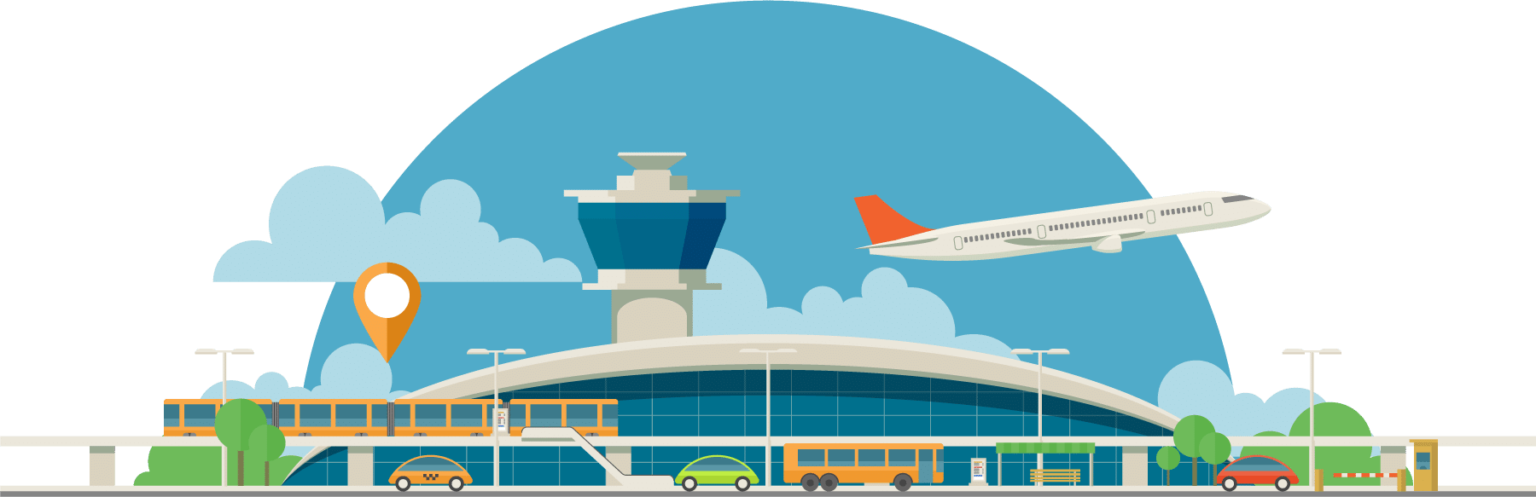

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода.

> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [ ]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install eli5
!pip install missingno
!pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.8 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions 
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import eli5
import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


# Data Prep & EDA (2.5 балла + 0.25)

## Загрузка и предобработка данных (1.5 балла)

In [ ]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-03-15 21:39:02--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-03-15 21:39:03 (404 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycog2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно. 

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

### Схема БД

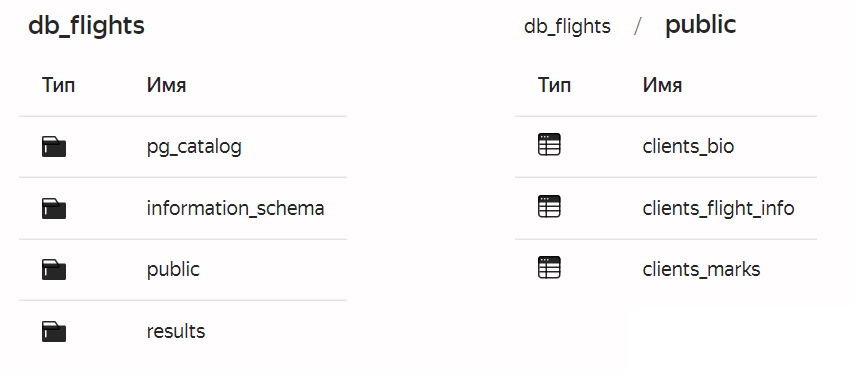

In [ ]:
conn = psycopg2.connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
port=6432,
sslmode='verify-full',
dbname='db_flights',
user='mlhs_student',
password='mlhs_student',
target_session_attrs='read-write')

In [ ]:
cur = conn.cursor()

In [ ]:
cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cur.fetchall():
    print(table)

('clients_bio',)
('clients_flight_info',)
('clients_marks',)
('student_predictions',)


In [ ]:
columns=[]
cur.execute("select column_name from information_schema.columns where table_schema = 'public' and table_name='clients_bio'")
columns.append(cur.fetchall())
cur.execute("select column_name from information_schema.columns where table_schema = 'public' and table_name='clients_flight_info'")
columns.append(cur.fetchall())
cur.execute("select column_name from information_schema.columns where table_schema = 'public' and table_name='clients_marks'")
columns.append(cur.fetchall())

In [ ]:
columns

[[('id',), ('gender',), ('age',)],
 [('id',),
  ('Customer Type',),
  ('Type of Travel',),
  ('class',),
  ('Flight Distance',),
  ('Departure Delay in Minutes',),
  ('Arrival Delay in Minutes',)],
 [('id',),
  ('Inflight wifi service',),
  ('Departure/Arrival time convenient',),
  ('Ease of Online booking',),
  ('Gate location',),
  ('Food and drink',),
  ('Online boarding',),
  ('Seat comfort',),
  ('Inflight entertainment',),
  ('On-board service',),
  ('Leg room service',),
  ('Baggage handling',),
  ('Checkin service',),
  ('Inflight service',),
  ('cleanliness',),
  ('satisfaction',)]]

Напишем SQL запрос через sqlio, чтобы объединить таблицы в одну единую:

In [ ]:
import pandas.io.sql as sqlio
df = sqlio.read_sql_query("SELECT *FROM clients_bio, clients_flight_info, clients_marks  WHERE clients_bio.id = clients_flight_info.id AND clients_bio.id = clients_marks.id ;", conn)
df

In [ ]:
df=df.drop('id', axis=1)

In [ ]:
assert df.shape == (129_549, 23)

In [ ]:
conn.close()

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [ ]:
df = pd.read_parquet('Flights_data')

In [ ]:
df

gender   age      Customer Type   Type of Travel     class  \
0         Male  43.0     Loyal Customer  Business travel  Business   
1         Male  24.0  disloyal Customer  Business travel       Eco   
2       Female  61.0     Loyal Customer  Personal Travel       Eco   
3         Male  35.0  disloyal Customer  Business travel  Business   
4       Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129544  Female  59.0     Loyal Customer  Personal Travel       Eco   
129545    Male  61.0     Loyal Customer  Personal Travel       Eco   
129546    Male  44.0     Loyal Customer  Personal Travel       Eco   
129547    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129548    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                1963.0                         0.0                       0.0   
1                 453.0                        16.0                      30.0   
2                 821.0                         0.0                       0.0   
3                 212.0                         0.0                       0.0   
4                  67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129544            308.0                        32.0                      24.0   
129545            337.0                         0.0                       0.0   
129546            447.0                         0.0                       0.0   
129547            447.0                         0.0                       0.0   
129548            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
0                         3.0                                3.0  ...   
1                         2.0                                2.0  ...   
2                         2.0                                5.0  ...   
3                         2.0                                2.0  ...   
4                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129544                    3.0                                5.0  ...   
129545                    2.0                                4.0  ...   
129546                    2.0                                5.0  ...   
129547                    3.0                                4.0  ...   
129548                    4.0                                4.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
0                   4.0           5.0                     5.0   
1                   2.0           5.0                     5.0   
2                   1.0           5.0                     5.0   
3                   2.0           2.0                     2.0   
4                   5.0           4.0                     4.0   
...                 ...           ...                     ...   
129544              5.0           5.0                     3.0   
129545              2.0           3.0                     3.0   
129546              2.0           5.0                     5.0   
129547              3.0           4.0                     4.0   
129548              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                    5.0               5.0               5.0              4.0   
1                    2.0               4.0               4.0              2.0   
2                    5.0               2.0               5.0              5.0   
3                    4.0               5.0               5.0              5.0   
4                    4.0               4.0               4.0              5.0   
...                  ...               ...        

In [ ]:
df_names = [column for column in df]
df_names

['gender',
 'age',
 'Customer Type',
 'Type of Travel',
 'class',
 'Flight Distance',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes',
 'Inflight wifi service',
 'Departure/Arrival time convenient',
 'Ease of Online booking',
 'Gate location',
 'Food and drink',
 'Online boarding',
 'Seat comfort',
 'Inflight entertainment',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Inflight service',
 'cleanliness',
 'satisfaction']

In [ ]:
cat_feat = ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']

In [ ]:
for i in cat_feat:
  df_names.remove(i)

In [ ]:
for i in df_names:
  df[i] = df[i].astype (float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129549 entries, 0 to 129548
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129549 non-null  object 
 3   Type of Travel                     129549 non-null  object 
 4   class                              129549 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      1295

In [ ]:
df.isnull().sum()

gender                                 0
age                                  315
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

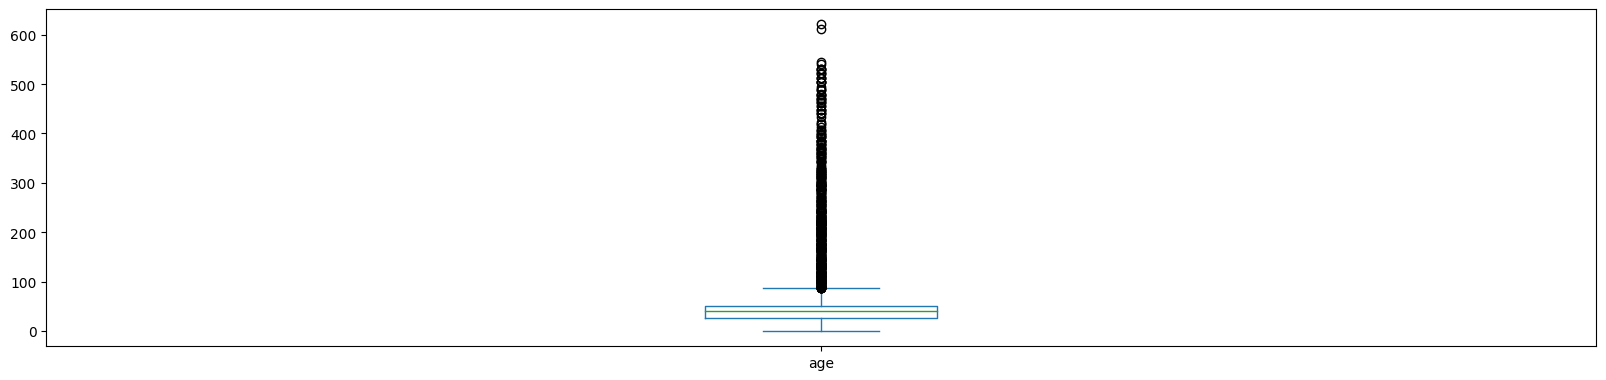

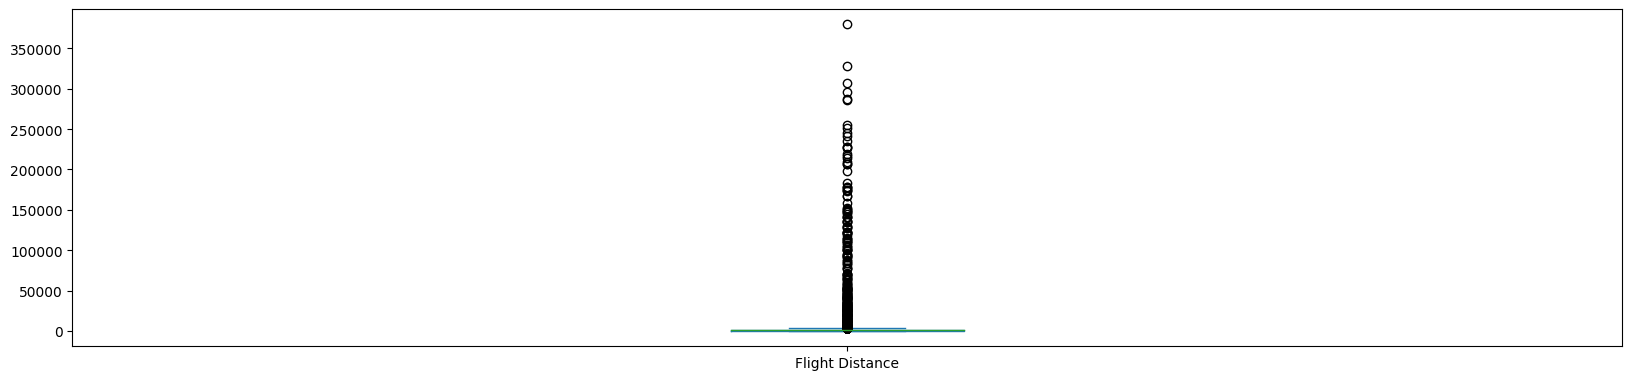

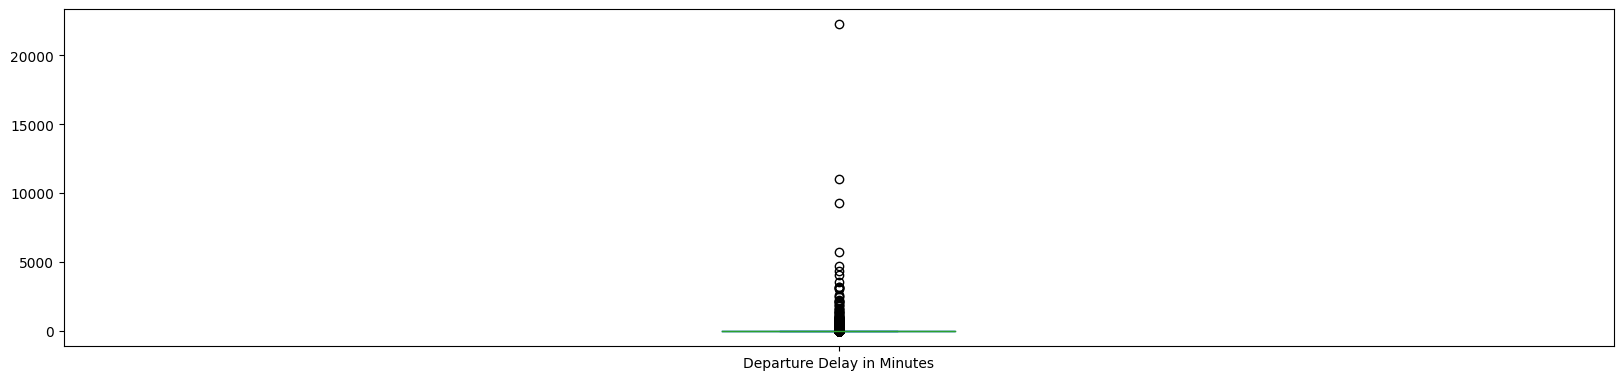

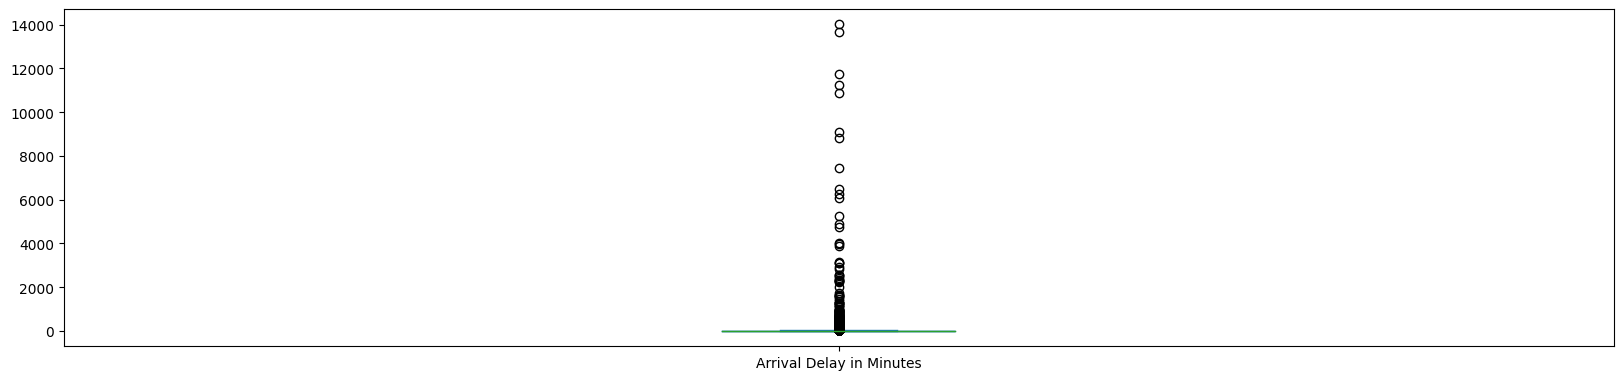

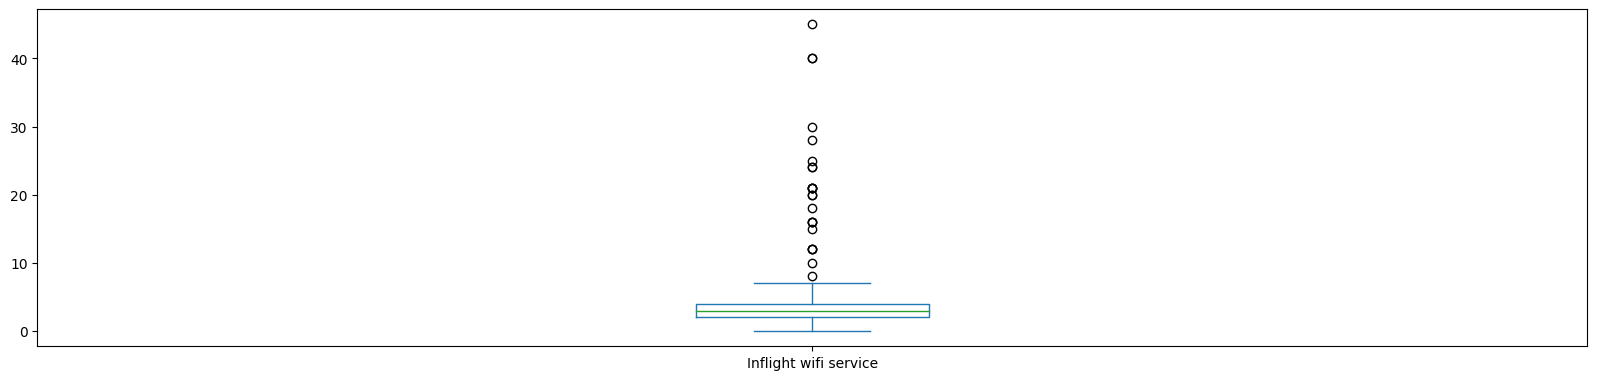

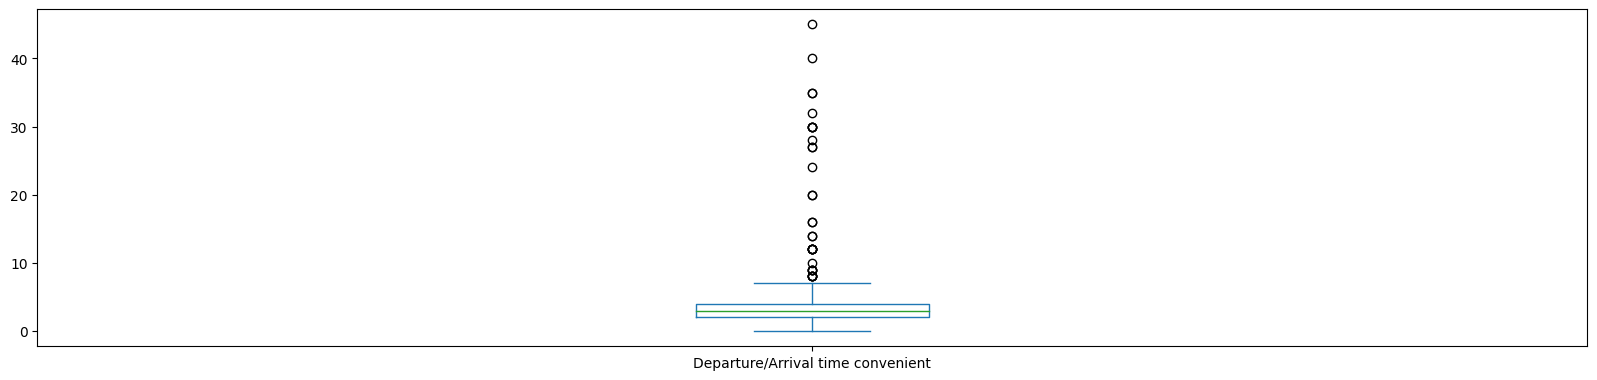

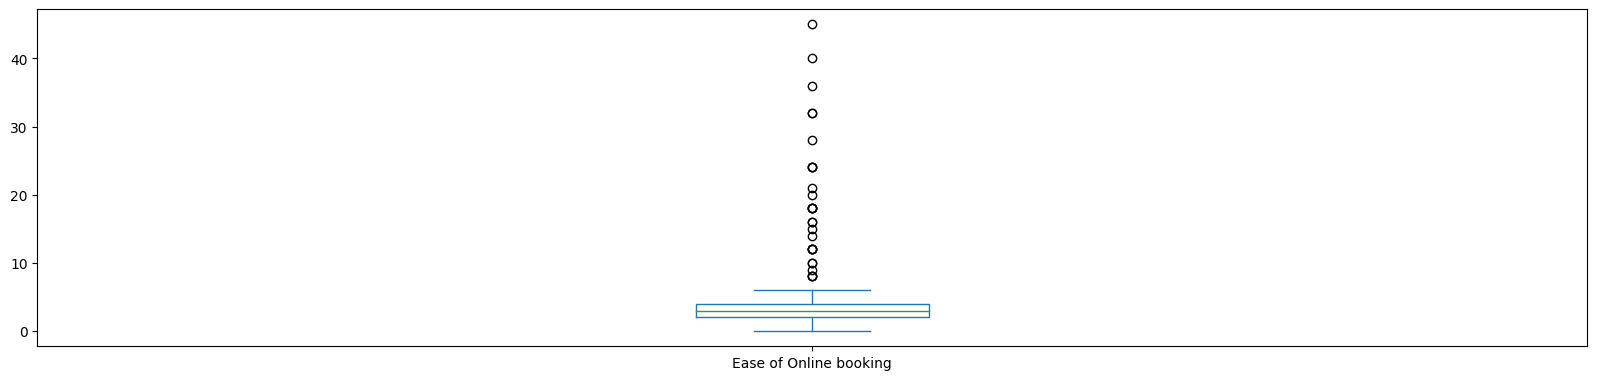

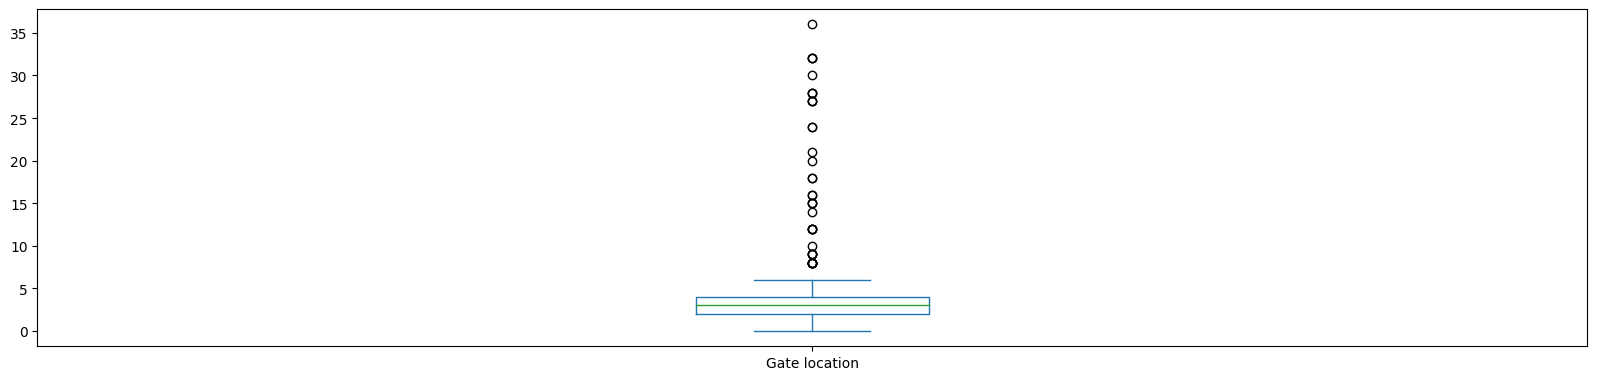

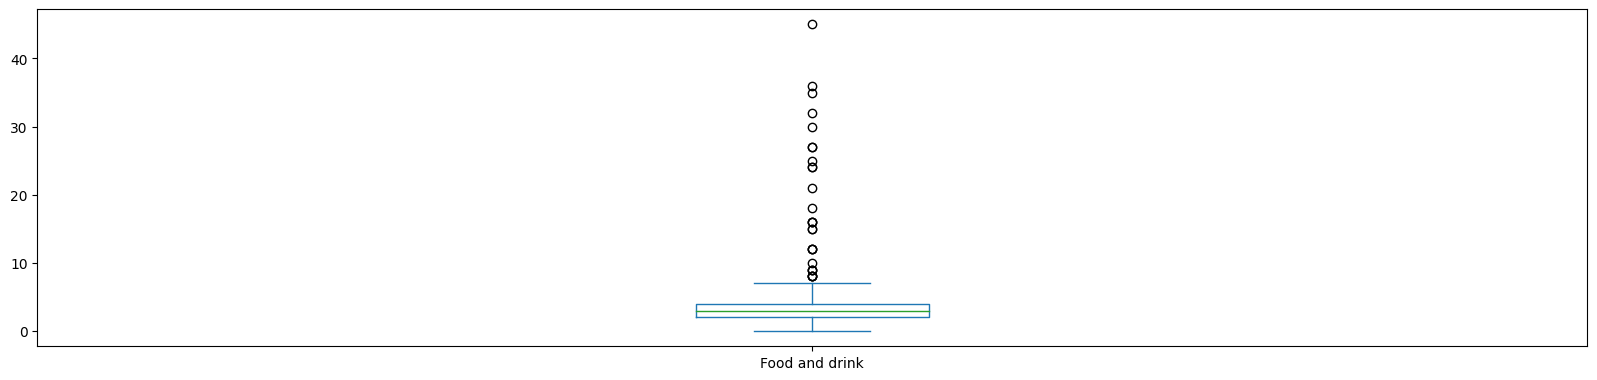

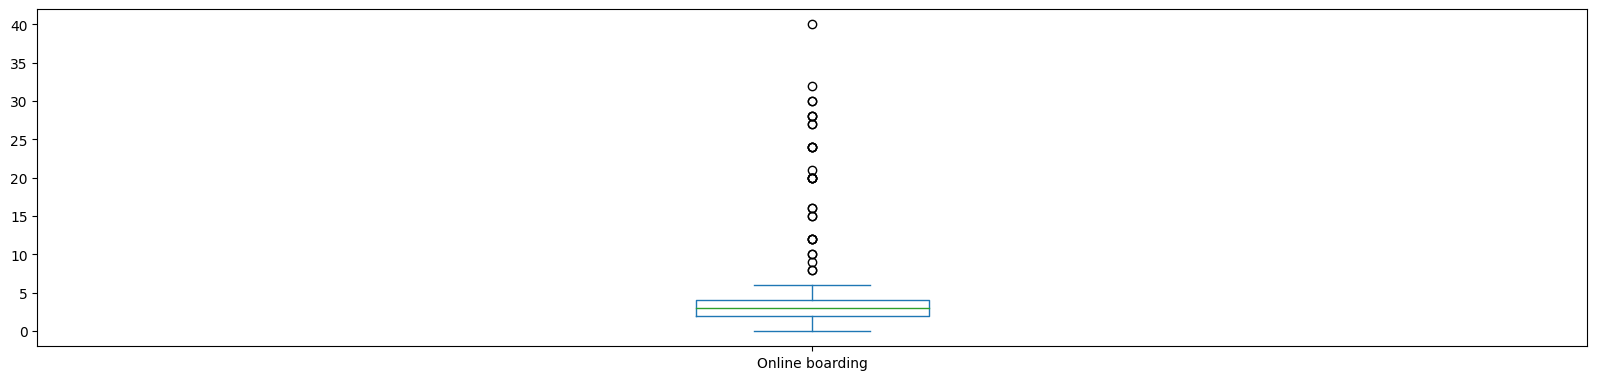

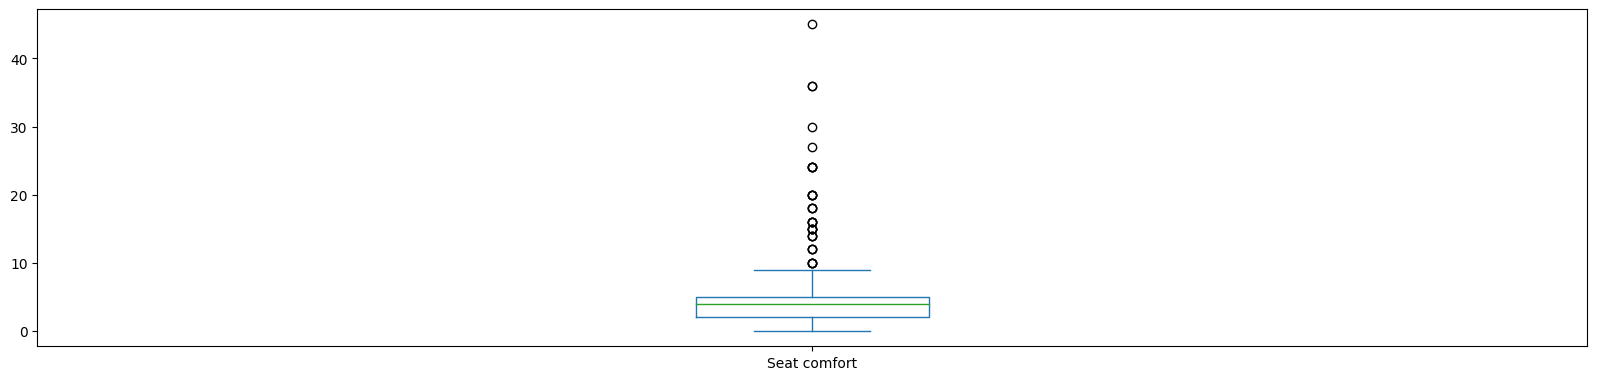

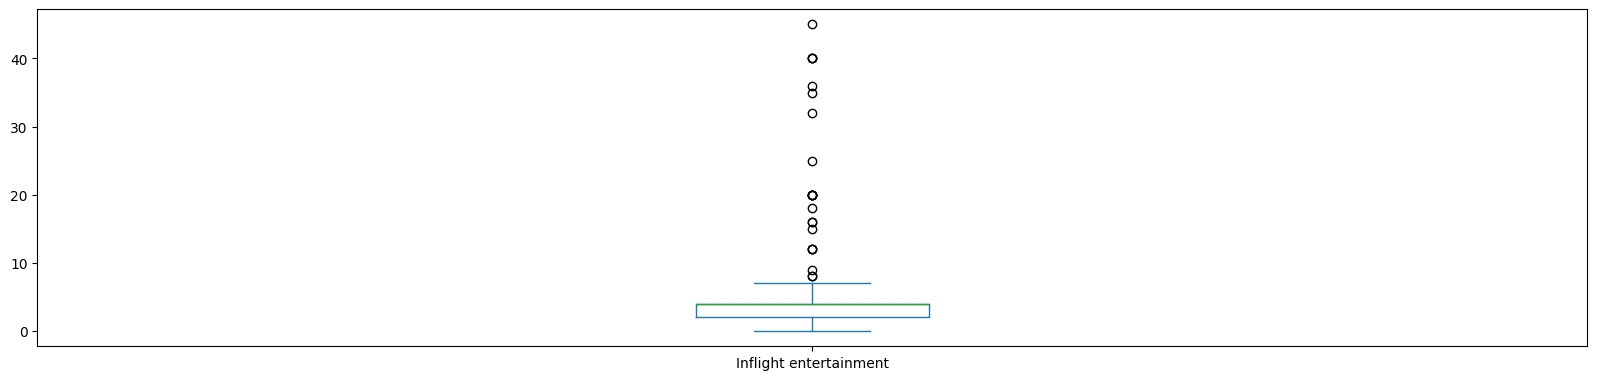

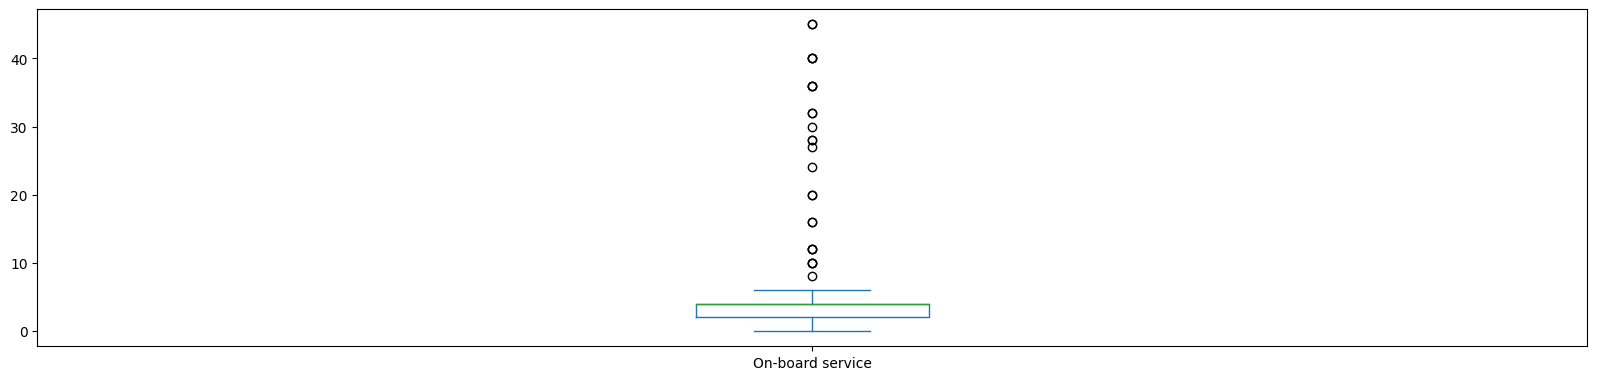

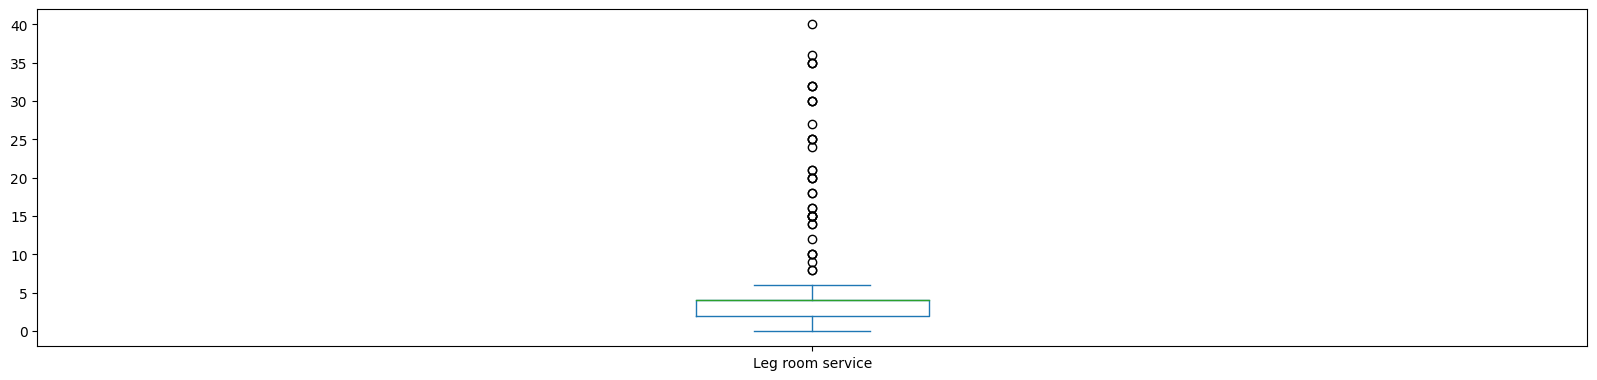

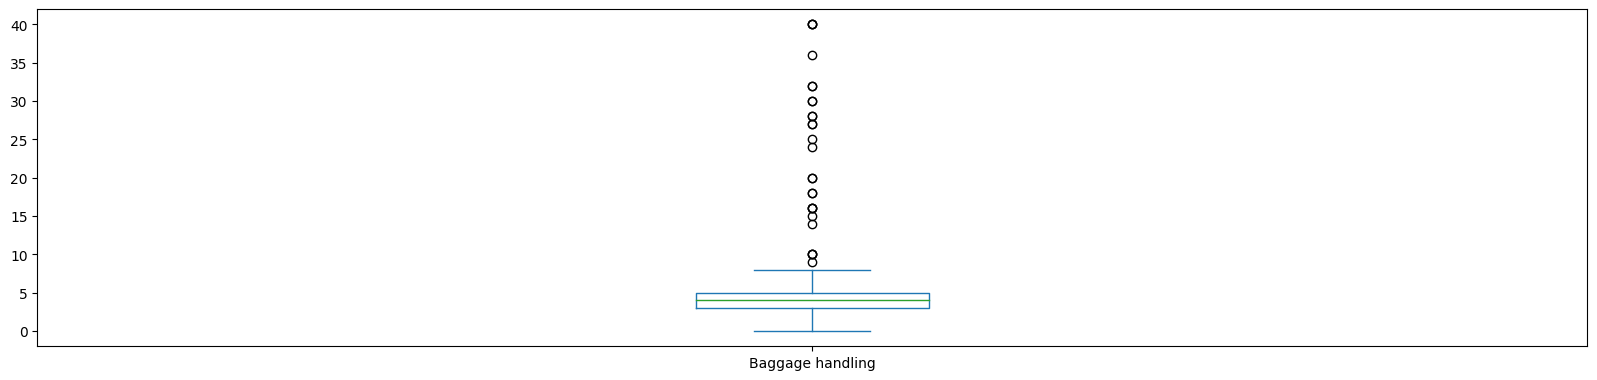

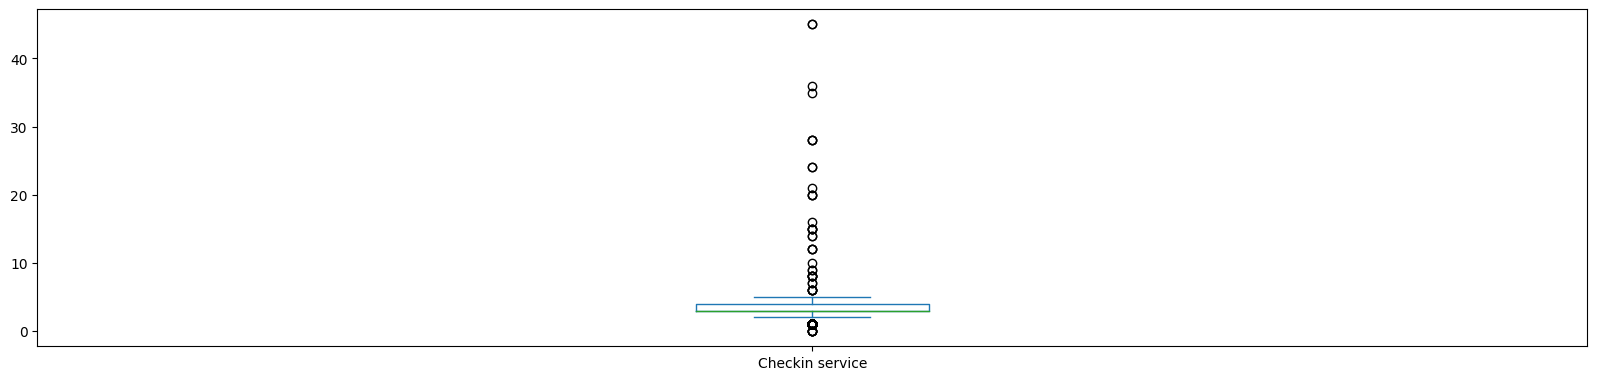

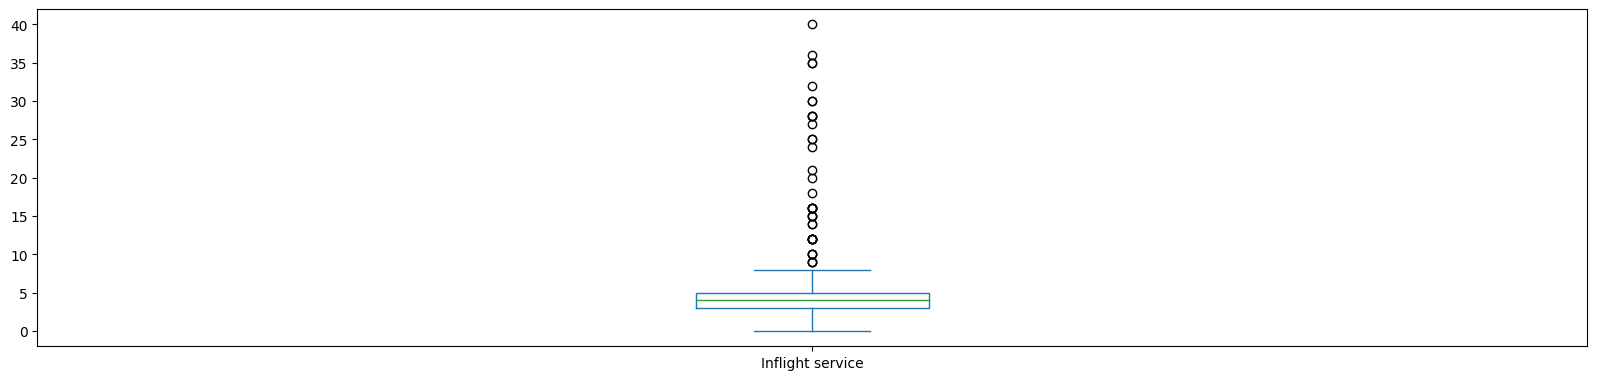

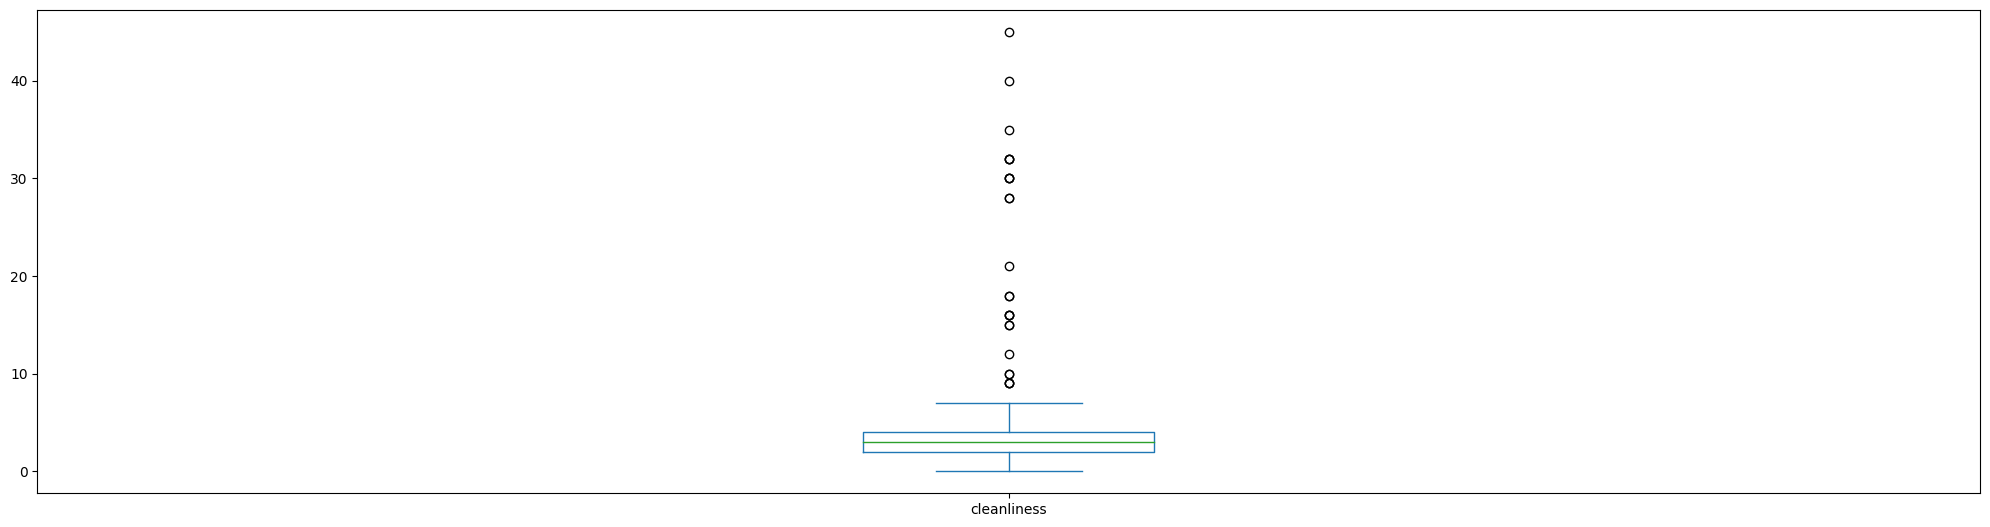

In [ ]:

total_axes = len(df.columns) 
                             
subplt = 1 
for x in df_names:
    fig = plt.figure(figsize=(20,120))
    ax = fig.add_subplot(total_axes, 1, subplt) 
    df[x].plot.box() 

plt.tight_layout()
plt.show()

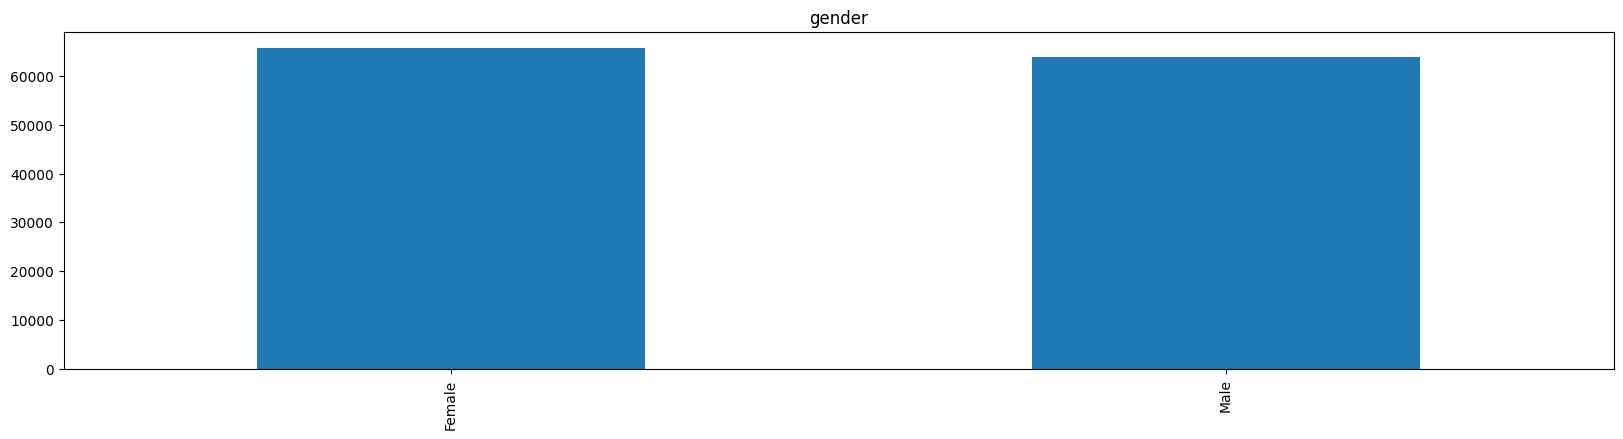

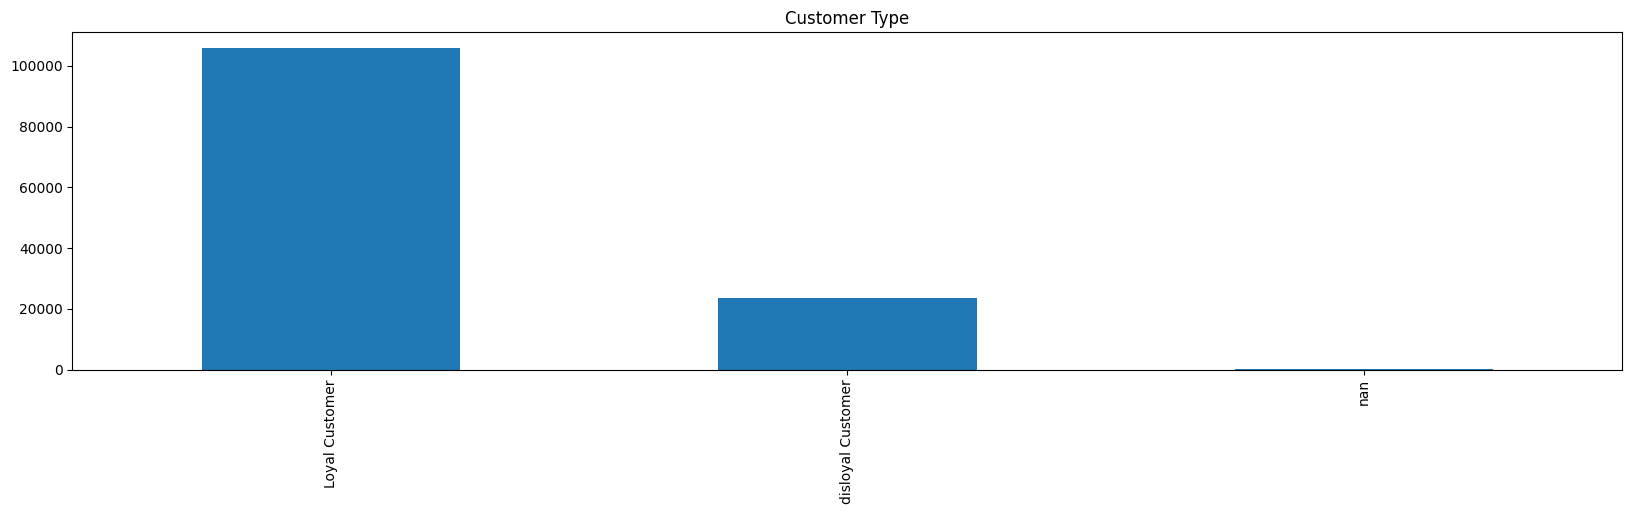

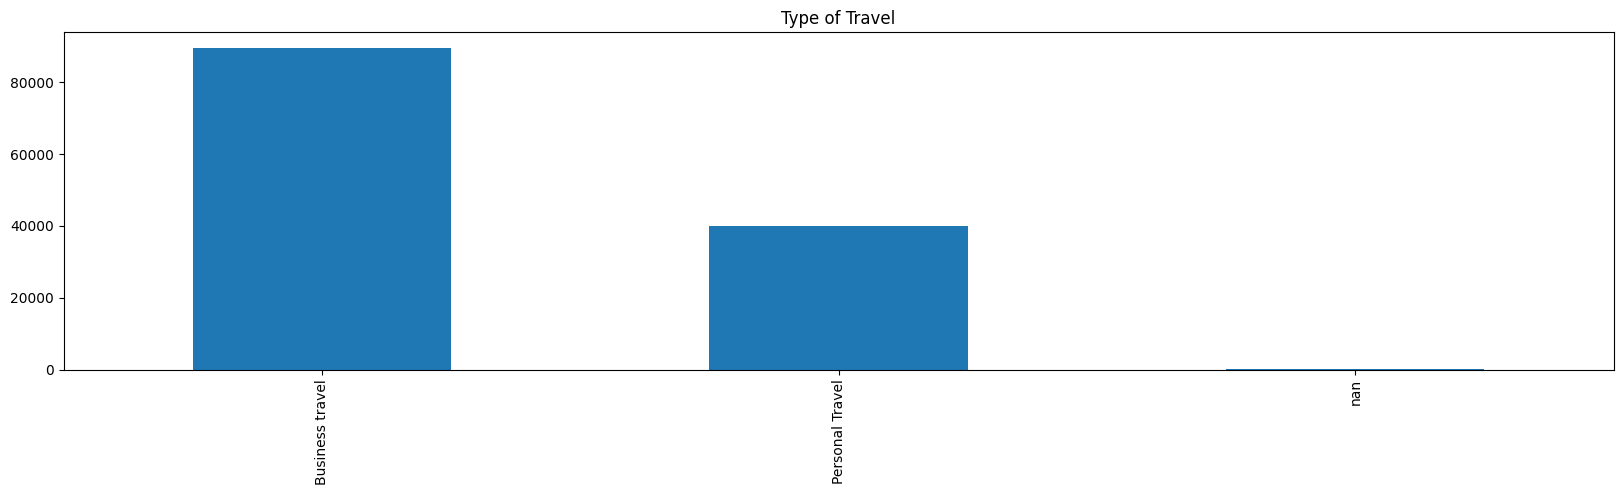

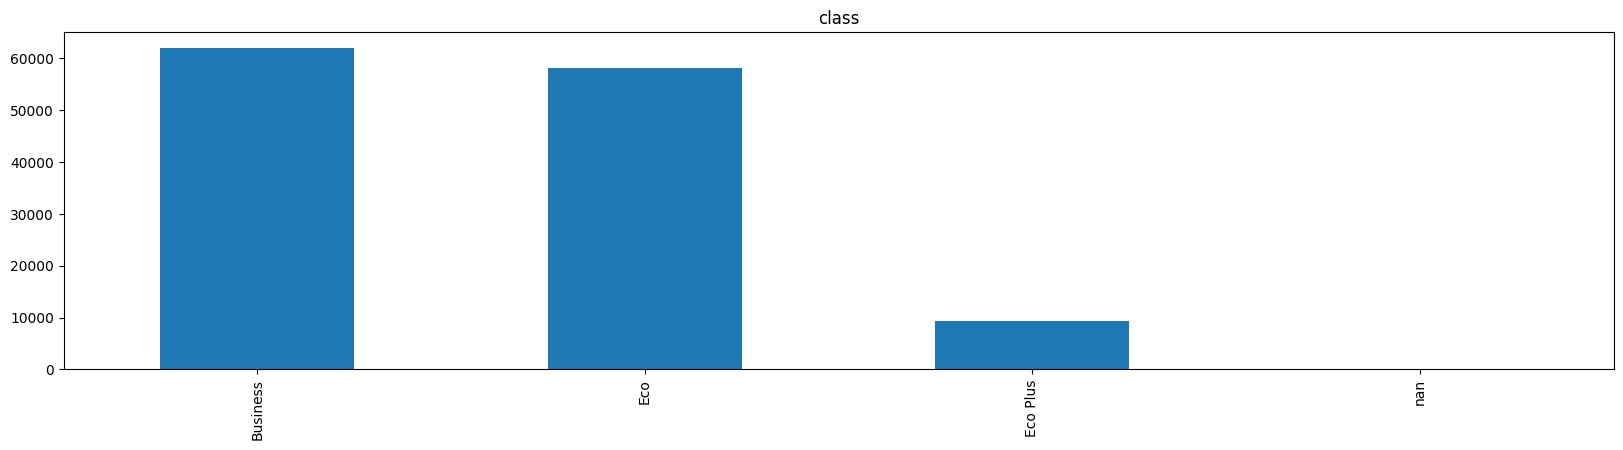

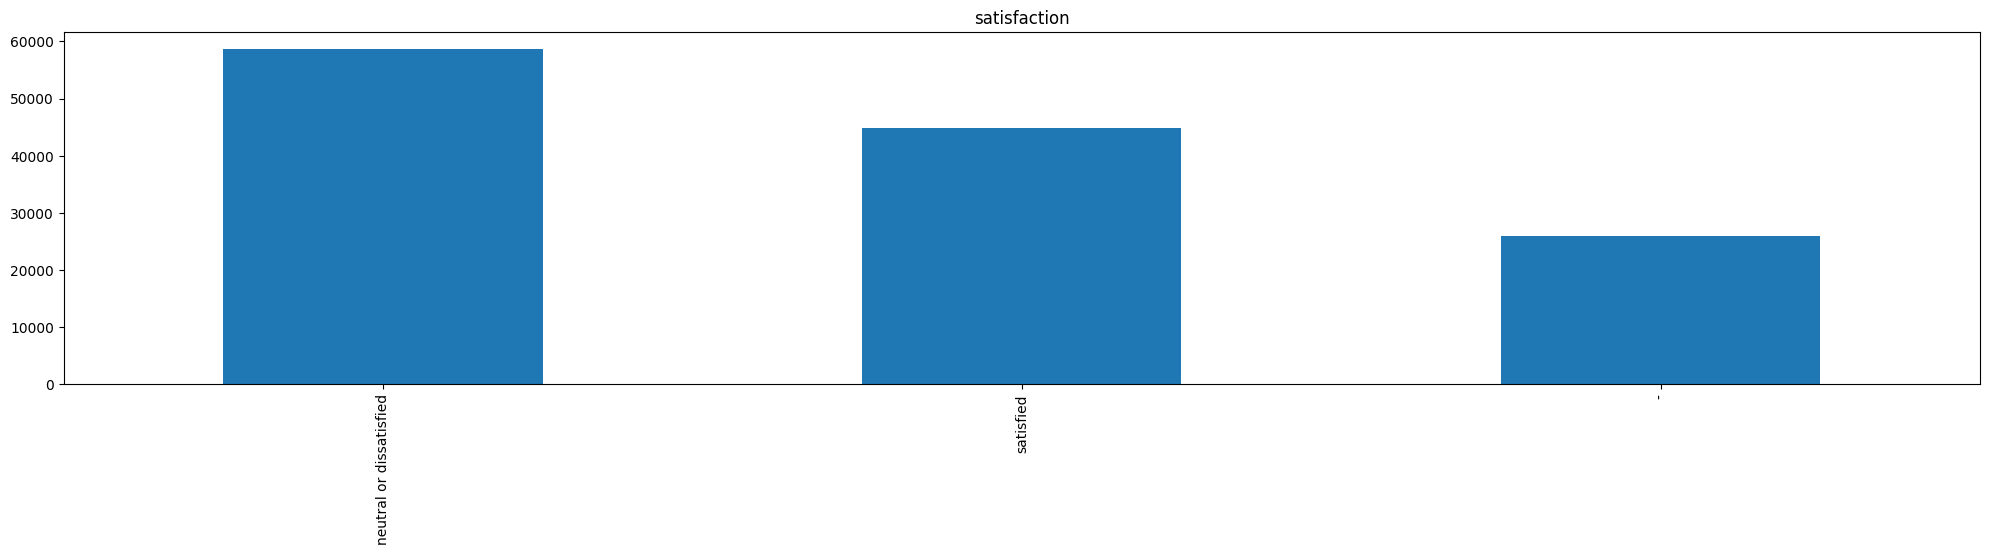

In [ ]:

total_axes = len(df.columns) 
subplt = 1 
for x in cat_feat:
    fig = plt.figure(figsize=(20,120))
    ax = fig.add_subplot(total_axes, 1, subplt) 
    plt.title(x)
    df[x].value_counts().plot.bar()
    subplt+=1

plt.tight_layout()
plt.show()

Видим, что в вещественных признаках в каждом есть выбросы. В категориальных признаках есть нетипичные пропуски "nan" в признаках: Class, Type of Travel, Customer Type

(0.25 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

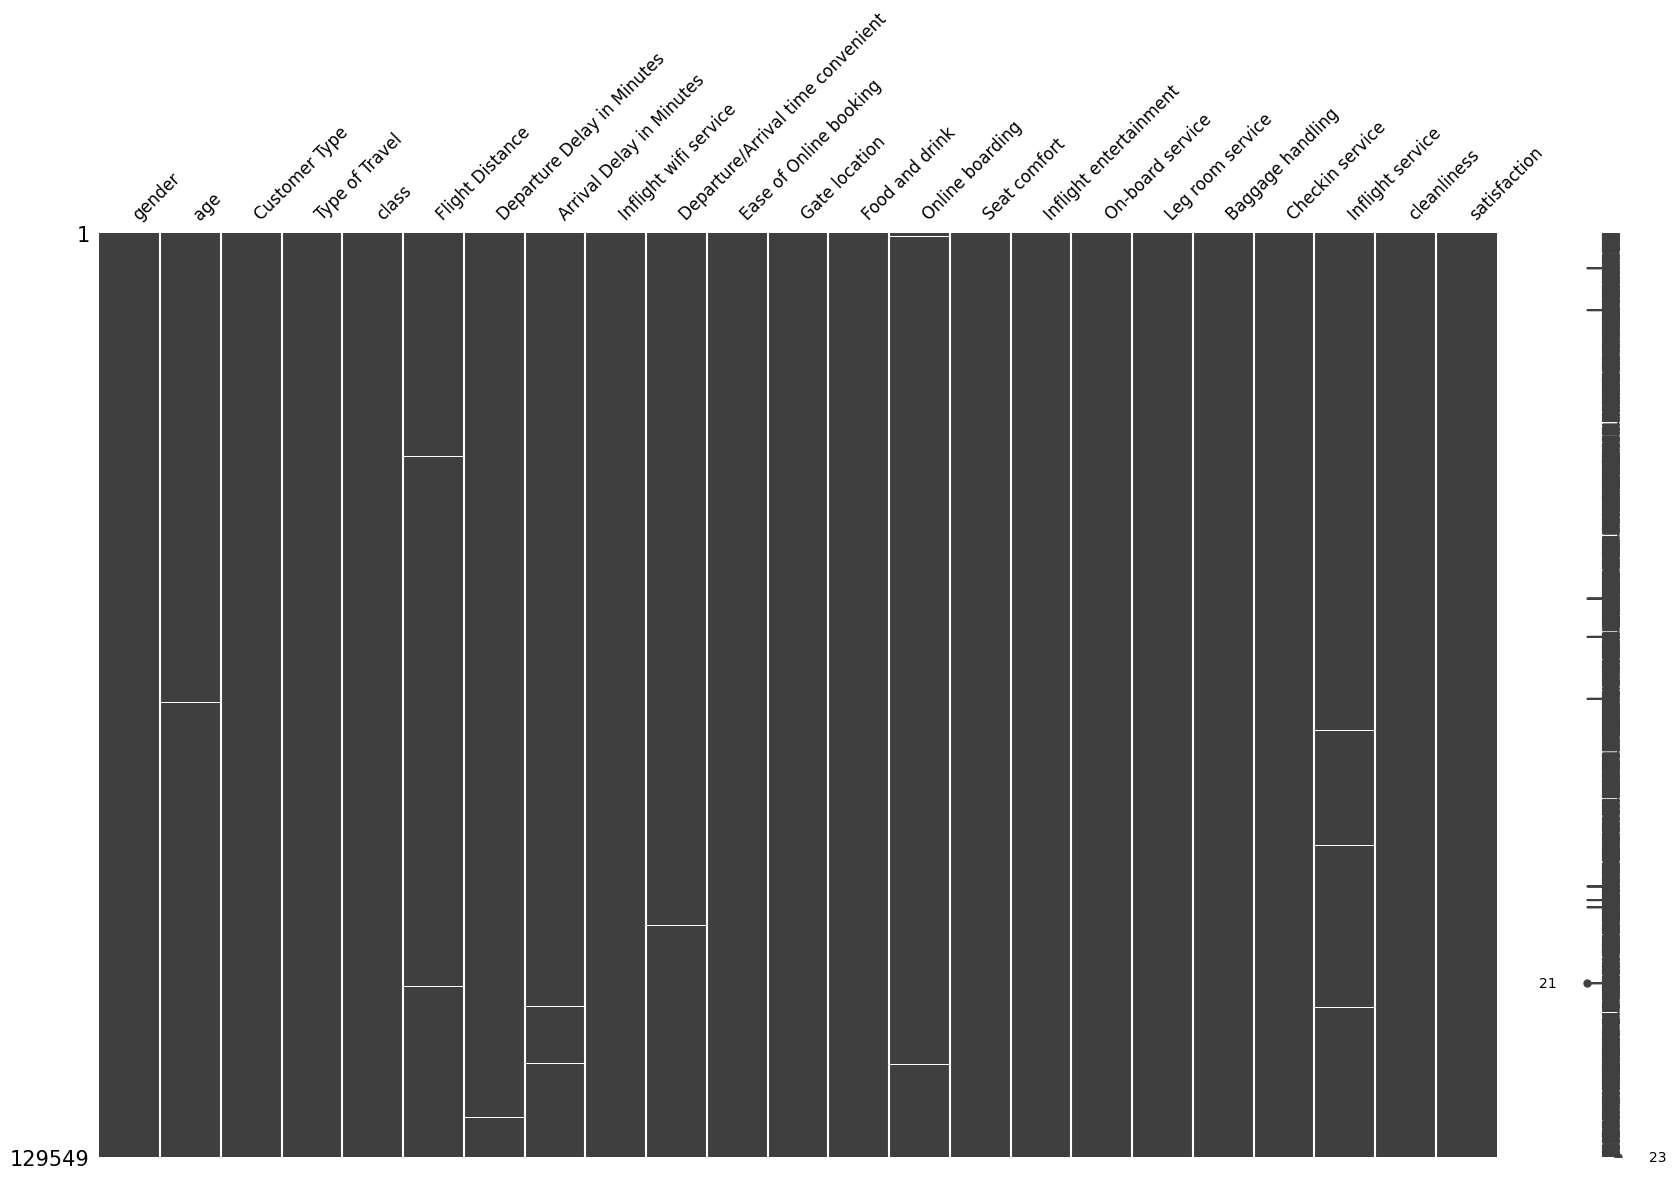

In [ ]:
missingno.matrix(df, figsize=(20,12), fontsize=12);


FixedFormatter should only be used together with FixedLocator


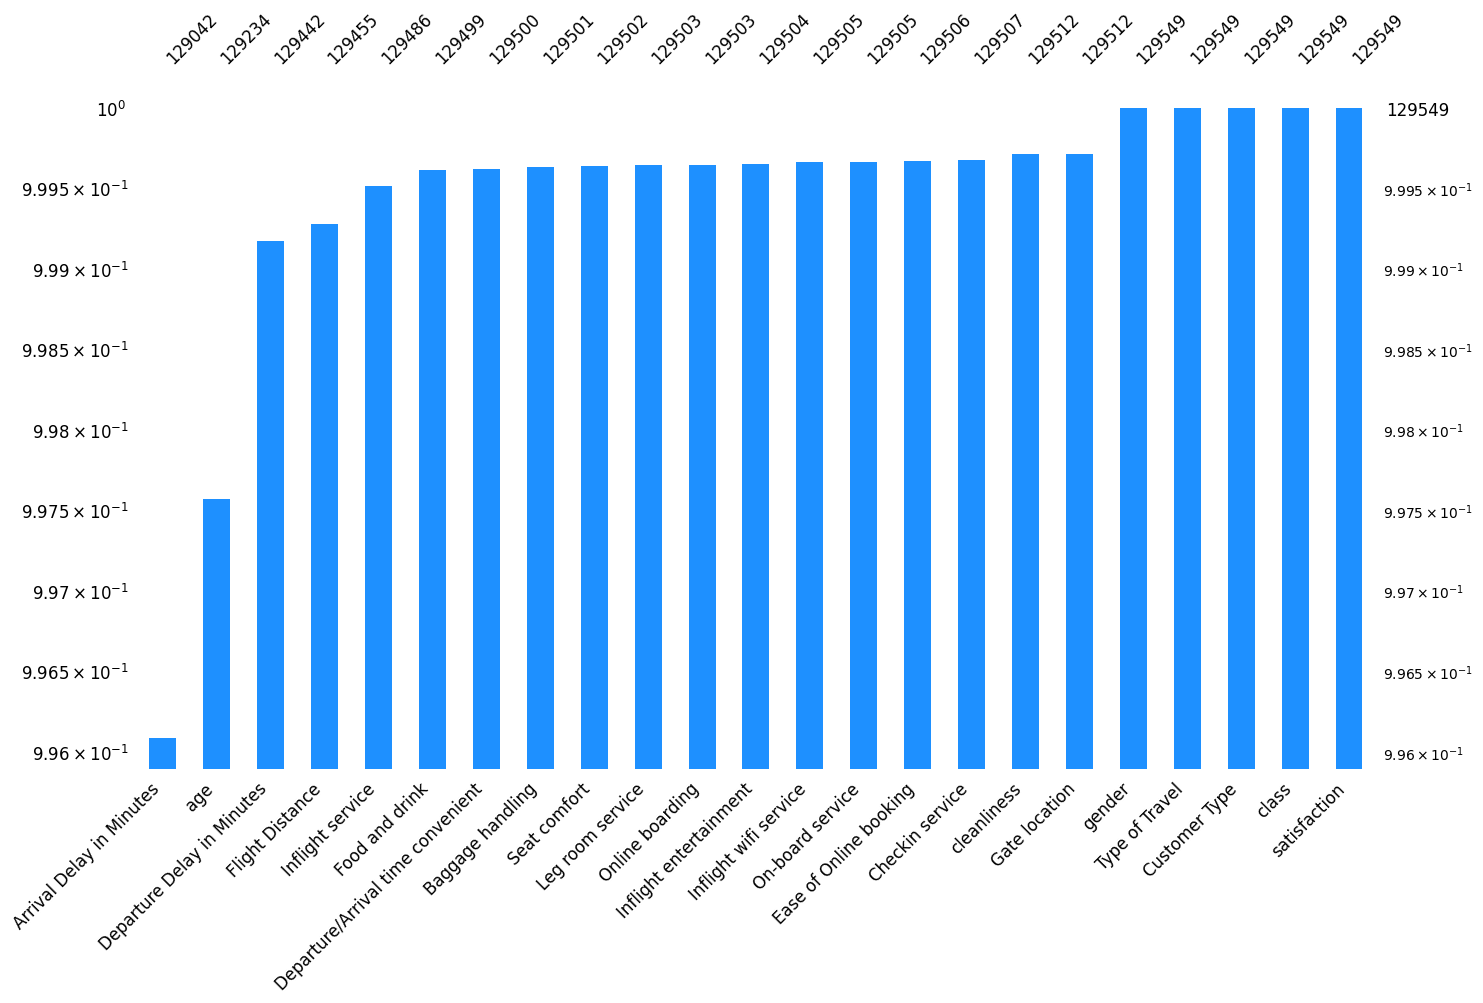

In [ ]:
missingno.bar(df, color="dodgerblue", sort="ascending",log=True, figsize=(16,9), fontsize=12);

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [ ]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
0         Male  43.0     Loyal Customer  Business travel  Business   
1         Male  24.0  disloyal Customer  Business travel       Eco   
2       Female  61.0     Loyal Customer  Personal Travel       Eco   
3         Male  35.0  disloyal Customer  Business travel  Business   
4       Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129542  Female  28.0     Loyal Customer  Personal Travel       Eco   
129543    Male  66.0     Loyal Customer  Personal Travel       Eco   
129544  Female  59.0     Loyal Customer  Personal Travel       Eco   
129545    Male  61.0     Loyal Customer  Personal Travel       Eco   
129546    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                1963.0                         0.0                       0.0   
1                 453.0                        16.0                      30.0   
2                 821.0                         0.0                       0.0   
3                 212.0                         0.0                       0.0   
4                  67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129542            447.0                        23.0                      16.0   
129543            337.0                       199.0                     213.0   
129544            308.0                        32.0                      24.0   
129545            337.0                         0.0                       0.0   
129546            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
0                         3.0                                3.0  ...   
1                         2.0                                2.0  ...   
2                         2.0                                5.0  ...   
3                         2.0                                2.0  ...   
4                         3.0                                3.0  ...   
...                       ...                                ...  ...   
129542                    1.0                                3.0  ...   
129543                    2.0                                4.0  ...   
129544                    3.0                                5.0  ...   
129545                    2.0                                4.0  ...   
129546                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
0                   4.0           5.0                     5.0   
1                   2.0           5.0                     5.0   
2                   1.0           5.0                     5.0   
3                   2.0           2.0                     2.0   
4                   5.0           4.0                     4.0   
...                 ...           ...                     ...   
129542              1.0           3.0                     3.0   
129543              5.0           5.0                     5.0   
129544              5.0           5.0                     3.0   
129545              2.0           3.0                     3.0   
129546              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
0                    5.0               5.0               5.0              4.0   
1                    2.0               4.0               4.0              2.0   
2                    5.0               2.0               5.0              5.0   
3                    4.0               5.0               5.0              5.0   
4                    4.0               4.0               4.0              5.0   
...                  ...               ...        

In [ ]:
assert df_train.shape == (103_644, 23)

In [ ]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
5         Male  36.0  Loyal Customer  Business travel  Business   
7       Female  70.0  Loyal Customer  Personal Travel       Eco   
12        Male  66.0  Loyal Customer  Personal Travel       Eco   
19      Female  60.0  Loyal Customer  Business travel  Business   
24        Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129531    Male  38.0  Loyal Customer  Business travel       Eco   
129535    Male  16.0  Loyal Customer  Personal Travel       Eco   
129539  Female  43.0  Loyal Customer  Personal Travel       Eco   
129547    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129548    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
5                3655.0                        40.0                      71.0   
7                 108.0                        50.0                      41.0   
12                562.0                        88.0                      84.0   
19               3756.0                        36.0                      24.0   
24                802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129531            337.0                        92.0                      82.0   
129535            308.0                         2.0                       0.0   
129539            308.0                         0.0                       0.0   
129547            447.0                         0.0                       0.0   
129548            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
5                         1.0                                1.0  ...   
7                         5.0                                4.0  ...   
12                        2.0                                5.0  ...   
19                        4.0                                4.0  ...   
24                        1.0                                2.0  ...   
...                       ...                                ...  ...   
129531                    4.0                                3.0  ...   
129535                    3.0                                4.0  ...   
129539                    2.0                                4.0  ...   
129547                    3.0                                4.0  ...   
129548                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
5                  1.0              3.0           3.0                     3.0   
7                  4.0              4.0           4.0                     3.0   
12                 5.0              2.0           5.0                     5.0   
19                 2.0              4.0           5.0                     4.0   
24                 2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129531             4.0              5.0           4.0                     4.0   
129535             1.0              3.0           5.0                     1.0   
129539             3.0              5.0           5.0                     4.0   
129547             4.0              3.0           4.0                     4.0   
129548             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
5                    3.0               3.0               1.0              4.0   
7                    3.0               0.0               3.0              5.0   
12                   3.0               5.0               2.0              5.0   
19                   4.0               4.0              

In [ ]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [ ]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые. 

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [ ]:
X_train.mode()

gender   age   Customer Type   Type of Travel     class  Flight Distance  \
0  Female  39.0  Loyal Customer  Business travel  Business            337.0   

   Departure Delay in Minutes  Arrival Delay in Minutes  \
0                         0.0                       0.0   

   Inflight wifi service  Departure/Arrival time convenient  ...  \
0                    3.0                                4.0  ...   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
0             4.0              4.0           4.0                     4.0   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0               4.0               4.0               4.0              4.0   

   Inflight service  cleanliness  
0               4.0          4.0  

[1 rows x 22 columns]

In [ ]:
for i in df_names:
  X_train[i] =X_train[i].fillna(X_train[i].mode()[0])
for i in df_names:
  X_val[i] =X_val[i].fillna(X_train[i].mode()[0])
for i in df_names:
  df_test[i] =df_test[i].fillna(X_train[i].mode()[0])

In [ ]:
cat_feat_tr = ['gender', 'Customer Type', 'Type of Travel', 'class']

In [ ]:
for i in cat_feat_tr:
  X_train[i] =X_train[i].fillna(X_train[i].mode()[0])
for i in cat_feat_tr:
  X_val[i] =X_val[i].fillna(X_train[i].mode()[0])
for i in cat_feat_tr:
  df_test[i] =df_test[i].fillna(X_train[i].mode()[0])


В прошлых выкладках мы видели, что в ряде категориальных признаков есть пропуски с нижним регистром - "nan", которые не видят методы isnull/isna, найдем такие пропуски и заменем модой эти строки из датасетов:

In [ ]:
for i in cat_feat_tr:
  X_train[i].replace({'nan':X_train[i].mode()[0]}, inplace=True)
  X_val[i].replace('nan', X_train[i].mode()[0], inplace=True)
  df_test[i].replace('nan', X_train[i].mode()[0], inplace=True)

In [ ]:
X_train.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

In [ ]:
X_val.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

In [ ]:
df_test.isna().sum()

gender                               0
age                                  0
Customer Type                        0
Type of Travel                       0
class                                0
Flight Distance                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
cleanliness                          0
dtype: int64

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [ ]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [ ]:
X_val.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  31094.000000     31094.000000                31094.000000   
mean      39.955779      1316.469480                   15.666945   
std       19.549492      4379.003672                   80.658377   
min        0.000000         0.000000                    0.000000   
25%       27.000000       417.000000                    0.000000   
50%       40.000000       845.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      612.000000    255522.000000                11011.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              31094.000000           31094.000000   
mean                  16.871776               2.732521   
std                  131.103562               1.348038   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              40.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       31094.000000            31094.000000   
mean                            3.064836                2.758989   
std                             1.558570                1.439010   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            35.000000               45.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   31094.000000    31094.000000     31094.000000  31094.000000   
mean        2.978195        3.195215         3.252589      3.438477   
std         1.290490        1.358929         1.414625      1.356474   
min         1.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        32.000000       45.000000        40.000000     36.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            31094.000000      31094.000000      31094.000000   
mean                 3.359265          3.394578          3.367756   
std                  1.358533          1.337013          1.379536   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 36.000000         40.000000         40.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      31094.000000     31094.000000      31094.000000  31094.000000  
mean           3.648775         3.306908          3.655303      3.286776  
std            1.224217         1.321872          1.204409      1.345356  
min            1.000000         0.000000          1.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         35.000000     40.000000

In [ ]:
df_test.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  25905.000000     25905.000000                25905.000000   
mean      40.347500      1310.016754                   15.773287   
std       20.427892      3926.099247                  146.986226   
min        0.000000        31.000000                    0.000000   
25%       27.000000       414.000000                    0.000000   
50%       40.000000       850.000000                    0.000000   
75%       51.000000      1747.000000                   12.000000   
max      621.000000    241060.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              25905.000000           25905.000000   
mean                  16.101602               2.728740   
std                  109.437973               1.367287   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                13650.000000              30.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       25905.000000            25905.000000   
mean                            3.052577                2.762401   
std                             1.580435                1.465089   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            40.000000               40.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   25905.000000    25905.000000     25905.000000  25905.000000   
mean        2.983208        3.221888         3.263887      3.455318   
std         1.327939        1.375980         1.366739      1.350722   
min         1.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         4.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        28.000000       30.000000        28.000000     24.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            25905.000000      25905.000000      25905.000000   
mean                 3.362131          3.391160          3.353098   
std                  1.392701          1.338648          1.343165   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         40.000000         35.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      25905.000000     25905.000000      25905.000000  25905.000000  
mean           3.636788         3.317352          3.656476      3.290484  
std            1.201829         1.286092          1.244320      1.360923  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           30.000000        24.000000         40.000000     35.000000

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

Максимальные значения на порядки больше средних значений и не вписываются в стандартные отклонения. Это указывает на большие значения выбросов в данных. Например, в признаке age тренировочного датасета можно увидеть, что значение возраста в выборках 544.

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [ ]:
indexes = []
for i in df_names:
  quan = X_val[i] > X_val[i].quantile(0.996)
  indx = quan[quan].index
  for x in indx:
    if x not in indexes:
      indexes.append(x)
X_val.drop(indexes, inplace=True)
y_val.drop(indexes, inplace=True)

In [ ]:
indexes = []
for i in df_names:
  quan = X_train[i] > X_train[i].quantile(0.996)
  indx = quan[quan].index
  for x in indx:
    if x not in indexes:
      indexes.append(x)
X_train.drop(indexes, inplace=True)
y_train.drop(indexes, inplace=True)

In [ ]:
# assert X_train.shape == (71_369, 22) эти ассерты у большинства студентов не проходили
# assert X_val.shape == (30_609, 22) и это совершенно не принципиально
assert df_test.shape == (25_905, 22)

## EDA (1 балл + 0.25)

Создадим переменные с перечислениями столбцов разного типа

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols)) 
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [ ]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [ ]:
def plot_ordinal(cols, df, y):
  for k in cols:
    plt.figure(figsize=(12,8))
    sns.countplot(x=df[k], hue=y)
    plt.title(k+' distribution')
    ax.set_title(k)
    ax.legend()
  plt.show()


In [ ]:
def plot_continuous(cols, df, y):
  for k in cols:
    plt.figure(figsize=(12,8))
    plt.subplot(1, 2, 1)
    plt.title(k + ' distribution')
    ax.set_title(k)
    ax.legend()
    sns.kdeplot(x=df[k], hue=y, common_norm=False, bw_method=0.15)
    plt.subplot(1, 2, 2)
    plt.title(k + ' boxplot by target')
    ax.set_title(k)
    ax.legend()
    sns.boxplot(x=df[k], y=y)
    plt.show()

In [ ]:
def plot_categorical(cols, df, y):
  for k in cols:
    plt.figure(figsize=(12,8))
    sns.countplot(x=df[k], hue=y)
    plt.title(k+' distribution')
    ax.set_title(k)
    ax.legend()
  plt.show()

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

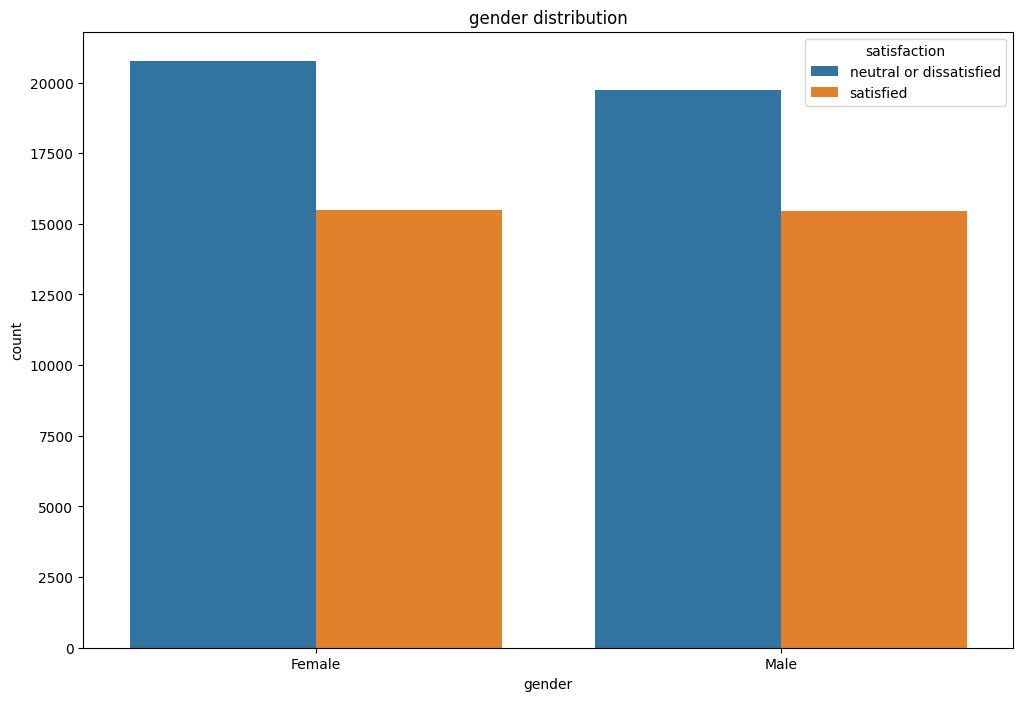

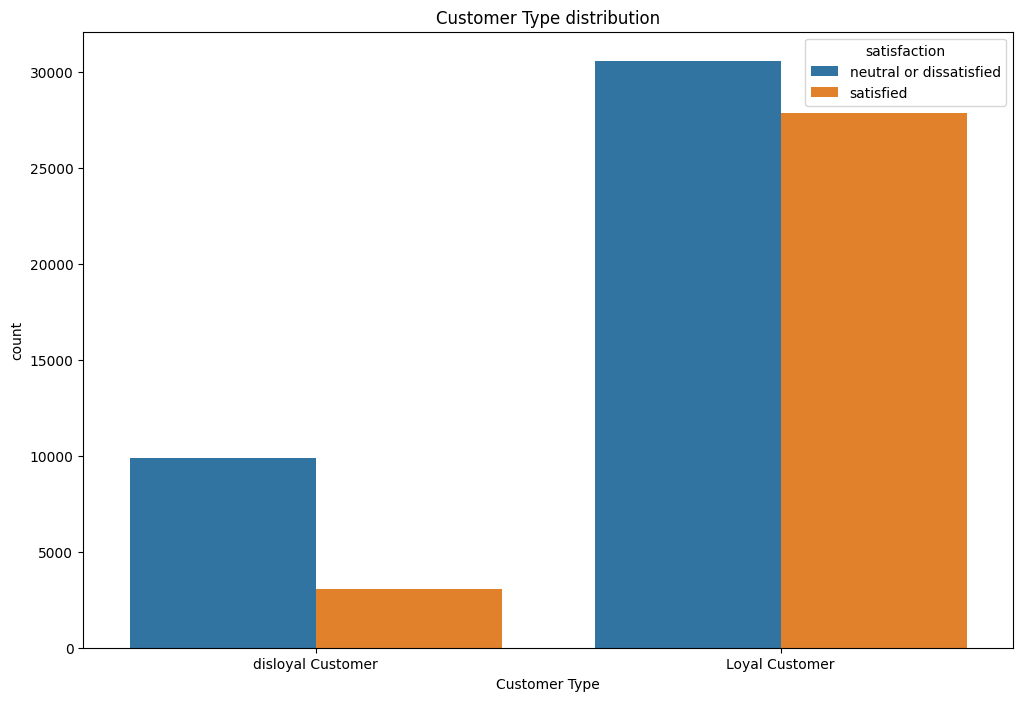

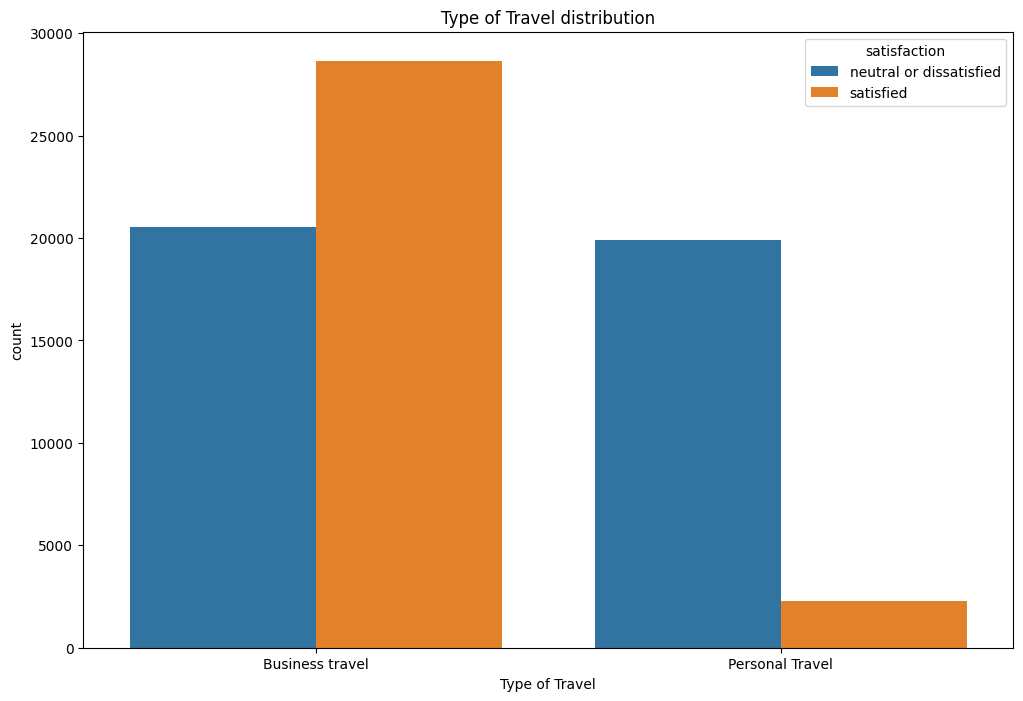

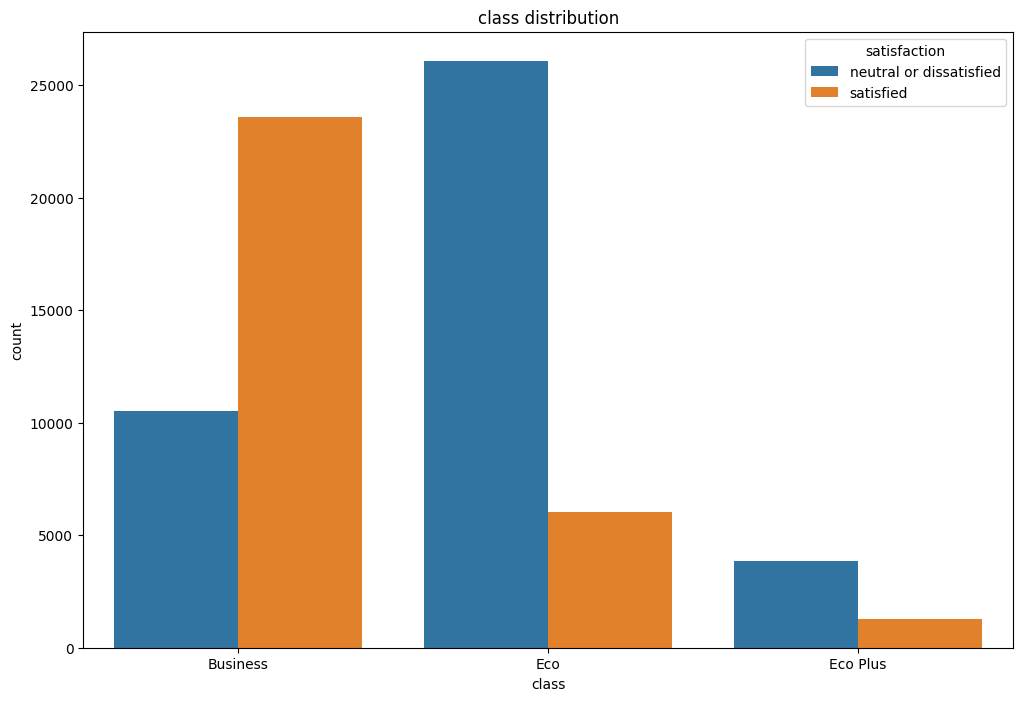

In [ ]:
plot_categorical(categorical_cols, X_train, y_train)

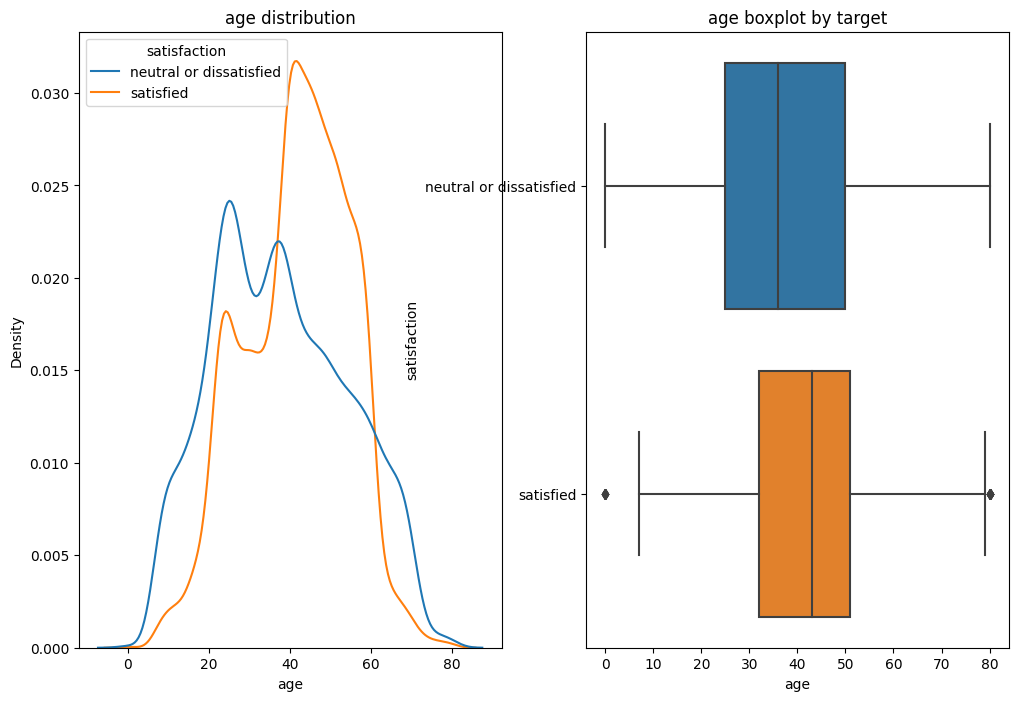

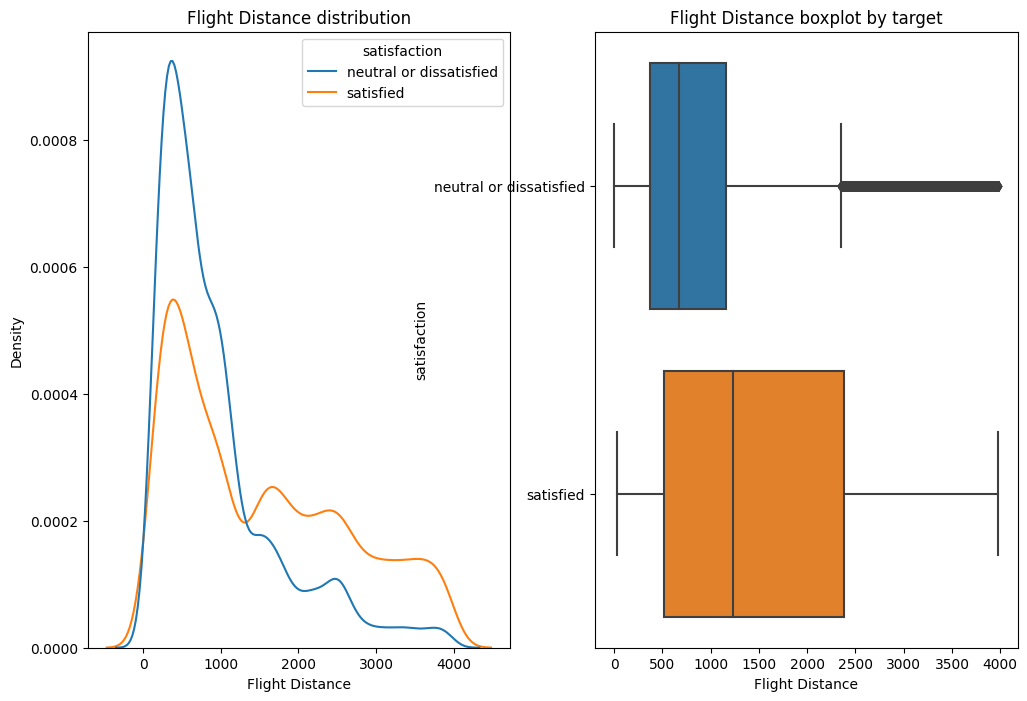

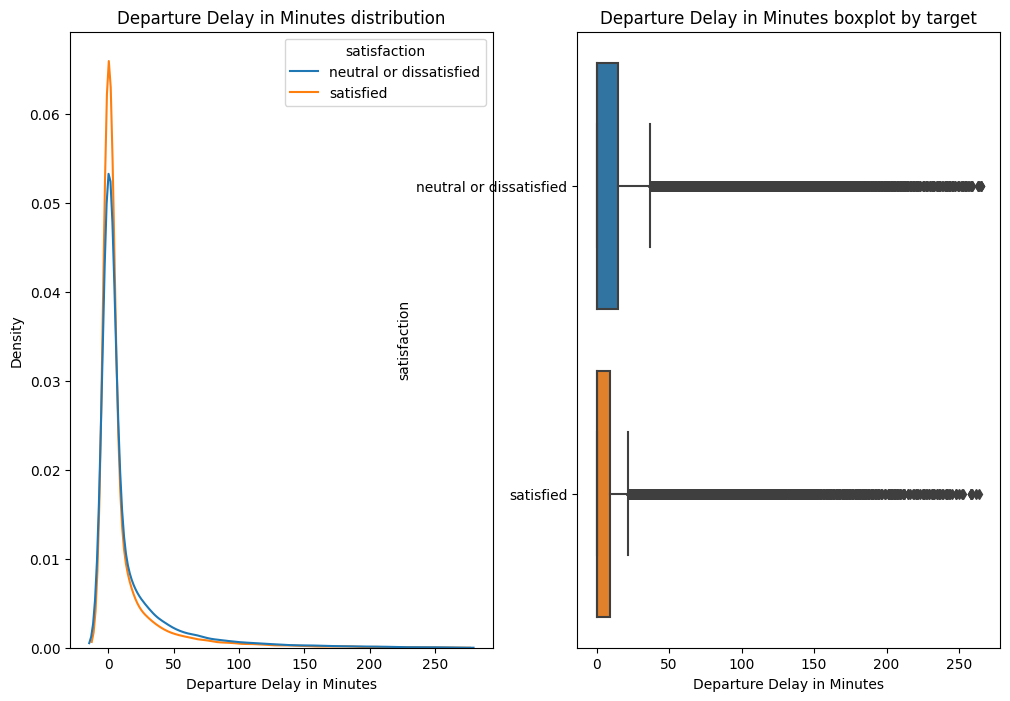

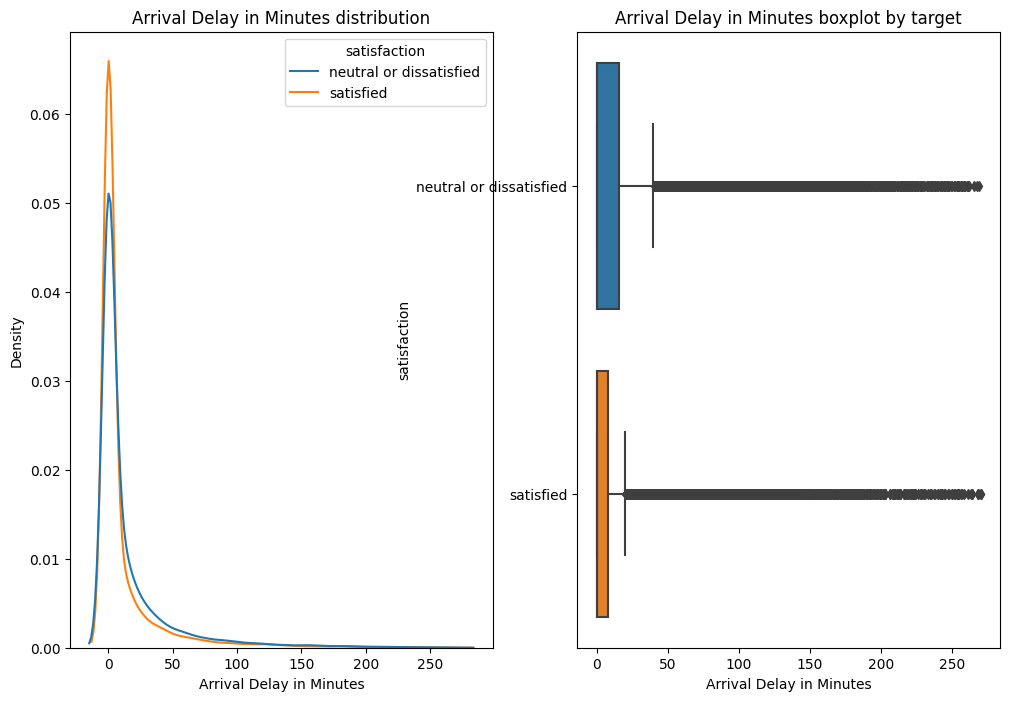

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

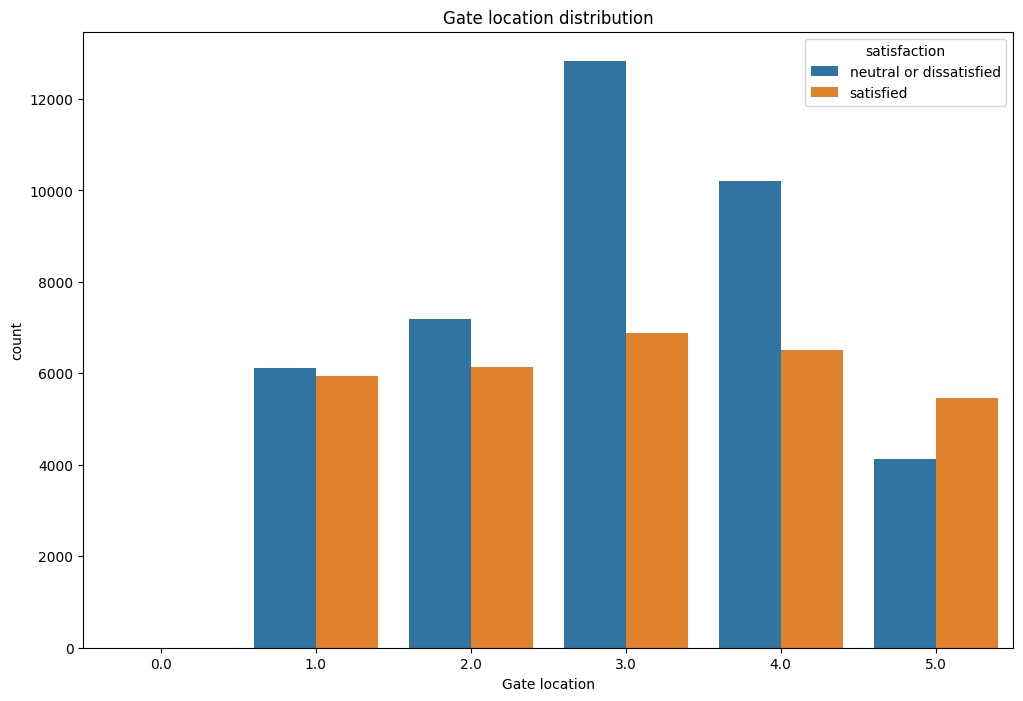

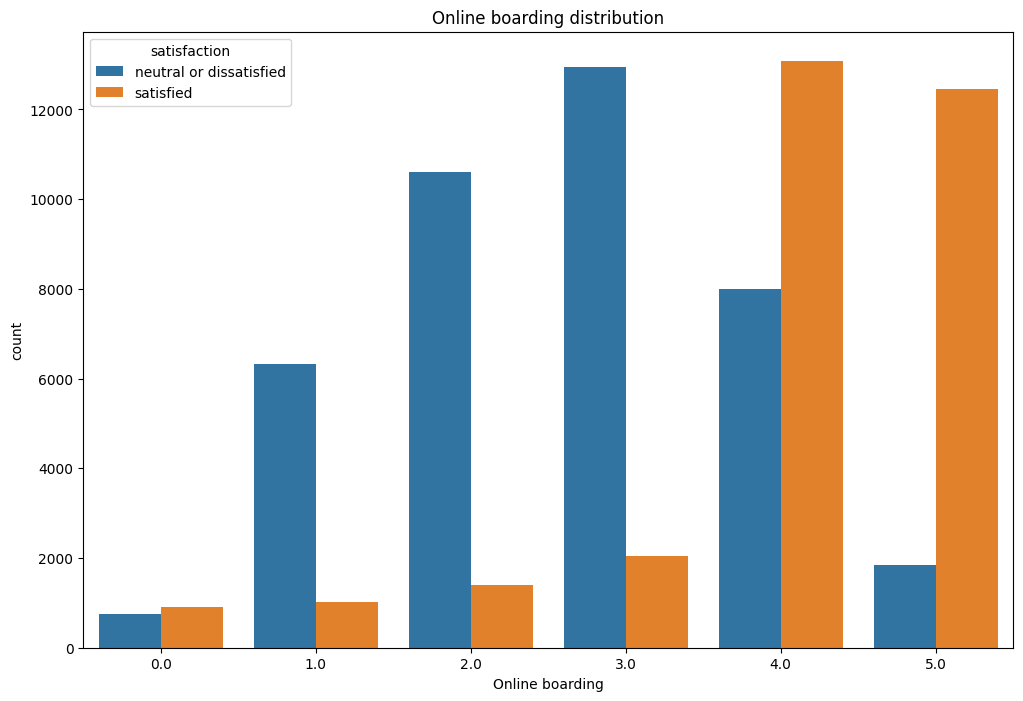

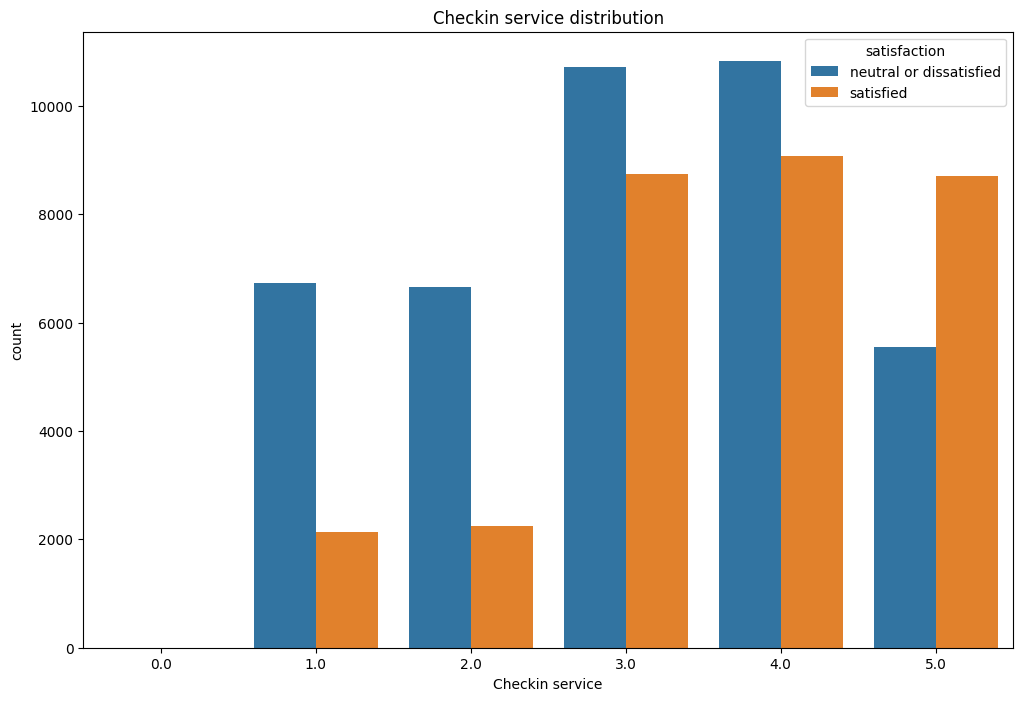

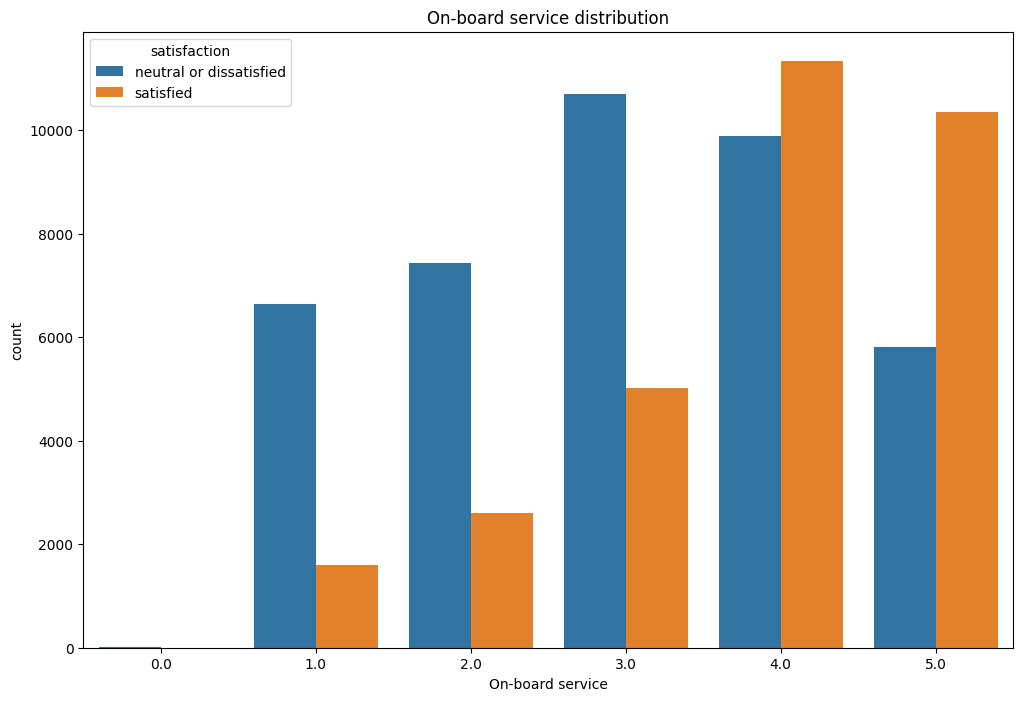

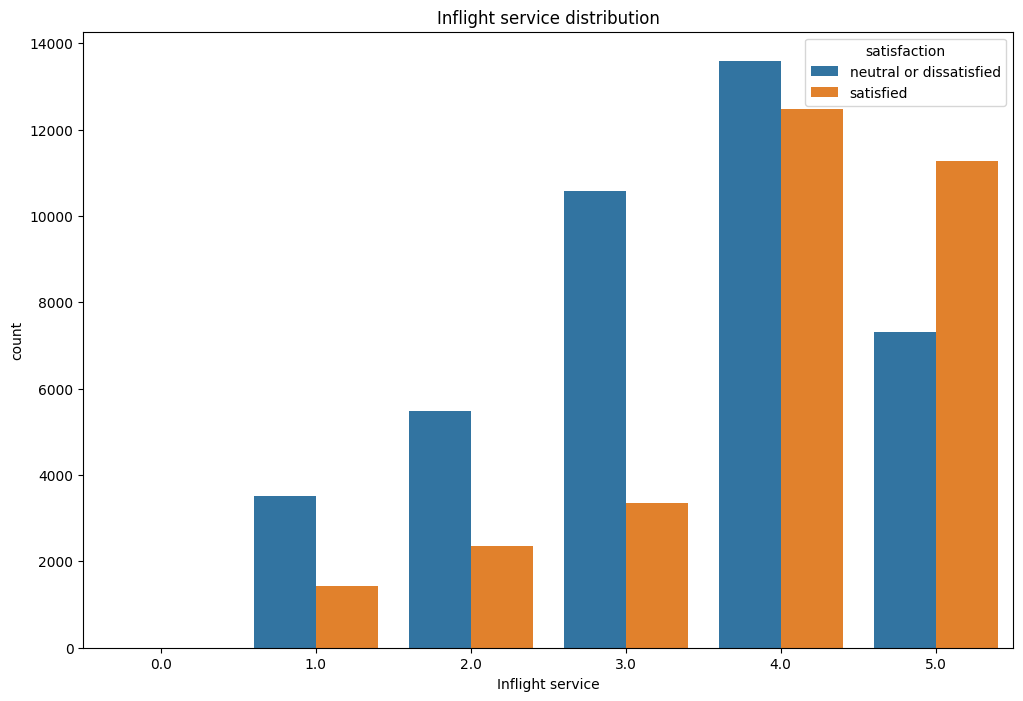

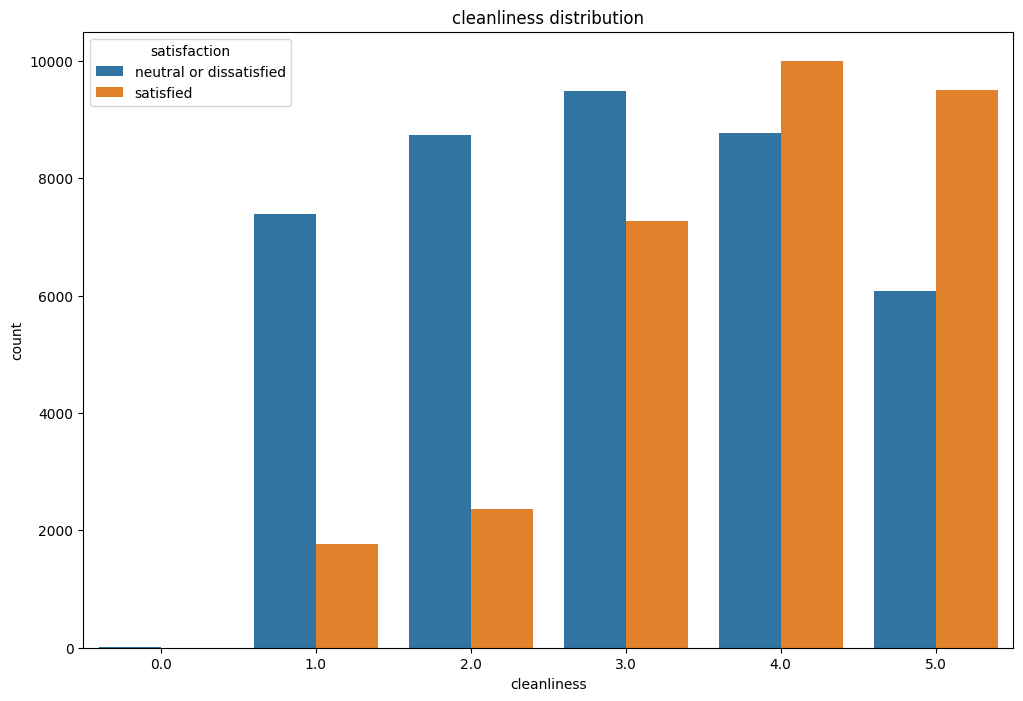

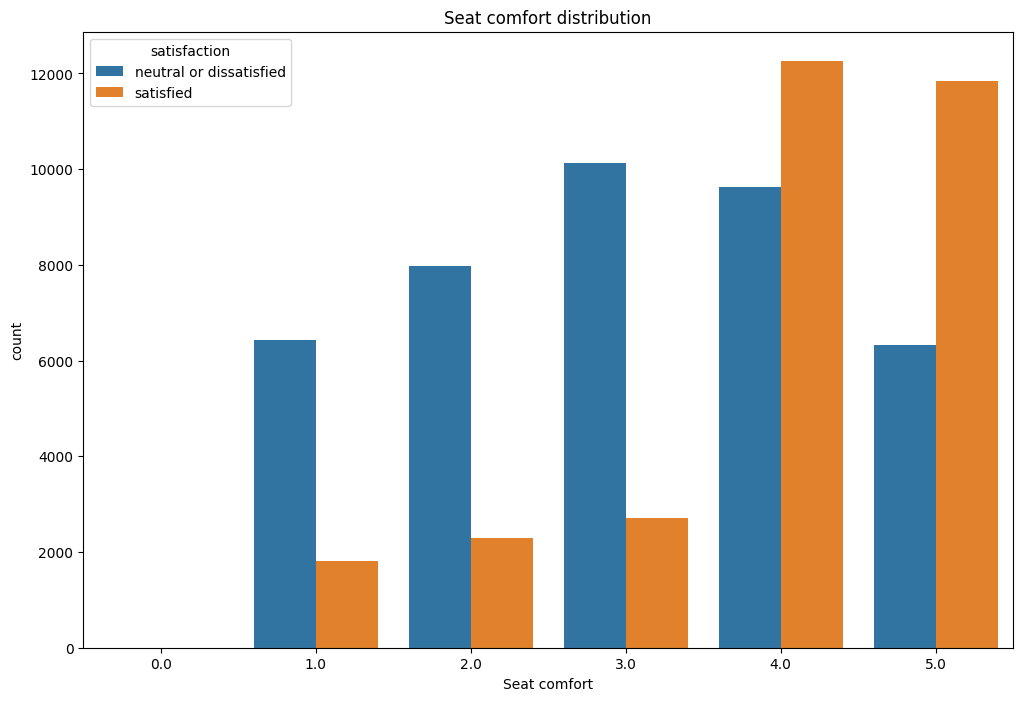

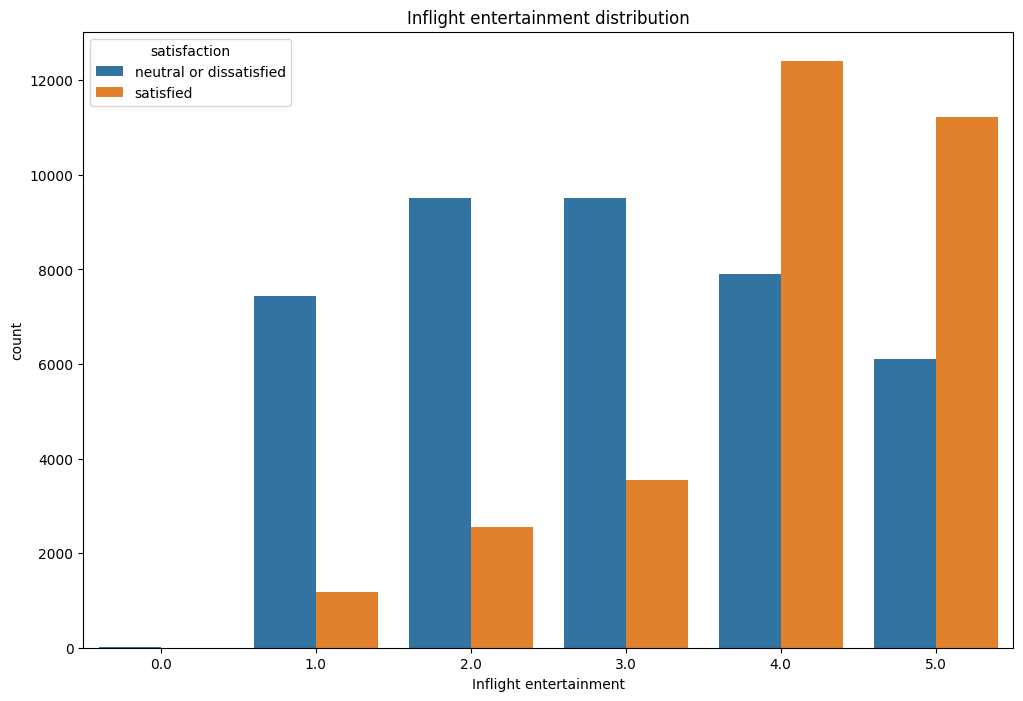

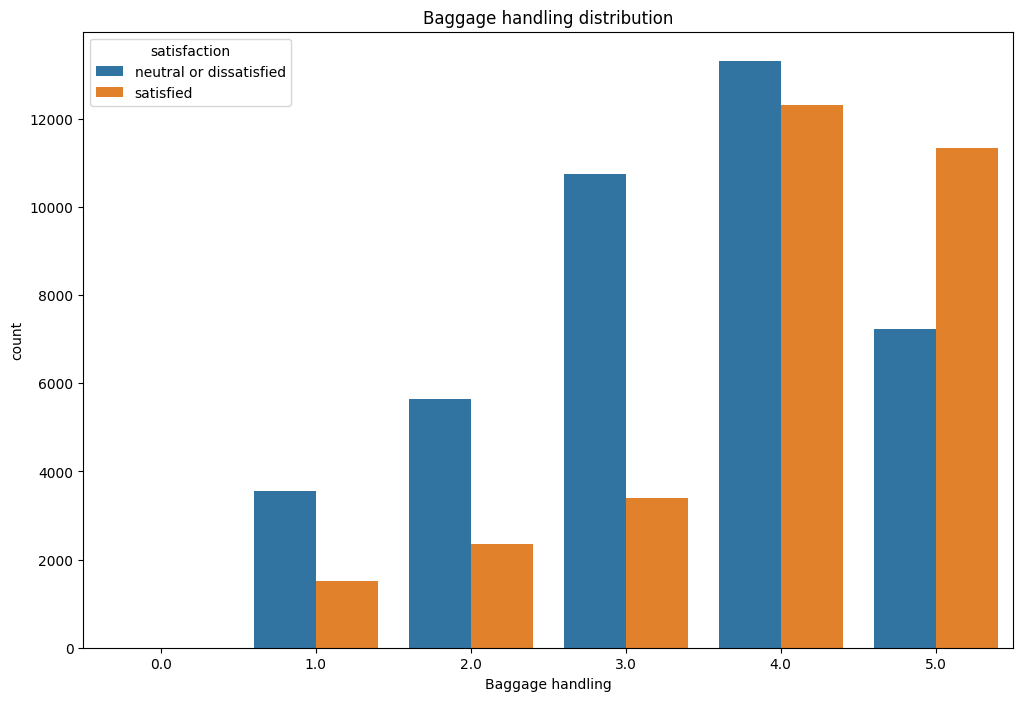

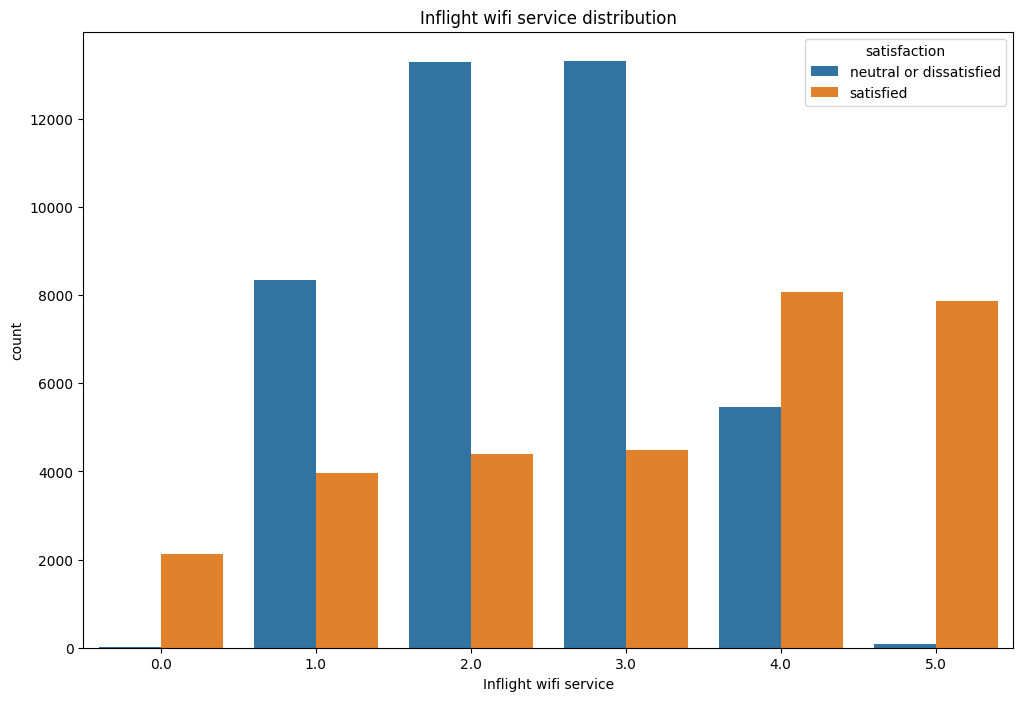

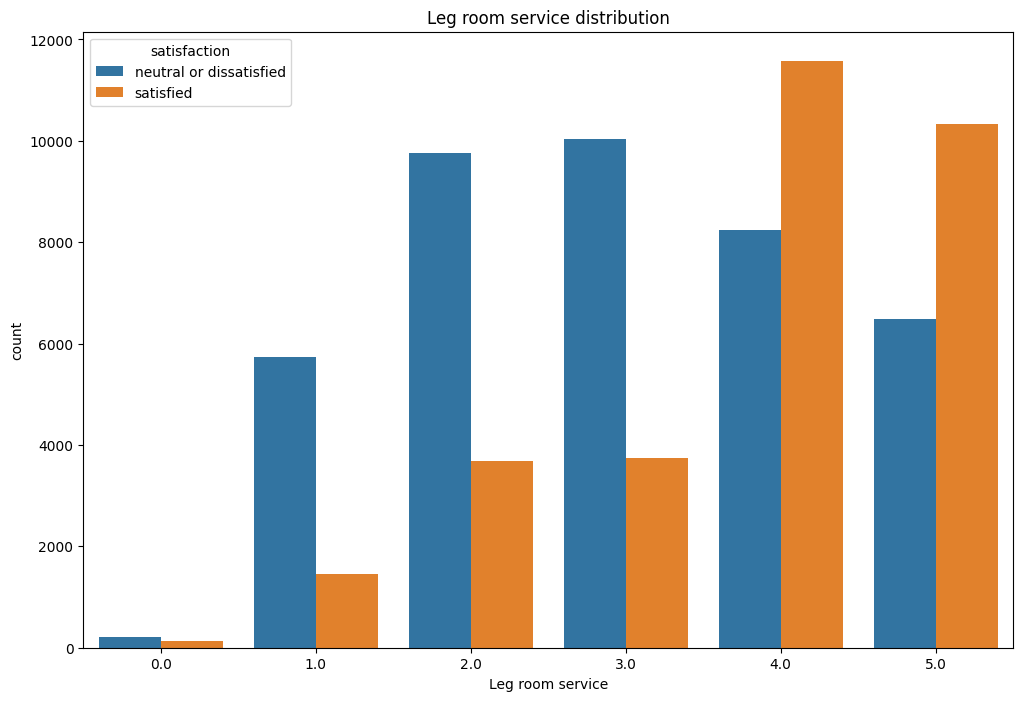

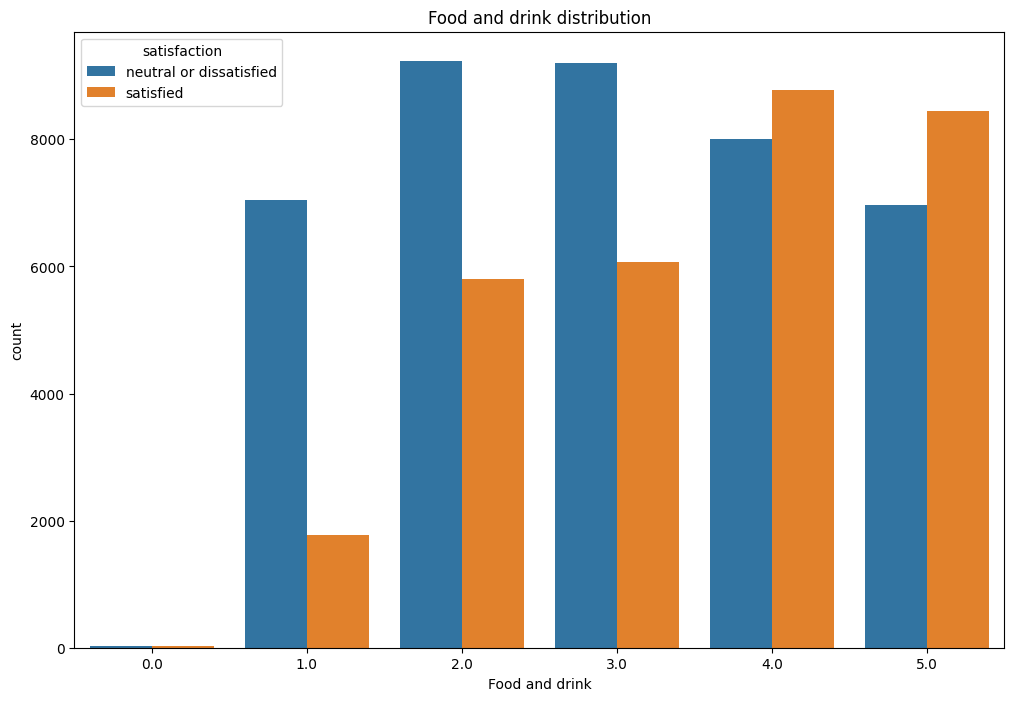

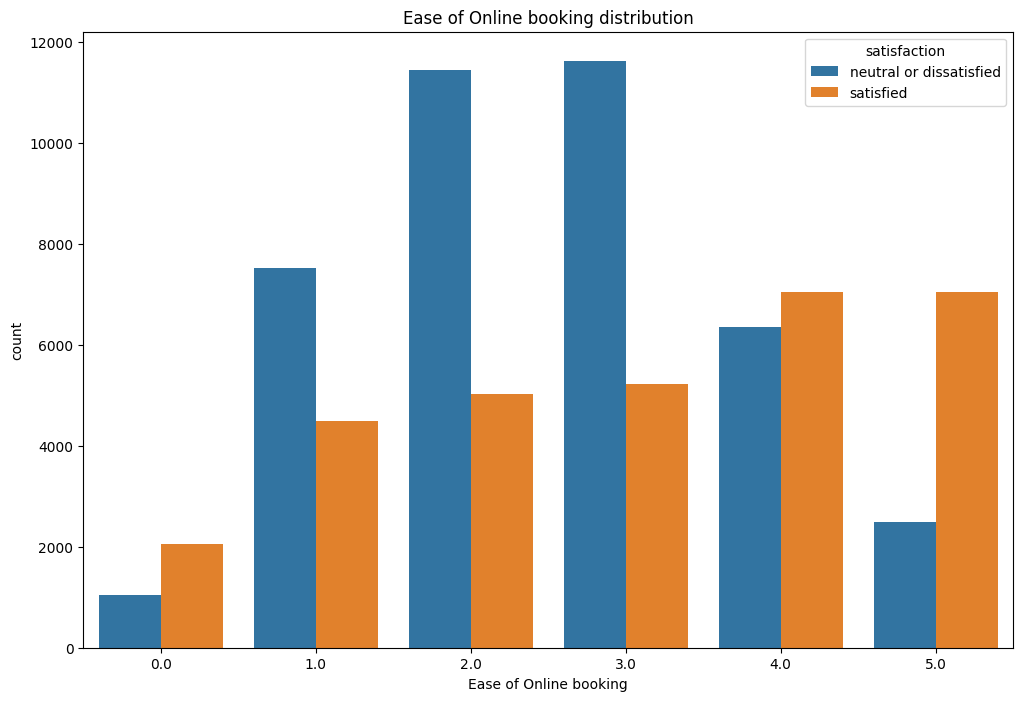

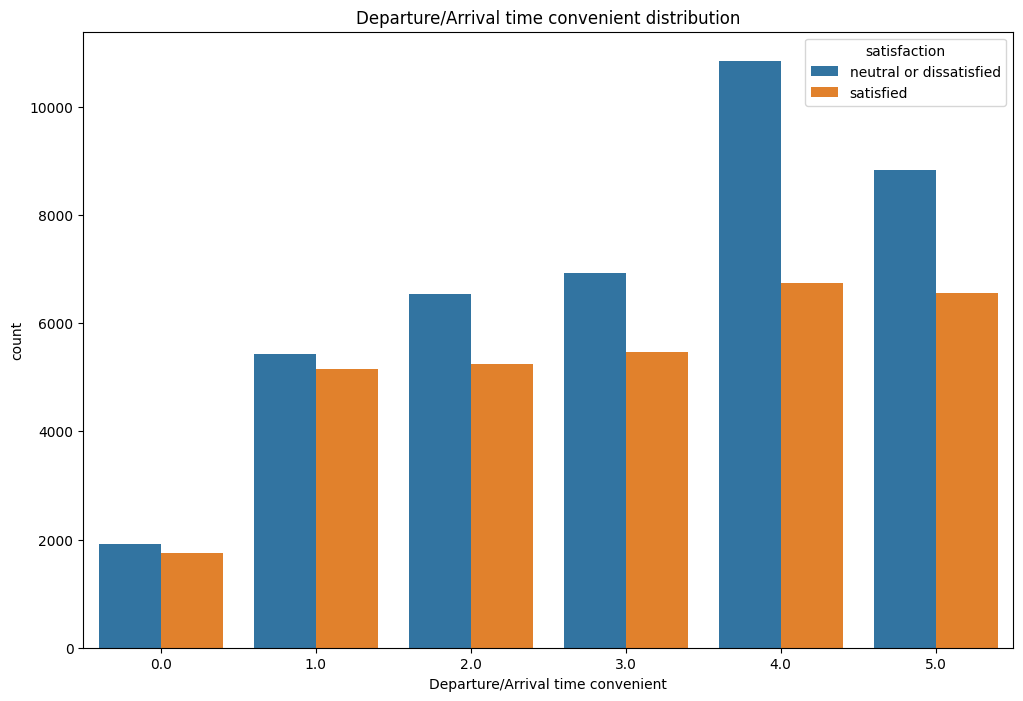

In [ ]:
plot_ordinal(ordinal_cols, X_train, y_train)

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

1) Среди категориальных: 
- Customer Type: (disloyal customer в разы меньше)
- Type of travel ( Personal travel - satisfied) 
- Class

Среди континуальных: 
- Flight Distance distribution
- Departure
- Arrival Delay in Minute

Среди порядковых все признаки имеют неравномерное распределение

2) Видно,что Neutral or dissatisfied преобладает во всех признаках, однако не существенно. Так что дисбаланса классов нет.

3) В признаке 'age'  близко к нормальному распределению
В признаке 'Flight distance'  имеет вид Пуасосновского распределения
В признаках Departuer delay in minutes/Arrival delay in minutes имеют вид Гамма распределения

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [ ]:
X_train['Log Departure Delay'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Log Arrival Delay'] = np.log1p(X_train['Arrival Delay in Minutes'])
X_val['Log Departure Delay'] = np.log1p(X_val['Departure Delay in Minutes'])
X_val['Log Arrival Delay'] = np.log1p(X_val['Arrival Delay in Minutes'])

In [ ]:
X_train.drop(['Departure Delay in Minutes', 'Arrival Delay in Minutes'], axis=1)
X_val.drop(['Departure Delay in Minutes', 'Arrival Delay in Minutes'], axis=1)

gender   age      Customer Type   Type of Travel     class  \
23925     Male  55.0     Loyal Customer  Business travel  Business   
73813     Male  43.0     Loyal Customer  Business travel  Business   
97165     Male  23.0  disloyal Customer  Business travel       Eco   
33992   Female  35.0     Loyal Customer  Personal Travel       Eco   
52032     Male  24.0  disloyal Customer  Business travel       Eco   
...        ...   ...                ...              ...       ...   
108355    Male  47.0     Loyal Customer  Business travel  Business   
123865    Male  46.0     Loyal Customer  Business travel  Business   
42631     Male  32.0     Loyal Customer  Business travel  Business   
121602  Female  65.0     Loyal Customer  Personal Travel       Eco   
80219     Male  35.0     Loyal Customer  Business travel  Business   

        Flight Distance  Inflight wifi service  \
23925            1065.0                    3.0   
73813             733.0                    5.0   
97165             370.0                    2.0   
33992             489.0                    2.0   
52032            1024.0                    4.0   
...                 ...                    ...   
108355           2116.0                    4.0   
123865           2105.0                    3.0   
42631            2305.0                    1.0   
121602            469.0                    3.0   
80219            3023.0                    1.0   

        Departure/Arrival time convenient  Ease of Online booking  \
23925                                 3.0                     3.0   
73813                                 5.0                     1.0   
97165                                 1.0                     2.0   
33992                                 3.0                     2.0   
52032                                 4.0                     4.0   
...                                   ...                     ...   
108355                                4.0                     4.0   
123865                                3.0                     3.0   
42631                                 1.0                     1.0   
121602                                3.0                     3.0   
80219                                 2.0                     2.0   

        Gate location  ...  Seat comfort  Inflight entertainment  \
23925             3.0  ...           1.0                     4.0   
73813             5.0  ...           4.0                     4.0   
97165             3.0  ...           2.0                     2.0   
33992             3.0  ...           3.0                     5.0   
52032             3.0  ...           5.0                     5.0   
...               ...  ...           ...                     ...   
108355            4.0  ...           5.0                     4.0   
123865            3.0  ...           4.0                     3.0   
42631             1.0  ...           4.0                     4.0   
121602            3.0  ...           3.0                     5.0   
80219             2.0  ...           3.0                     1.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
23925                4.0               4.0               4.0              2.0   
73813                4.0               4.0               4.0              4.0   
97165                4.0               4.0               3.0              1.0   
33992                5.0               5.0               1.0              4.0   
52032                2.0               2.0               3.0              1.0   
...                  ...               ...               ...              ...   
108355               4.0               4.0               4.0              5.0   
123865               3.0               2.0               3.0              3.0   
42631                5.0               3.0               4.0              3.0   
121602               5.0               3.0               5.0              3.0   
80219                1.0     

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Log Departure Delay' , 'Log Arrival Delay']

In [ ]:
def plot_continuous(cols, df, y):
  for k in cols:
    plt.figure(figsize=(12,8))
    plt.subplot(1, 2, 1)
    plt.title(k + ' distribution')
    ax.set_title(k)
    ax.legend()
    sns.kdeplot(x=df[k], hue=y, common_norm=False, bw_method=0.15)
    plt.subplot(1, 2, 2)
    plt.title(k + ' boxplot by target')
    ax.set_title(k)
    ax.legend()
    sns.boxplot(x=df[k], y=y)
    plt.show()

Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

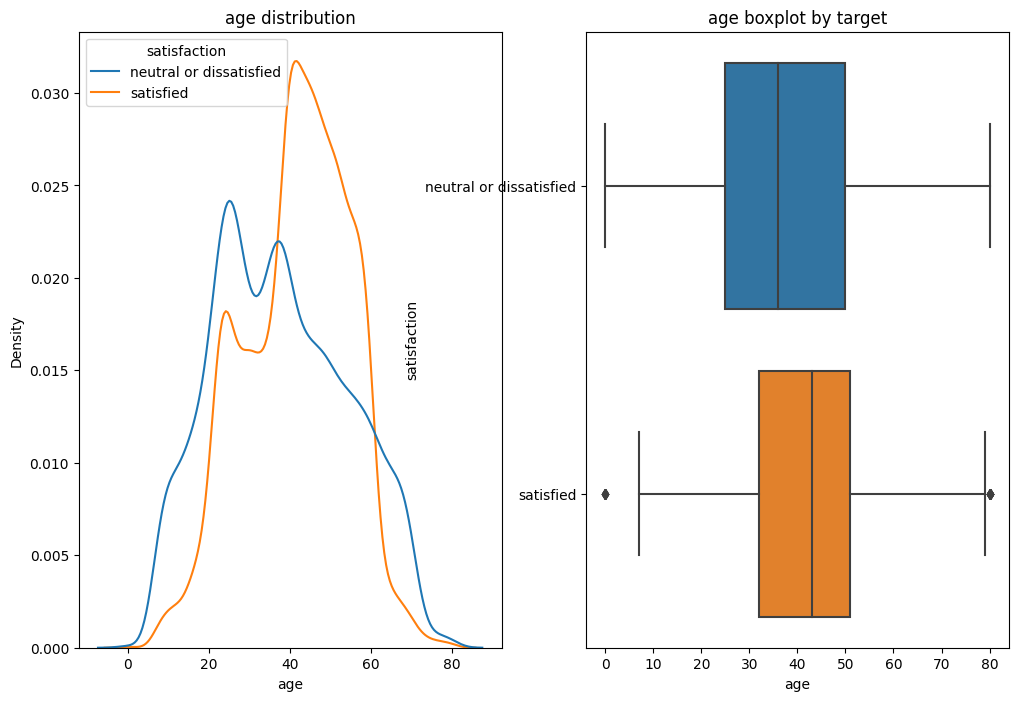

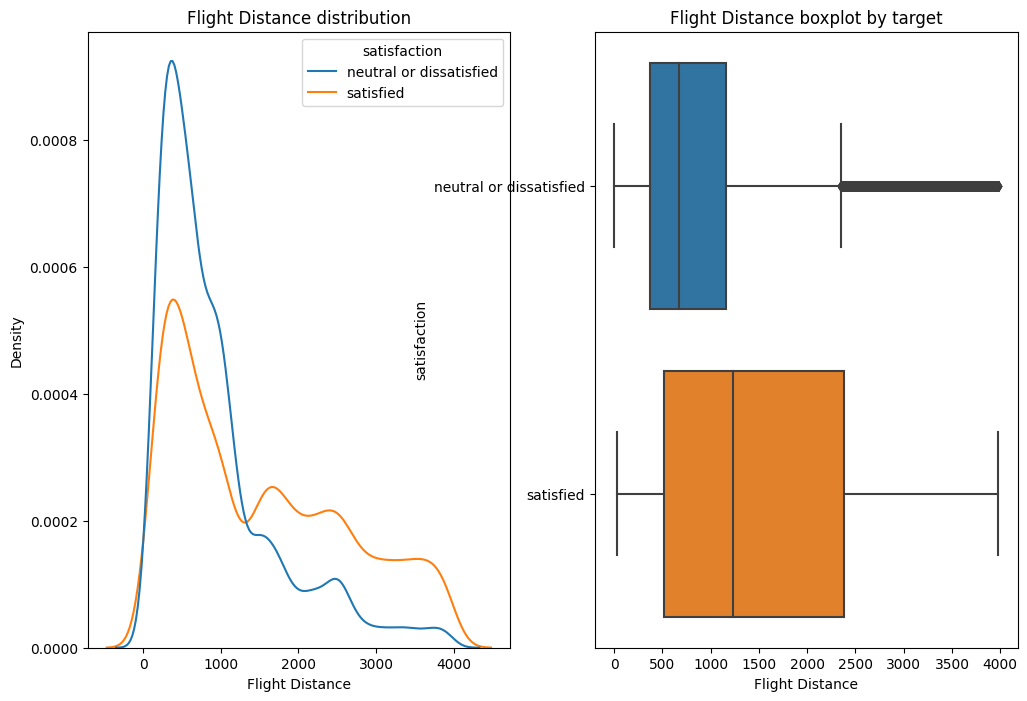

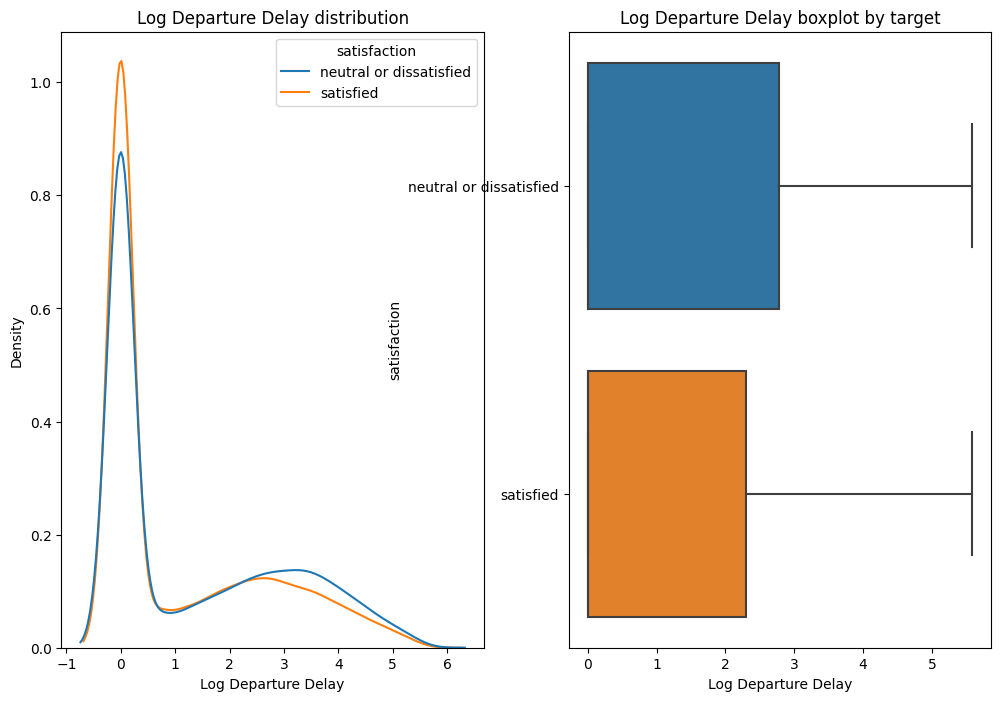

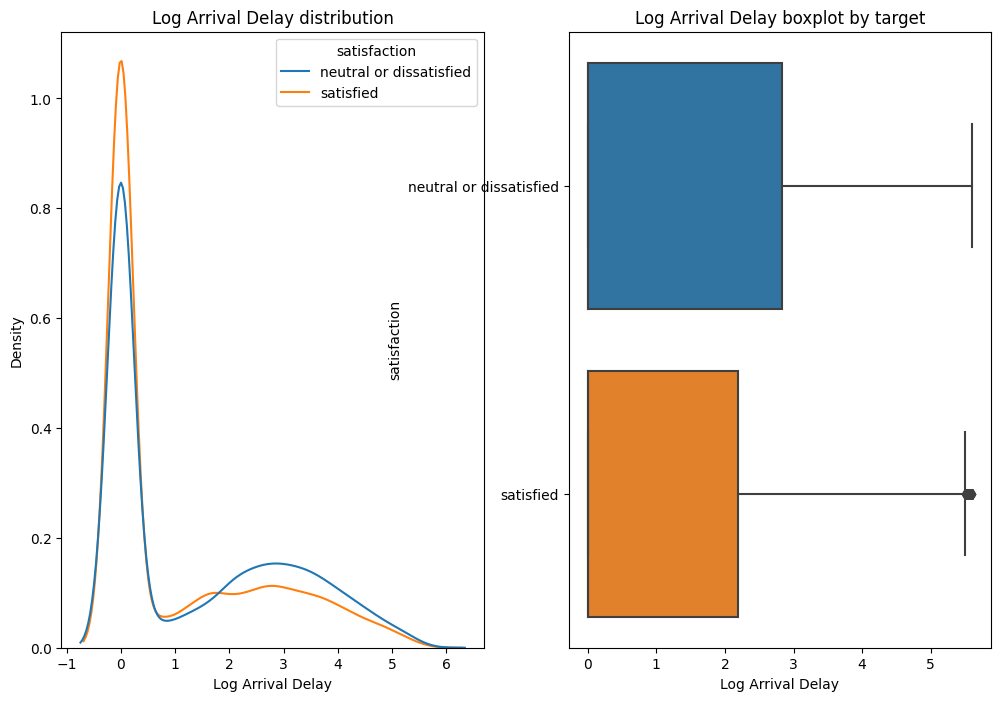

In [ ]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [ ]:
y_train.unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

In [ ]:
y_train_0 = y_train

In [ ]:
y_train = y_train.replace('satisfied', 1)
y_train = y_train.replace('neutral or dissatisfied', 0)


In [ ]:
y_val = y_val.replace('satisfied', 1)
y_val = y_val.replace('neutral or dissatisfied', 0)

In [ ]:
y_train.unique()

array([0, 1])

In [ ]:
y_val.unique()

array([1, 0])

In [ ]:
y_train

32590    0
66281    1
90429    0
68777    0
54906    1
        ..
7838     0
68526    0
96003    0
1103     1
19728    0
Name: satisfaction, Length: 71395, dtype: int64

In [ ]:
y_val

23925     1
73813     1
97165     0
33992     0
52032     0
         ..
108355    1
123865    1
42631     1
121602    0
80219     0
Name: satisfaction, Length: 30588, dtype: int64

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [ ]:
X_tr_con = X_train[['age', 'Flight Distance', 'Log Departure Delay', 'Log Arrival Delay']]

In [ ]:
X_train_pp = X_train
X_train_pp['satisfaction'] = y_train_0

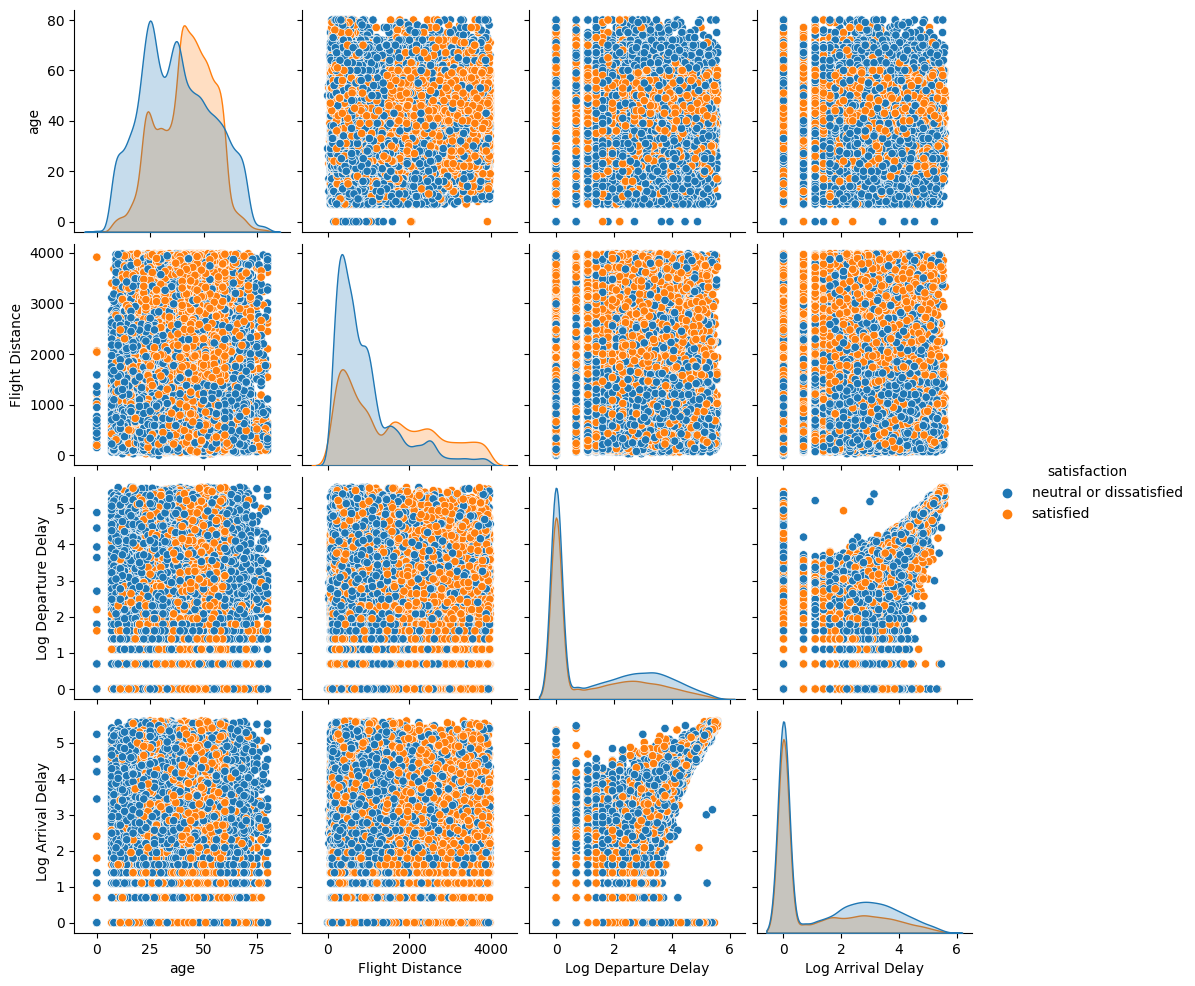

In [ ]:
sns.pairplot( data=X_train_pp, x_vars=['age', 'Flight Distance', 'Log Departure Delay', 'Log Arrival Delay'],
             y_vars=['age', 'Flight Distance', 'Log Departure Delay', 'Log Arrival Delay'],
            diag_kind="kde", hue='satisfaction')

In [ ]:
X_train_pp['satisfaction'] = X_train_pp['satisfaction'].replace('satisfied', 1)
X_train_pp['satisfaction'] = X_train_pp['satisfaction'].replace('neutral or dissatisfied', 0)

<font color='#9933CC'>Отобразите тепловую карту корреляций признаков и таргета</font>

<Axes: >

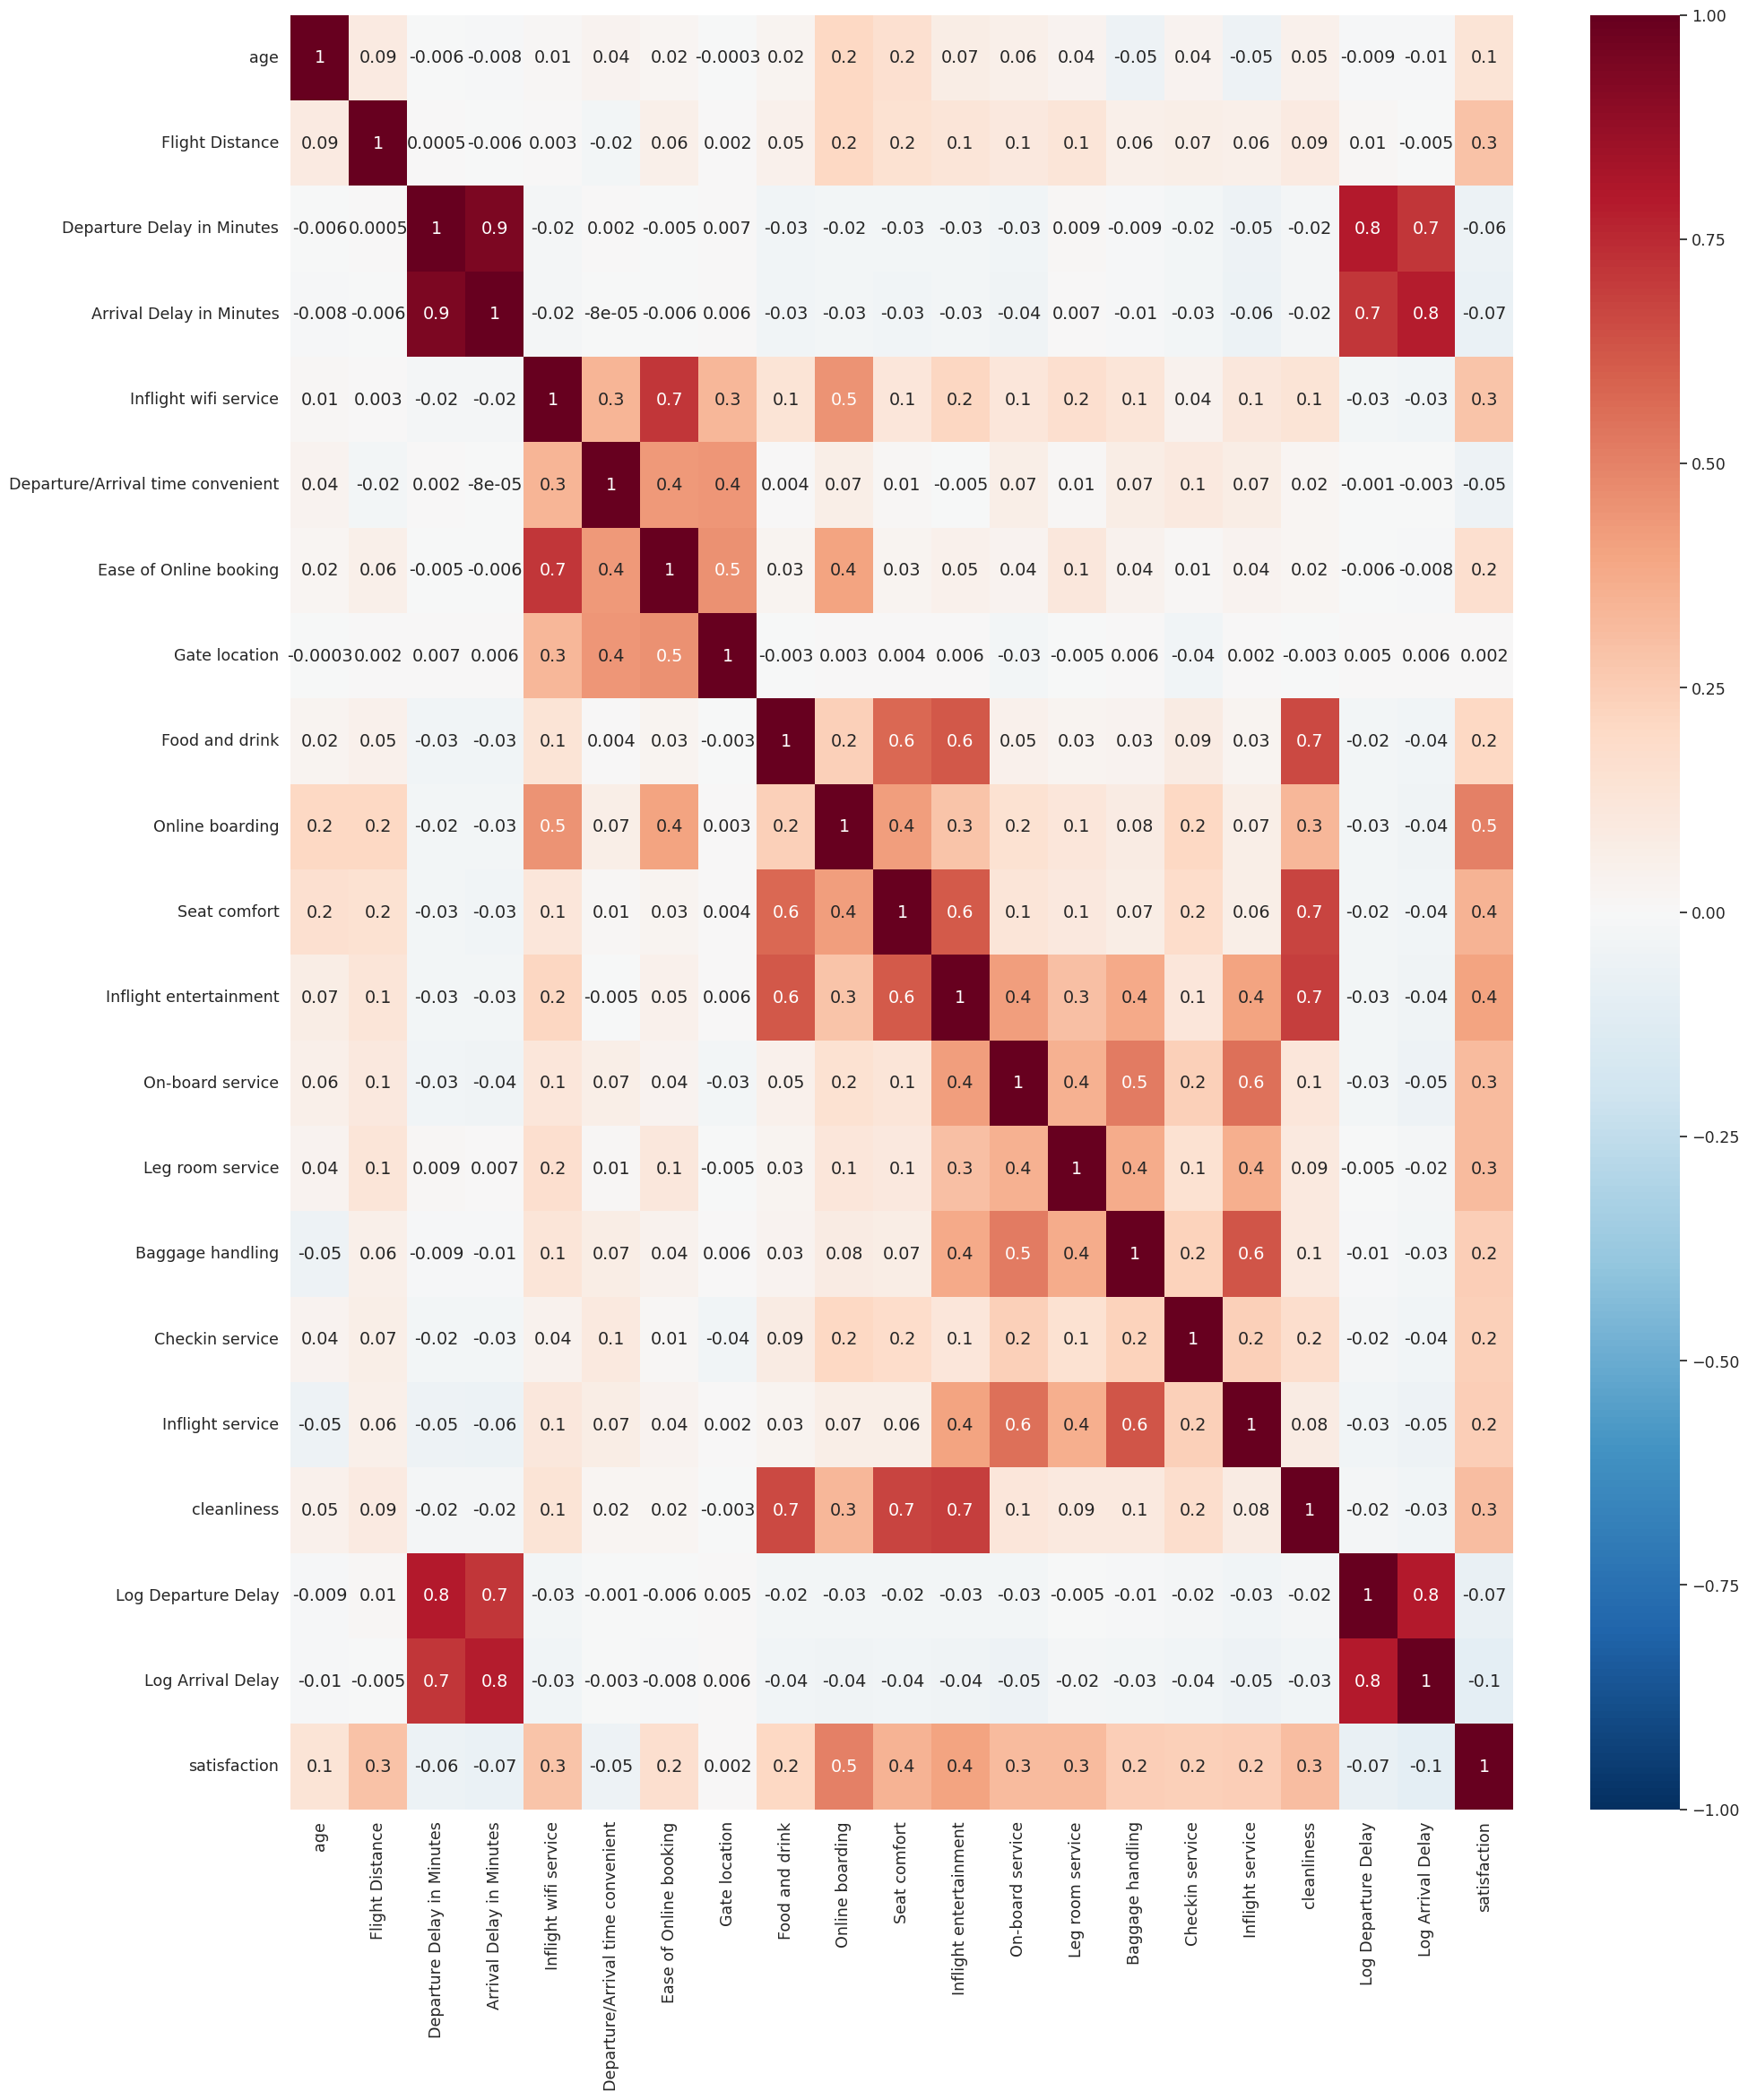

In [ ]:
sns.set(font_scale=1.15)
plt.figure(figsize=(22,26))
sns.heatmap(
    X_train_pp.corr(),        
    cmap='RdBu_r',
    annot=True, 
    vmin=-1, vmax=1,fmt='.1g')


Видим, что с целевой переменной ни у одного признака нет выраженной корреляции. Самая большая у 'Online boarding'. Дальше проверим, информативен ли этот признак для предсказания удовлетворенности

<img src='https://mobimg.b-cdn.net/v3/fetch/fe/fe22186dba2df35f07573604aa8a0e63.jpeg?w=1470&r=0.5625' height=500px>

# Decision Tree (1.75 балла)

(0.25 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [ ]:
X_train.drop('satisfaction', axis=1, inplace=True)

In [ ]:
X_train_ri = X_train.reset_index(drop=True)
X_val_ri = X_val.reset_index(drop=True)

In [ ]:
X_train_cat = X_train_ri[['gender', 'Customer Type', 'Type of Travel', 'class']]
X_val_cat = X_val_ri[['gender', 'Customer Type', 'Type of Travel', 'class']]

In [ ]:
encoder = OneHotEncoder(drop=None)
encoder_X_train = encoder.fit_transform(X_train_cat).toarray()
encoder_X_train = pd.DataFrame(encoder_X_train, columns=encoder.get_feature_names_out(['gender', 'Customer Type', 'Type of Travel', 'class']))
X_train_ohe = pd.concat([X_train_ri, encoder_X_train], axis=1)

In [ ]:
enc = OneHotEncoder(drop=None)
encoder_X_val = enc.fit_transform(X_val_cat).toarray()
encoder_X_val = pd.DataFrame(encoder_X_val, columns=enc.get_feature_names_out(['gender', 'Customer Type', 'Type of Travel', 'class']))
X_val_ohe = pd.concat([X_val_ri, encoder_X_val], axis=1)

In [ ]:
X_train_ohe = X_train_ohe.drop(['gender', 'Customer Type', 'Type of Travel', 'class'], axis=1)  
y_train = y_train.reset_index(drop=True)

In [ ]:
X_val_ohe = X_val_ohe.drop(['gender', 'Customer Type', 'Type of Travel', 'class'], axis=1)  
y_val = y_val.reset_index(drop=True)

In [ ]:
X_train_ohe

age  Flight Distance  Departure Delay in Minutes  \
0      29.0            785.0                         0.0   
1      45.0           3269.0                         0.0   
2       8.0           1431.0                         0.0   
3      48.0            602.0                         0.0   
4      25.0            651.0                         0.0   
...     ...              ...                         ...   
71390  25.0            337.0                         0.0   
71391  77.0           1448.0                         0.0   
71392  31.0            304.0                        21.0   
71393  45.0            661.0                         0.0   
71394  55.0           1359.0                         0.0   

       Arrival Delay in Minutes  Inflight wifi service  \
0                           0.0                    2.0   
1                           0.0                    0.0   
2                           0.0                    3.0   
3                           0.0                    4.0   
4                           0.0                    5.0   
...                         ...                    ...   
71390                       0.0                    1.0   
71391                       0.0                    2.0   
71392                      12.0                    4.0   
71393                       0.0                    4.0   
71394                       0.0                    3.0   

       Departure/Arrival time convenient  Ease of Online booking  \
0                                    2.0                     2.0   
1                                    0.0                     0.0   
2                                    1.0                     3.0   
3                                    5.0                     4.0   
4                                    0.0                     5.0   
...                                  ...                     ...   
71390                                4.0                     1.0   
71391                                5.0                     5.0   
71392                                4.0                     4.0   
71393                                1.0                     4.0   
71394                                3.0                     3.0   

       Gate location  Food and drink  Online boarding  ...  Log Arrival Delay  \
0                4.0             4.0              2.0  ...           0.000000   
1                3.0             2.0              2.0  ...           0.000000   
2                2.0             5.0              3.0  ...           0.000000   
3                3.0             2.0              5.0  ...           0.000000   
4                2.0             2.0              5.0  ...           0.000000   
...              ...             ...              ...  ...                ...   
71390            4.0             4.0              1.0  ...           0.000000   
71391            5.0             2.0              2.0  ...           0.000000   
71392            1.0             1.0              4.0  ...           2.564949   
71393            4.0             2.0              4.0  ...           0.000000   
71394            3.0             3.0              3.0  ...           0.000000   

       gender_Female  gender_Male  Customer Type_Loyal Customer  \
0                1.0          0.0                           0.0   
1                1.0          0.0                           1.0   
2                0.0          1.0                           1.0   
3                1.0          0.0                           1.0   
4                1.0          0.0                           0.0   
...              ...          ...                           ...   
71390            1.0          0.0                           1.0   
71391            0.0          1.0                           1.0   
71392            1.0          0.0                           1.0   
71393            0.0          1.0                           1.0   
71394            1.0          0.0                           0.0

In [ ]:
X_val_ohe

age  Flight Distance  Departure Delay in Minutes  \
0      55.0           1065.0                         0.0   
1      43.0            733.0                         0.0   
2      23.0            370.0                        52.0   
3      35.0            489.0                         6.0   
4      24.0           1024.0                         5.0   
...     ...              ...                         ...   
30583  47.0           2116.0                        24.0   
30584  46.0           2105.0                         0.0   
30585  32.0           2305.0                         0.0   
30586  65.0            469.0                         0.0   
30587  35.0           3023.0                         0.0   

       Arrival Delay in Minutes  Inflight wifi service  \
0                           0.0                    3.0   
1                           0.0                    5.0   
2                          47.0                    2.0   
3                          12.0                    2.0   
4                           6.0                    4.0   
...                         ...                    ...   
30583                      12.0                    4.0   
30584                       6.0                    3.0   
30585                       0.0                    1.0   
30586                       0.0                    3.0   
30587                       0.0                    1.0   

       Departure/Arrival time convenient  Ease of Online booking  \
0                                    3.0                     3.0   
1                                    5.0                     1.0   
2                                    1.0                     2.0   
3                                    3.0                     2.0   
4                                    4.0                     4.0   
...                                  ...                     ...   
30583                                4.0                     4.0   
30584                                3.0                     3.0   
30585                                1.0                     1.0   
30586                                3.0                     3.0   
30587                                2.0                     2.0   

       Gate location  Food and drink  Online boarding  ...  Log Arrival Delay  \
0                3.0             1.0              4.0  ...           0.000000   
1                5.0             4.0              4.0  ...           0.000000   
2                3.0             2.0              2.0  ...           3.871201   
3                3.0             5.0              2.0  ...           2.564949   
4                3.0             5.0              4.0  ...           1.945910   
...              ...             ...              ...  ...                ...   
30583            4.0             2.0              4.0  ...           2.564949   
30584            3.0             2.0              4.0  ...           1.945910   
30585            1.0             4.0              4.0  ...           0.000000   
30586            3.0             4.0              3.0  ...           0.000000   
30587            2.0             3.0              2.0  ...           0.000000   

       gender_Female  gender_Male  Customer Type_Loyal Customer  \
0                0.0          1.0                           1.0   
1                0.0          1.0                           1.0   
2                0.0          1.0                           0.0   
3                1.0          0.0                           1.0   
4                0.0          1.0                           0.0   
...              ...          ...                           ...   
30583            0.0          1.0                           1.0   
30584            0.0          1.0                           1.0   
30585            0.0          1.0                           1.0   
30586            1.0          0.0                           1.0   
30587            0.0          1.0                           1.0

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для теста

In [ ]:
dt = DecisionTreeClassifier(random_state=43)
dt.fit(X_train_ohe, y_train)

DecisionTreeClassifier(random_state=43)

In [ ]:
accuracy_score(dt.predict(X_val_ohe), y_val)

0.9436707205440041

## Деревья решений. Теоретическая вставка

(0.25 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [ ]:
error_dt, bias_dt, var_dt = bias_variance_decomp(dt, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, loss='0-1_loss' , random_seed=123) 

In [ ]:
error_dt, bias_dt, var_dt

(0.0594854191186086, 0.03929645612658559, 0.04408199293840722)

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

In [ ]:
def plot_feature_importance(importance,names,model_type):

  feature_importance = np.array(importance)
  feature_names = np.array(names)

  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  plt.figure(figsize=(10,8))
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('score_DT')
  plt.ylabel('FEATURE NAMES')


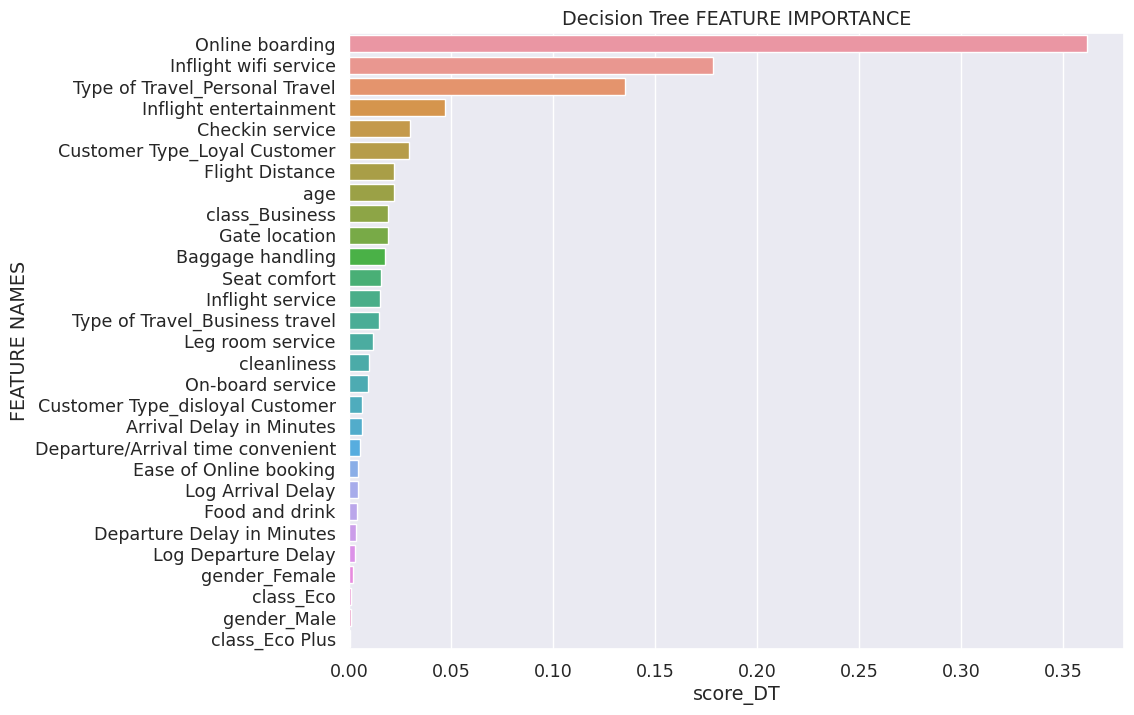

In [ ]:
plot_feature_importance(dt.feature_importances_,X_train_ohe.columns,'Decision Tree')

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

- Online boarding
- Inflight wifi service
- Type of Travel - Business travel

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

Глубина дерева:

In [ ]:
dt.get_depth()

33

Количество листьев:

In [ ]:
dt.get_n_leaves()

2799

<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [ ]:
dt = DecisionTreeClassifier(random_state=43, max_depth=5)
dt.fit(X_train_ohe[['Inflight wifi service', 'Online boarding']], y_train)


DecisionTreeClassifier(max_depth=5, random_state=43)

In [ ]:
accuracy_score(dt.predict(X_val_ohe[['Inflight wifi service', 'Online boarding']]), y_val)

0.824833267948215

На 0.12 упало качество в accuracy score

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

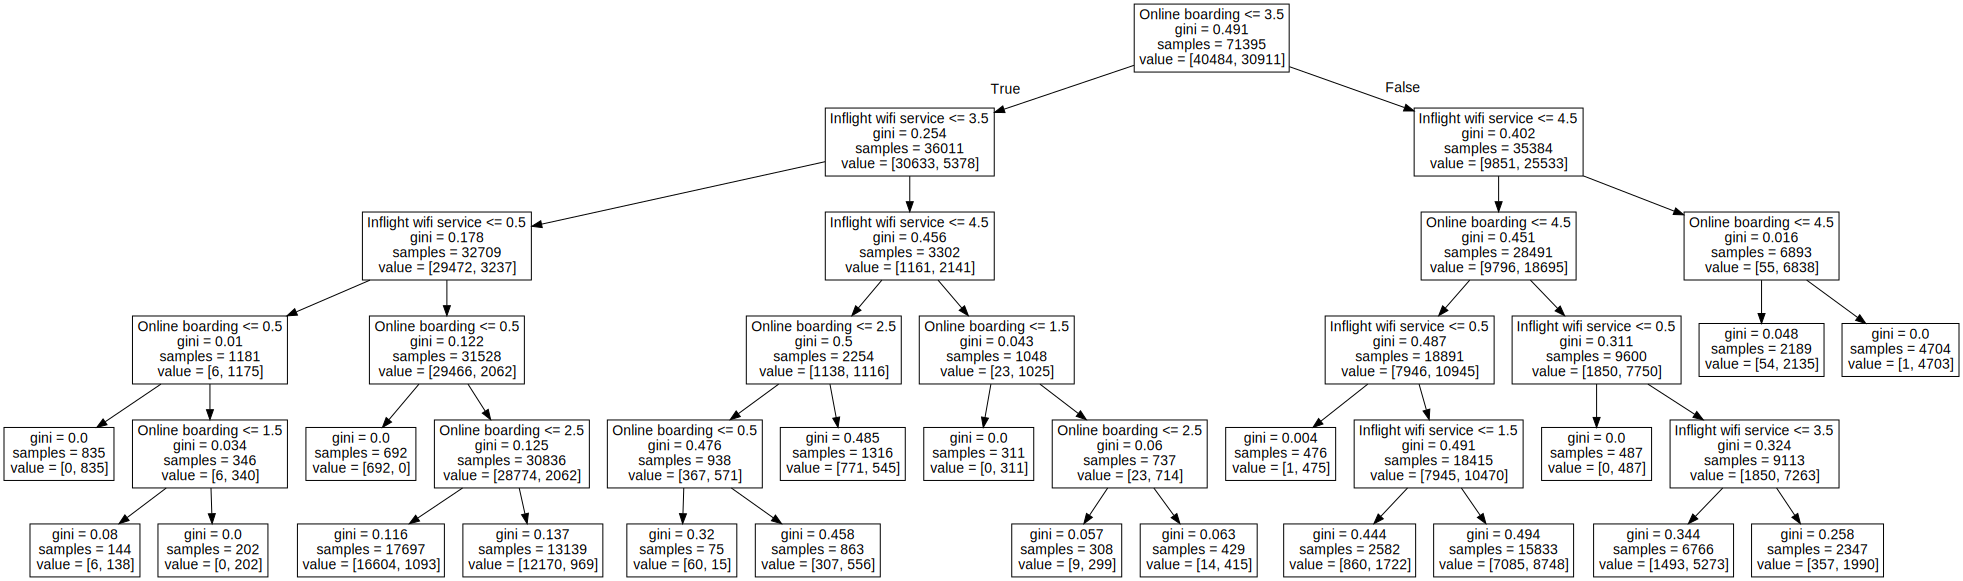

In [ ]:
import graphviz
from sklearn import tree 
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=dt.feature_names_in_,
                                filled=False)
graph = graphviz.Source(dot_data, format="png") 
graph

- Предикаты в нем кратные 0.5, так как берутся как усредненные отстортированные значения соседних  по величине предикатов

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договореённости) признаков</font>

In [ ]:
dt = DecisionTreeClassifier(random_state=43, max_depth=5)
dt.fit(X_train_ohe[['Flight Distance', 'age']], y_train)



DecisionTreeClassifier(max_depth=5, random_state=43)

In [ ]:
accuracy_score(dt.predict(X_val_ohe[['Flight Distance', 'age']]), y_val)

0.6836667974369034

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

In [ ]:
from sklearn import tree

[Text(0.5, 0.9166666666666666, 'Flight Distance <= 1499.5\ngini = 0.491\nsamples = 100.0%\nvalue = [0.567, 0.433]'),
 Text(0.25, 0.75, 'age <= 37.5\ngini = 0.447\nsamples = 69.9%\nvalue = [0.663, 0.337]'),
 Text(0.125, 0.5833333333333334, 'age <= 19.5\ngini = 0.394\nsamples = 33.9%\nvalue = [0.731, 0.269]'),
 Text(0.0625, 0.4166666666666667, 'age <= 16.5\ngini = 0.265\nsamples = 7.8%\nvalue = [0.843, 0.157]'),
 Text(0.03125, 0.25, 'Flight Distance <= 489.5\ngini = 0.237\nsamples = 5.6%\nvalue = [0.862, 0.138]'),
 Text(0.015625, 0.08333333333333333, 'gini = 0.195\nsamples = 2.1%\nvalue = [0.891, 0.109]'),
 Text(0.046875, 0.08333333333333333, 'gini = 0.262\nsamples = 3.5%\nvalue = [0.845, 0.155]'),
 Text(0.09375, 0.25, 'Flight Distance <= 505.0\ngini = 0.327\nsamples = 2.2%\nvalue = [0.794, 0.206]'),
 Text(0.078125, 0.08333333333333333, 'gini = 0.249\nsamples = 1.0%\nvalue = [0.854, 0.146]'),
 Text(0.109375, 0.08333333333333333, 'gini = 0.376\nsamples = 1.3%\nvalue = [0.749, 0.251]'),
 T

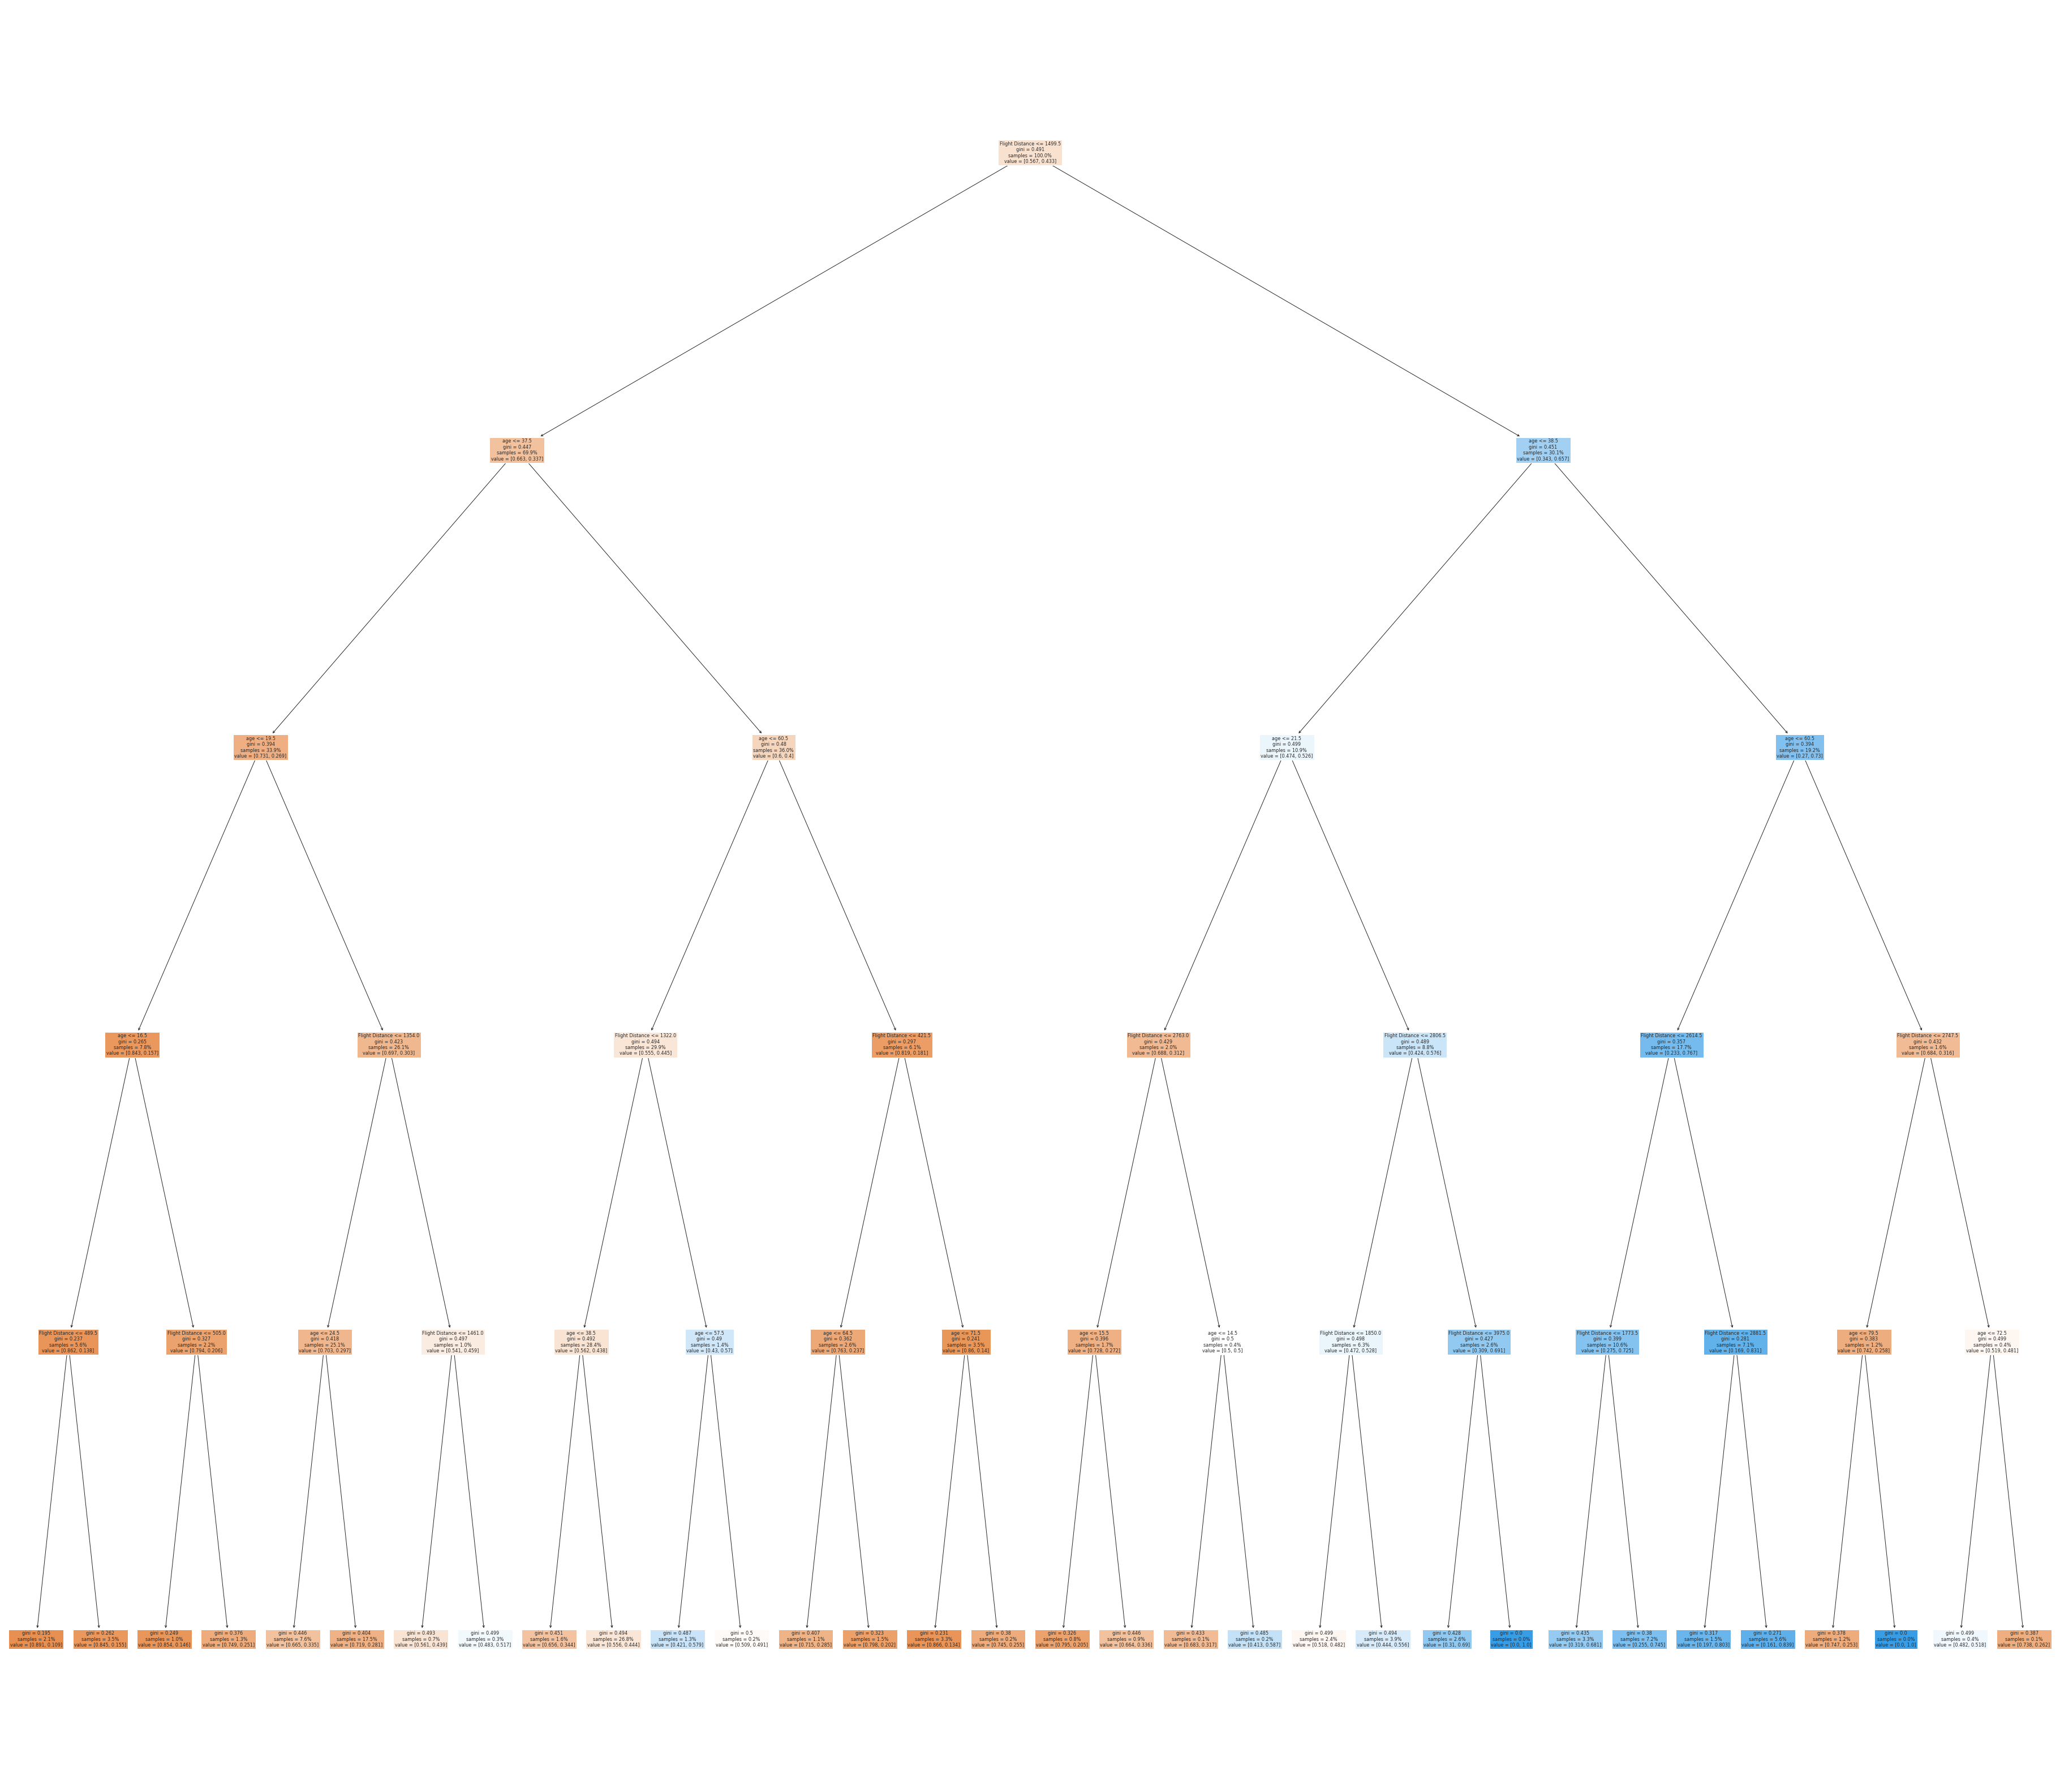

In [ ]:
plt.figure(figsize=(65, 58))
tree.plot_tree(dt, filled=True, proportion=True, feature_names=dt.feature_names_in_)

Дерево получилось симметричным. Это хорошо, потому что такое дерево быстрее обучается, за счет того, что оно использует повторяющиеся вопросы, вследствие чего дерево можно представить в матрицу, которую быстрее обучать, чем несимметричное дерево. 

(0.25 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

In [ ]:
from mlxtend.plotting import plot_decision_regions

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


<Axes: >

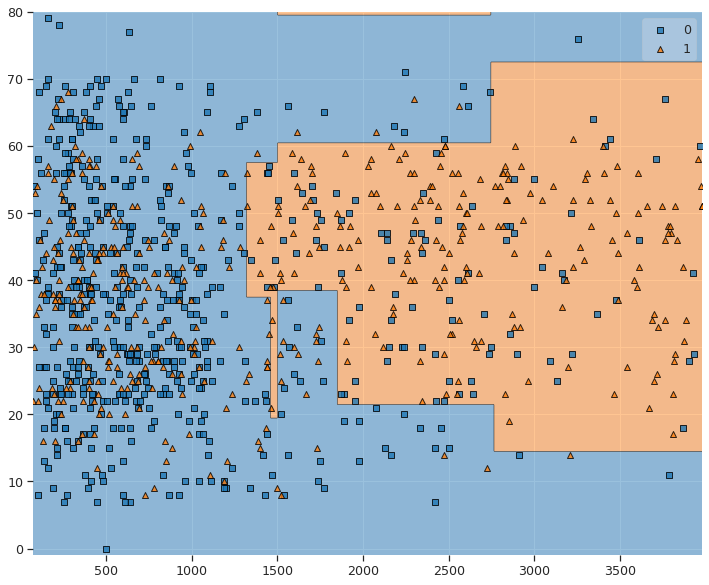

In [ ]:
fig = plt.figure(figsize=(12,10))
plot_decision_regions(clf=dt, X=np.array(X_train_ohe[['Flight Distance', 'age']].iloc[:1000, :]), y=np.array(y_train[:1000]))

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


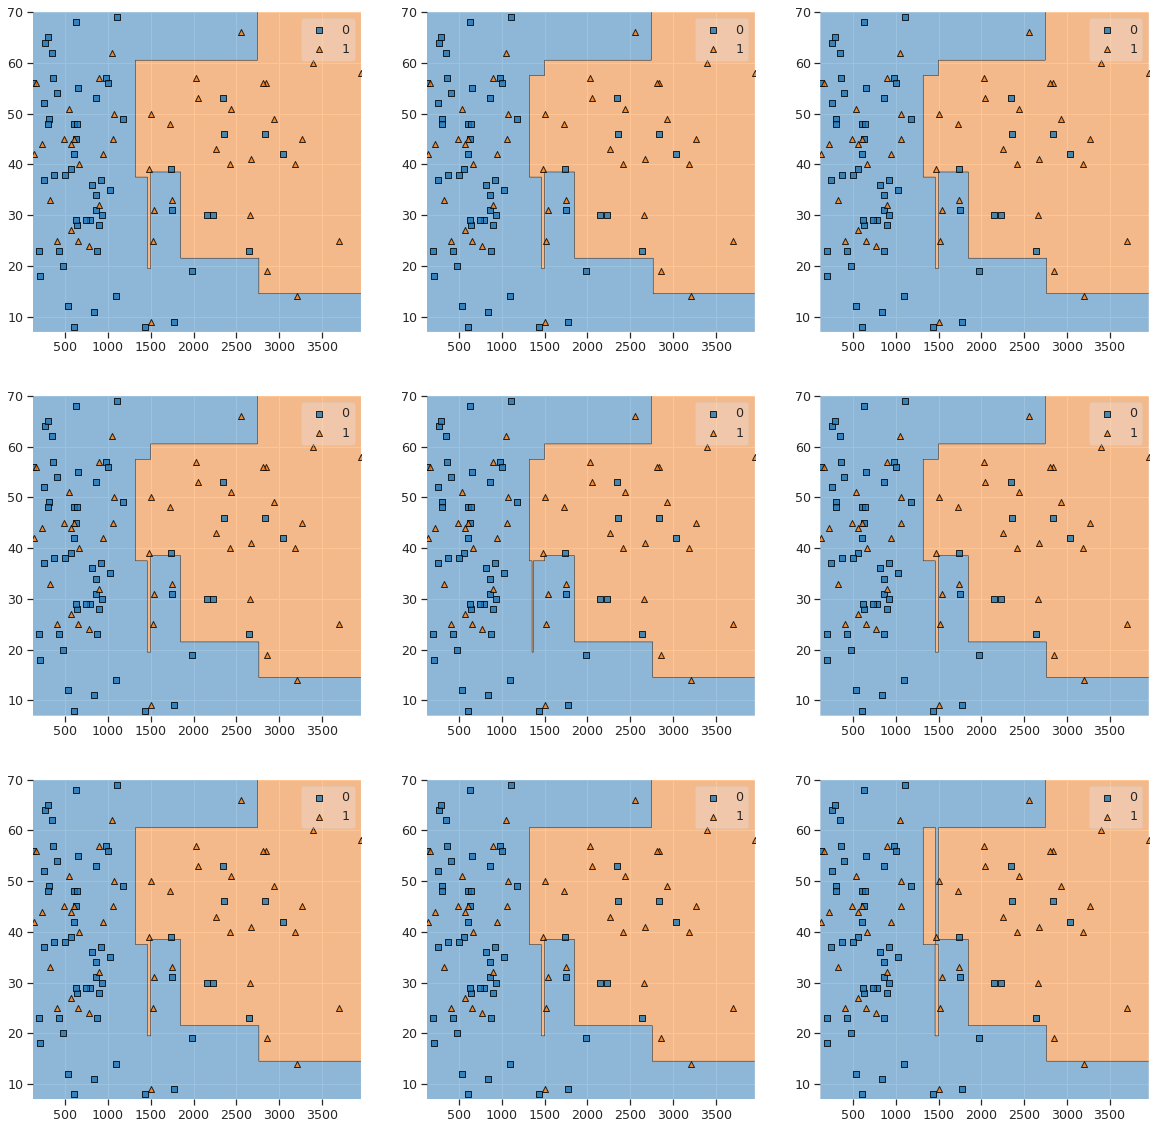

In [ ]:
# change X_train_example to your equivalent

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_ohe[['Flight Distance', 'age']].index, size=X_train_ohe[['Flight Distance', 'age']].shape[0] - 1000, replace=False)

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_ohe[['Flight Distance', 'age']].loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_ohe[['Flight Distance', 'age']].iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [ ]:
# change X_train_enc into your ohe-encoded train set

%%time 
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_ohe, y_train)
    y_predicted_train = DT.predict(X_train_ohe)
    y_predicted_val = DT.predict(X_val_ohe)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 6.85 s, sys: 20.8 ms, total: 6.87 s
Wall time: 6.95 s


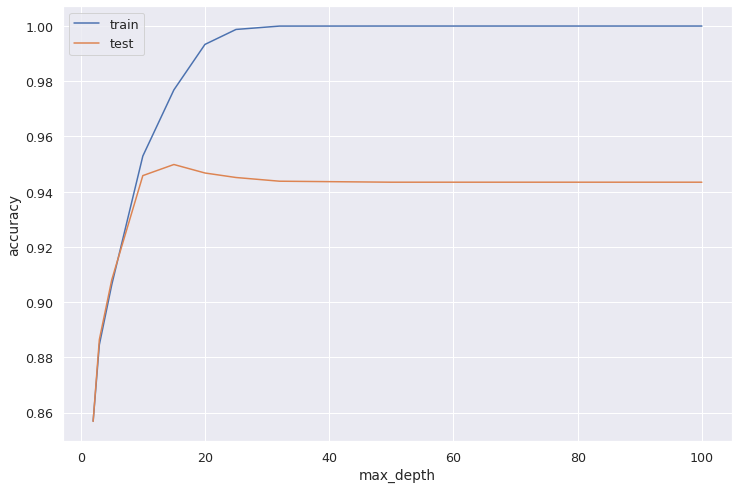

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.25 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font>. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [ ]:
dt = DecisionTreeClassifier(random_state=43)

In [ ]:
tree_params = {'max_depth': range(10,100,10),
'min_samples_leaf': range(50,1000,50)}

In [ ]:
tree_grid = GridSearchCV(dt, tree_params, cv=5, scoring='accuracy')

In [ ]:
tree_grid.fit(X_train_ohe, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=43),
             param_grid={'max_depth': range(10, 100, 10),
                         'min_samples_leaf': range(50, 1000, 50)},
             scoring='accuracy')

In [ ]:
tree_grid.best_params_

{'max_depth': 20, 'min_samples_leaf': 50}

In [ ]:
accuracy_score(tree_grid.predict(X_val_ohe), y_val)

0.947593827644828

In [ ]:
dt = DecisionTreeClassifier(random_state=43,max_depth = 20, min_samples_leaf=50)
dt.fit(X_train_ohe, y_train)
accuracy_score(dt.predict(X_val_ohe), y_val)

0.947593827644828

Видим, что удалось улучшить качество модели в третьем знаке по accuracy score.

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
pickle.dump(dt, open('DT.pkl', 'wb'))

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# Random Forest (2 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [ ]:
rf = RandomForestClassifier(random_state=43)

In [ ]:
rf.fit(X_train_ohe, y_train)

RandomForestClassifier(random_state=43)

In [ ]:
accuracy_score(rf.predict(X_val_ohe), y_val)

0.9618804760036616

(0.25 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.calibration import CalibrationDisplay

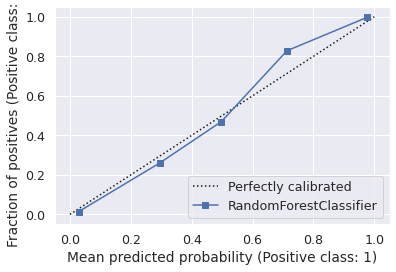

In [ ]:
disp = CalibrationDisplay.from_estimator(rf, X_val_ohe, y_val)

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

 - Случайные леса имеют трудности с прогнозами, близкими к 0 или 1 из-за дисперсии в базовых моделях, поэтому кривые вероятности имеют вид сигмоиды, то есть до 0.5 недооценивают вероятности, а после 0.5 переоценивают.


<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

In [ ]:
lr = LogisticRegression(random_state=43)
lr.fit(X_train_ohe, y_train)


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(random_state=43)

In [ ]:
accuracy_score(lr.predict(X_val_ohe), y_val)

0.8211063162024324

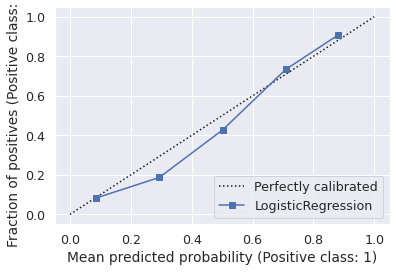

In [ ]:
displ_logreg = CalibrationDisplay.from_estimator(lr, X_val_ohe, y_val)

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

Запишем логлосс:
$$ L(y,p\hat{})= p\cdot ln(p)+(1-p)\cdot ln(1-p\hat{}) -> min\, p\hat{} $$ 

Продифференцируем по p с крышечкой - это вероятность (с оценкой) , которую выдает модель:

$$\frac{\partial (p\cdot ln(p)+(1-p)\cdot ln(1-p\hat{})) }{\partial p\hat{}} = \frac{p}{p\hat{}} + \frac{1-p}{1-p\hat{}} $$

$$ p-p\cdot p\hat{} = p\hat{}-p\cdot \hat{}p\\ $$

$$ p=p\hat{} $$

Видим, что вероятность с оценкой равна реальной вероятности, отсюда следует, что логистическая функция потерь корректно прогнозирует вероятности.

(0.25 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

In [ ]:
rf_isotonic = CalibratedClassifierCV(rf, method='isotonic')
rf_isotonic.fit(X_train_ohe, y_train)
predictions_isotonic = rf_isotonic.predict_proba(X_val_ohe)

In [ ]:
rf_logreg = CalibratedClassifierCV(rf, method='sigmoid')
rf_logreg.fit(X_train_ohe, y_train)
predictions_logreg = rf_logreg.predict_proba(X_val_ohe)

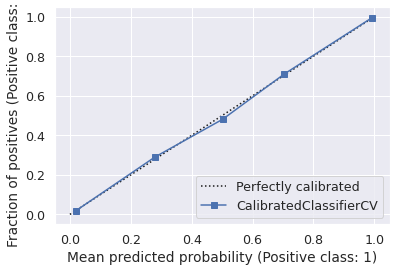

In [ ]:
displ_isotonic = CalibrationDisplay.from_estimator(rf_isotonic, X_val_ohe, y_val)

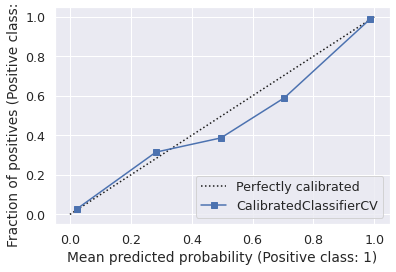

In [ ]:
displ_logreg = CalibrationDisplay.from_estimator(rf_logreg, X_val_ohe, y_val)

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

- Гистограммная калибровка.Пусть наша модель (бинарной классификации) для каждого объекта выдаёт некоторое число q. Мы разбиваем отрезок на бины (одинаковой ширины или равномощные) и хотим на каждом из них прогнозировать всегда одну и ту же вероятность, если это число q принадлежит нашему бину.Вероятности подбираются так, чтобы они как можно лучше приближали средние метки классов на соответствующих бинах.

 https://academy.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti


- *Деревья калибровки вероятностей* строятся с использованием алгоритма, аналогичного деревьям логистических моделей, за исключением того, что они используют два входных набора данных — исходные обучающие данные и связанные выходные оценки из базового классификатора, которые мы хотим откалибровать, такие как вероятностные оценки. Исходные обучающие данные — часть  входных данных — используются для построения базовой древовидной структуры с использованием алгоритма, а выходные оценки входных данных — используются для обучения логистических моделей с помощью LogitBoost. Таким образом, дерево калибровки вероятности выполняет калибровку Платта в различных областях входного пространства, но и использует глобальную модель калибровки Платта, если это дает лучшую оценку.

 https://proceedings.mlr.press/v77/leathart17a/leathart17a.pdf

(0.25 балла) <font color='#9933CC'>Посчитайте разброс и смещение полученной композиции.</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [ ]:
error_rf, bias_rf, var_rf = bias_variance_decomp(rf, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, loss='0-1_loss' , random_seed=123) 



In [ ]:
error_rf, bias_rf, var_rf

(0.0399115666274356, 0.038152216555511966, 0.008916405126193279)

Разброс и смещение отличаются от полученных на decision tree: в частности,    разброс у одного дерева 0.044 против 0.008 у сл. леса, смещение у одного дерева 0.039 против 0.038 у сл. леса. Разброс в теории у случайного леса должен быть меньше, чем у одного дерева, что мы и видим - он получился в разы меньше у случайного леса. Смещение чуть меньше у случайного леса, чем у одного дерева, в теории смещение остается таким же, как и у одного дерева, но у случайного леса за счет погрешности и специфики обучения(бутстрап, подмножества признаков на каждом шаге построения дерева) оно получилось немногим меньше. 

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [ ]:
error_lr, bias_lr, var_lr = bias_variance_decomp(lr, X_train_ohe.values, y_train.values, X_val_ohe.values, y_val.values, loss='0-1_loss' , random_seed=123) 


In [ ]:
error_lr, bias_lr, var_lr

(0.17890806852360402, 0.1776186739897999, 0.04032986792206094)

- Логистическая регрессия имеет намного больший разброс и смещение, чем у случайного леса, и незначительно меньший разброс и кратно большее смещение чем у одного дерева решений. Такие результаты можно объяснить, что лог. регрессия -  линейный алгоритм, который может хуже учитывать признаки, которые нелинейно разделимы.

(0.25 балла) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [ ]:
from scipy.stats import uniform

In [ ]:
 model_rf = RandomForestClassifier(random_state=43)
 parameters = {'n_estimators': np.arange(10, 200, 5),
               'max_depth' : uniform.rvs(loc=2, scale=30, size=15, random_state=43).astype(int)
              }


In [ ]:
randm_src = RandomizedSearchCV(estimator=model_rf, param_distributions = parameters, cv = 5, n_jobs=-1)
randm_src.fit(X_train_ohe, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=43),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 5, 20,  6,  9, 11, 27, 21, 18,  2, 24, 13, 26,  9,  3, 27]),
                                        'n_estimators': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195])})

In [ ]:
accuracy_score(randm_src.predict(X_val_ohe), y_val)

0.9620112462403557

In [ ]:
randm_src.best_params_

{'n_estimators': 140, 'max_depth': 21}

In [ ]:
rf = RandomForestClassifier(random_state=43, n_estimators=140, max_depth=21 )
rf.fit(X_train_ohe, y_train)

RandomForestClassifier(max_depth=21, n_estimators=140, random_state=43)

In [ ]:
accuracy_score(rf.predict(X_val_ohe), y_val)

0.9620112462403557

<img src=''>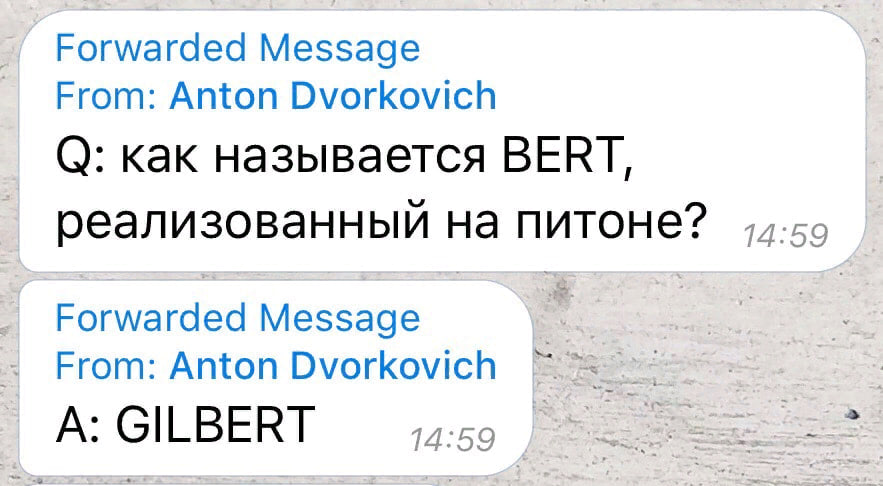

## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [ ]:
# change X_train_enc into you equivalent

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_ohe[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


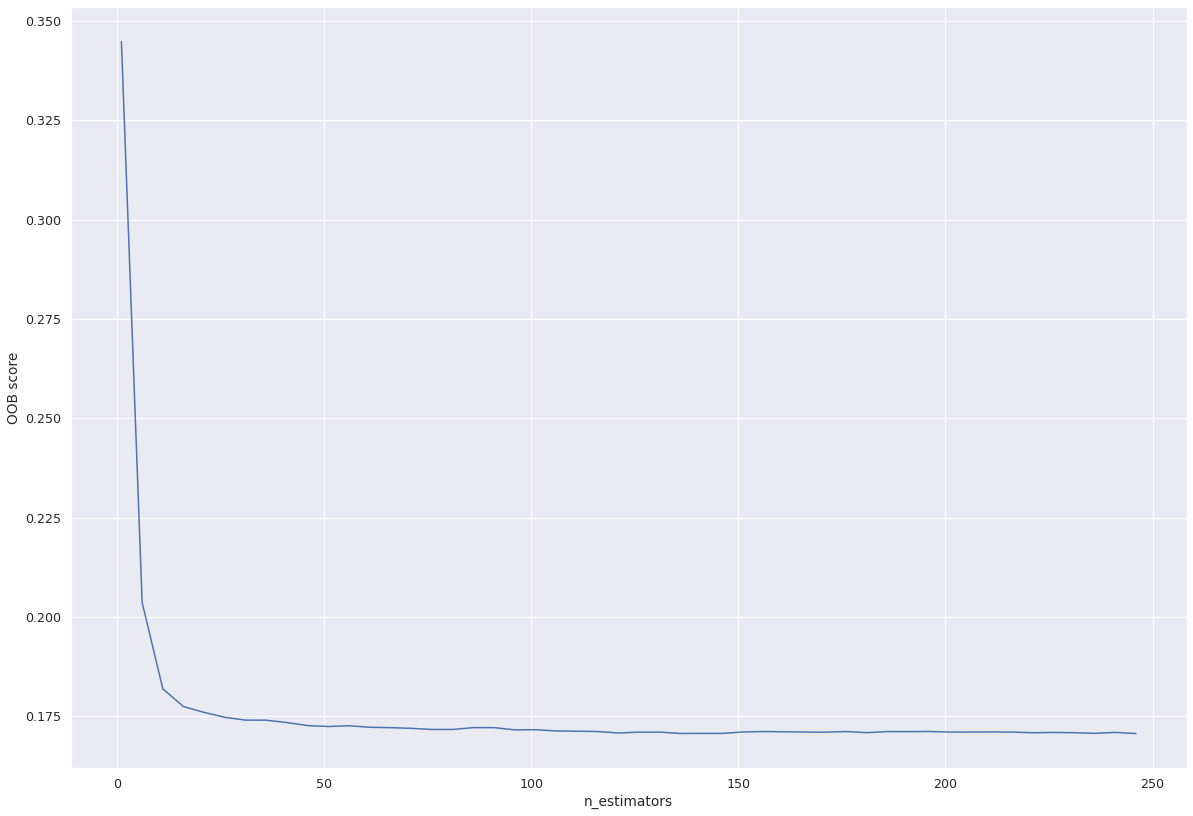

In [ ]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной 

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

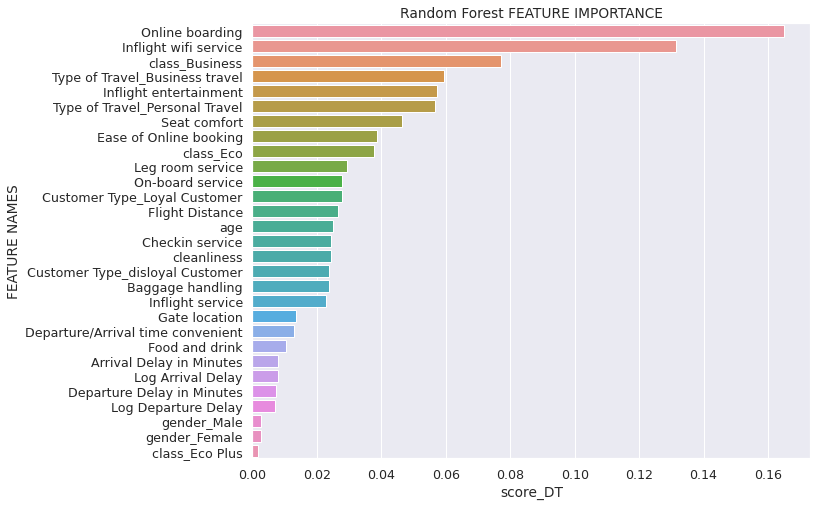

In [ ]:
plot_feature_importance(rf.feature_importances_,X_train_ohe.columns,'Random Forest')

(0.25 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [ ]:
def df_plot(importance,names,model_type):

  feature_importance = np.array(importance)
  feature_names = np.array(names)

  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  model = []
  for i in range(29):
    model.append(model_type)
  
  fi_df['model_type'] = model_type

  return fi_df

In [ ]:
df_rf = df_plot(rf.feature_importances_,X_train_ohe.columns,'Random Forest')

In [ ]:
df_dt = df_plot(dt.feature_importances_, X_train_ohe.columns,'Decision Tree')

In [ ]:
df_conc = pd.concat([df_rf, df_dt])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 [Text(0, 0, 'Online boarding'),
  Text(1, 0, 'Inflight wifi service'),
  Text(2, 0, 'class_Business'),
  Text(3, 0, 'Type of Travel_Business travel'),
  Text(4, 0, 'Inflight entertainment'),
  Text(5, 0, 'Type of Travel_Personal Travel'),
  Text(6, 0, 'Seat comfort'),
  Text(7, 0, 'Ease of Online booking'),
  Text(8, 0, 'class_Eco'),
  Text(9, 0, 'Leg room service'),
  Text(10, 0, 'On-board service'),
  Text(11, 0, 'Customer Type_Loyal Customer'),
  Text(12, 0, 'Flight Distance'),
  Text(13, 0, 'age'),
  Text(14, 0, 'Checkin service'),
  Text(15, 0, 'cleanliness'),
  Text(16, 0, 'Customer Type_disloyal Customer'),
  Text(17, 0, 'Baggage handling'),
  Text(18, 0, 'Inflight service'),
  Text(19, 0, 'Gate location'),
  Text(20, 0, 'Departure/Arrival time convenient'),
  Text(21, 0, 'Food and drink'),
  Text(22, 0, 'Arrival Delay in Minutes'),
  Text(23, 0,

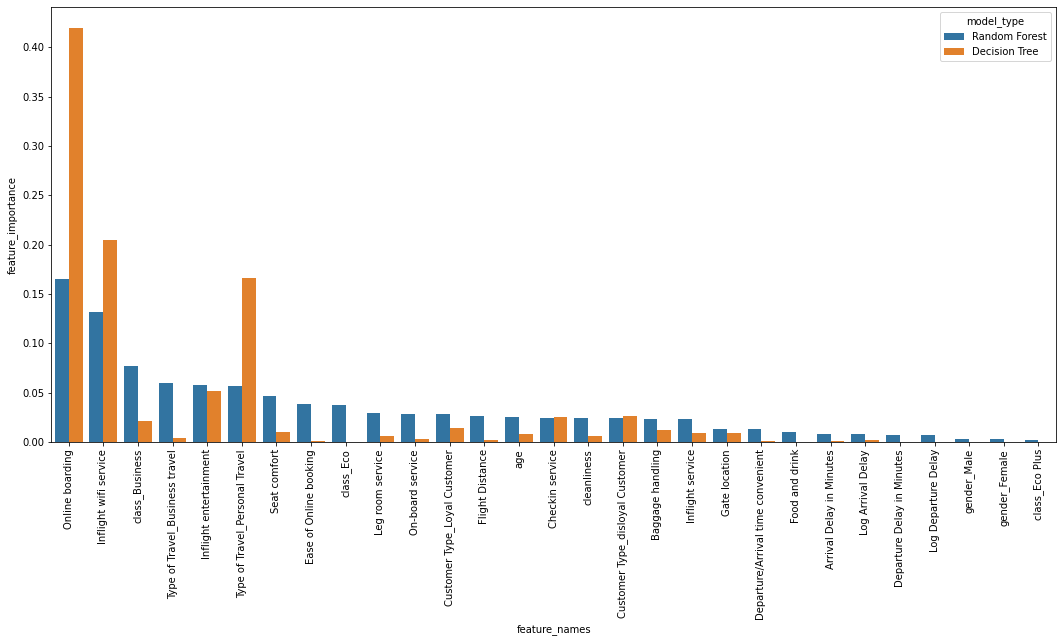

In [ ]:
plt.figure(figsize=(18,8))
sns.barplot(data=df_conc, x="feature_names", y="feature_importance", hue="model_type")
plt.xticks(rotation=90)

(0.25 балла) <font color='#9933CC'>Оцените Permutation Importance вашео случайного леса</font>. Загляните в [документацию библиотеки eli5](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=34).fit(X_val_ohe, y_val)
eli5.show_weights(perm, feature_names = X_val_ohe.columns.tolist())



<font color='#FF6600'>Изучите документацию библиотеки eli5. Перечислите полезные инструменты из неё, которые вам хотелось бы попробовать: </font>

 - show_prediction, чтобы оценить вклад отдельных признаков в прогнозирование каждого из классов.
 - eli5.lime, оценить интерпретацию методом lime

(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [ ]:
shap.initjs()

In [ ]:
rf_explainer = shap.Explainer(rf.predict, X_val_ohe.sample(n=1000, random_state=43))

In [ ]:
shap_values = rf_explainer( X_val_ohe.sample(n=1000, random_state=43))

Permutation explainer: 1001it [15:57,  1.03it/s]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


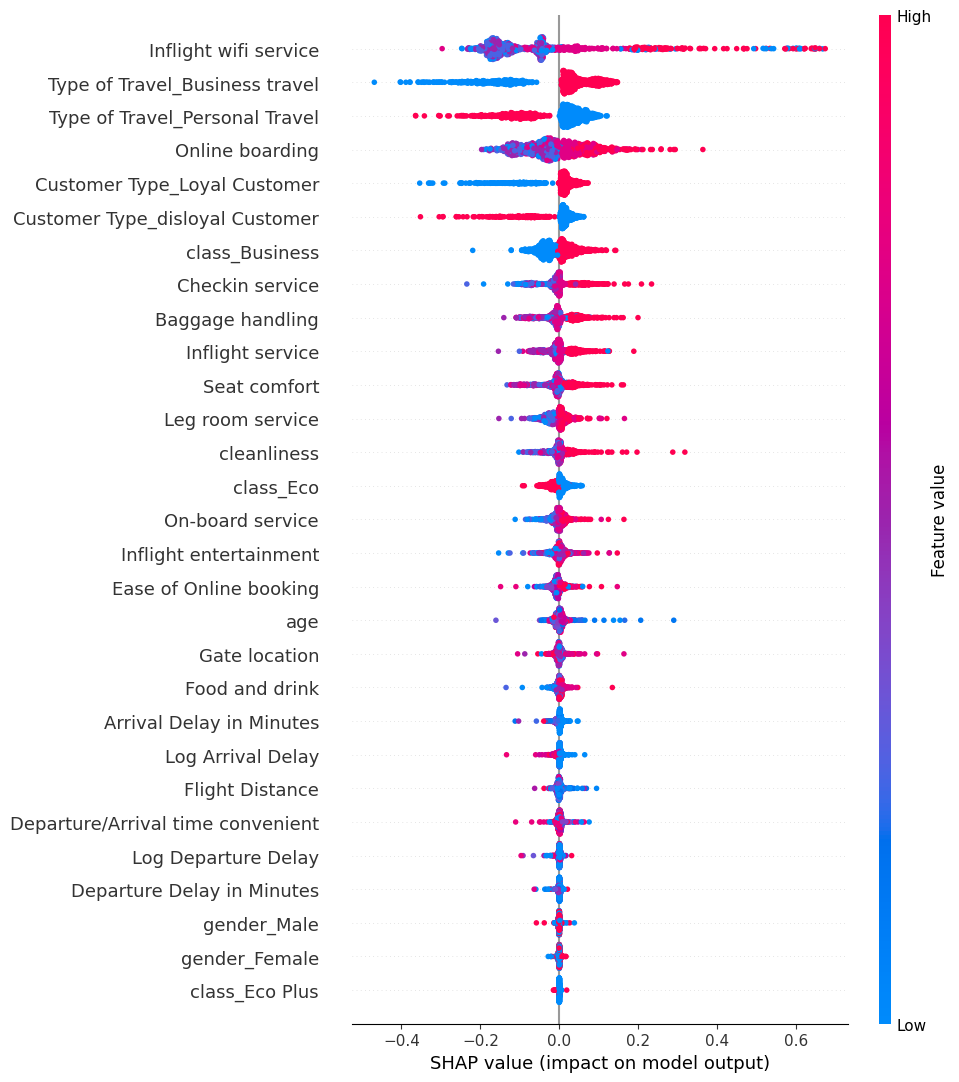

In [ ]:
shap.plots.beeswarm(shap_values, max_display=30)

<font color='#FF6600'>Опишите полученый график</font>

Мы видим насколько влияет каждый признак в ответ модели. То есть в самом верху inflight_wifi_service - означает, что он больше влияет на прогноз, нежели остальные признаки. Вертикальная ось же показывает какой вклад у больших по величине ответов(красная линия), чем у меньших по величине ответов (синяя линия). Видим, что  еще дают вклад в ответ признаки: Buisness Travel, Personal Travel, меньше всего же class Eco plus, gender Female, gender Male.

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в
ней имеется? </font>

- force_plot -показаны величины и признаки, каждый из которых способствует смещению значения модели от базового значения (среднее значение модели по переданному нами обучающему набору данных) к выходу модели. Эта же шкала, повернутая на 90 градусов может показать более подробно, а также остортировать признаки по сходству
- dependence_plot - график зависимости, показывающий влияние одного отдельного признака на весь набор данных


(0.25 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [ ]:
from lime import lime_tabular
import random
from random import randint

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train_ohe.values, 
                                                   mode = 'classification',
                                                   training_labels = y_train,
                                                   feature_names = X_train_ohe.columns.values.tolist())


In [ ]:
idx = random.randint(1, len(X_val_ohe))
explanation = explainer.explain_instance(X_val_ohe.values[idx], rf.predict_proba)
explanation.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<font color='#FF6600'>Опишите полученый график</font>

- Оранжевым цветом на шкале слева показан вклад признаков в ответ отстортированный по величине, например, если удалить Type of Travel_Business travel (0.18 на шкале), то прогноз вероятности уменьшиться на 0.18, то есть (1-0.18). Синяя шкала показывает вклад в вероятность калсс 0, то есть шкалы согласно цветовой гамме показывают вклад в вероятность того или иного ответа от признаков. Справа в таблице показаны значения признаков, которые наиболее значительно влияют на ответ согласно цвету, таковыми явлюятся: Type of Travel_Business travel, Type of Travel_Personal Travel, Online boarding 

In [ ]:
# your explanation below


<font color='#9933CC'>Случайное дерево, дающее лучший скор, сохраните в pickle</font>

In [ ]:
pickle.dump(rf, open('rf.pkl', 'wb'))

In [ ]:
rf = pickle.load(open('rf.pkl', 'rb'))

# Бустинги (1 балл)

## CatBoost (0.25 балла)

(0.25 балла) <font color='#9933CC'>Обучите pipeline из стандартизации континуальных (как договаривались) признаков и `CatBoostClassifier` с параметрами по умолчанию</font>. `StandardScaler` из sklearn не подойдет. Напишите свой собственный, который не будет изменять остальные фичи.

In [ ]:
continuous_cols = ['age', 'Flight Distance', 'Log Departure Delay' , 'Log Arrival Delay']

In [ ]:
class MyStandardScaler(TransformerMixin, BaseEstimator):

    def __init__(self, cols_to_transform):
      self.cols_to_transform = cols_to_transform

    def fit(self, X, y=None):
      return self

    def transform(self, X, y=None):
      for i in self.cols_to_transform:
        X[i] = X[i].apply(lambda x: (x - X[i].mean()) / X[i].std())
      return X
      


In [ ]:
pipe_0 = [
    ('st_scaling', MyStandardScaler(cols_to_transform=['age', 'Flight Distance', 'Log Departure Delay' , 'Log Arrival Delay'])),
    ('cat_boost', CatBoostClassifier())
]
catboost_pipe = Pipeline(pipe_0)

In [ ]:
%%time
catboost_pipe.fit(X_train_ohe, y_train)

Learning rate set to 0.063746
0:	learn: 0.6070153	total: 21ms	remaining: 21s
1:	learn: 0.5381014	total: 35.8ms	remaining: 17.9s
2:	learn: 0.4665723	total: 51.4ms	remaining: 17.1s
3:	learn: 0.4228835	total: 66.4ms	remaining: 16.5s
4:	learn: 0.3842651	total: 81.6ms	remaining: 16.2s
5:	learn: 0.3532730	total: 95.9ms	remaining: 15.9s
6:	learn: 0.3204776	total: 111ms	remaining: 15.7s
7:	learn: 0.3032853	total: 127ms	remaining: 15.8s
8:	learn: 0.2862896	total: 141ms	remaining: 15.6s
9:	learn: 0.2661217	total: 157ms	remaining: 15.5s
10:	learn: 0.2545447	total: 172ms	remaining: 15.5s
11:	learn: 0.2434545	total: 188ms	remaining: 15.4s
12:	learn: 0.2298717	total: 206ms	remaining: 15.6s
13:	learn: 0.2220305	total: 222ms	remaining: 15.6s
14:	learn: 0.2127414	total: 236ms	remaining: 15.5s
15:	learn: 0.2060314	total: 251ms	remaining: 15.4s
16:	learn: 0.2009128	total: 266ms	remaining: 15.4s
17:	learn: 0.1966408	total: 280ms	remaining: 15.3s
18:	learn: 0.1930000	total: 294ms	remaining: 15.2s
19:	learn

Pipeline(steps=[('st_scaling',
                 MyStandardScaler(cols_to_transform=['age', 'Flight Distance',
                                                     'Log Departure Delay',
                                                     'Log Arrival Delay'])),
                ('cat_boost',
                 <catboost.core.CatBoostClassifier object at 0x7fd50d425af0>)])

In [ ]:
%%time
catboost_pipe.predict(X_val_ohe)


CPU times: user 40.3 s, sys: 78 ms, total: 40.4 s
Wall time: 41.1 s


array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
accuracy_score(catboost_pipe.predict(X_val_ohe), y_val)

0.9629920230155616

<font color='#9933CC'>Сохраните себе `feature_importances_` катбуста</font>. Дальше они вам пригодятся

In [ ]:
def df_fi(importance,names,model_type):

  feature_importance = np.array(importance)
  feature_names = np.array(names)

  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  model = []
  for i in range(29):
    model.append(model_type)
  
  fi_df['model_type'] = model_type

  return fi_df

In [ ]:
fi_catboost = catboost_pipe['cat_boost'].get_feature_importance()
fi_catboost

array([ 3.6252035 ,  2.05804144,  0.28381614,  0.48255707, 26.52451844,
        1.60851321,  1.34173093,  3.97402975,  0.36270605,  6.92772269,
        3.42013674,  3.15919797,  1.80483895,  1.3933859 ,  3.28711148,
        3.78665004,  2.86390136,  1.98642335,  0.12979256,  0.38647456,
        0.09831758,  0.05927327,  3.87144867,  2.80029989,  6.89654449,
       11.08568285,  5.03560624,  0.62973731,  0.11633757])

In [ ]:
df_fi_catboost = df_fi(fi_catboost, X_train_ohe.columns, 'catboost')
df_fi_catboost

feature_names  feature_importance model_type
4               Inflight wifi service           26.524518   catboost
25     Type of Travel_Personal Travel           11.085683   catboost
9                     Online boarding            6.927723   catboost
24     Type of Travel_Business travel            6.896544   catboost
26                     class_Business            5.035606   catboost
7                       Gate location            3.974030   catboost
22       Customer Type_Loyal Customer            3.871449   catboost
15                    Checkin service            3.786650   catboost
0                                 age            3.625204   catboost
10                       Seat comfort            3.420137   catboost
14                   Baggage handling            3.287111   catboost
11             Inflight entertainment            3.159198   catboost
16                   Inflight service            2.863901   catboost
23    Customer Type_disloyal Customer            2.800300   catboost
1                     Flight Distance            2.058041   catboost
17                        cleanliness            1.986423   catboost
12                   On-board service            1.804839   catboost
5   Departure/Arrival time convenient            1.608513   catboost
13                   Leg room service            1.393386   catboost
6              Ease of Online booking            1.341731   catboost
27                          class_Eco            0.629737   catboost
3            Arrival Delay in Minutes            0.482557   catboost
19                  Log Arrival Delay            0.386475   catboost
8                      Food and drink            0.362706   catboost
2          Departure Delay in Minutes            0.283816   catboost
18                Log Departure Delay            0.129793   catboost
28                     class_Eco Plus            0.116338   catboost
20                      gender_Female            0.098318   catboost
21                        gender_Male            0.059273   catboost

## XGBoost + optuna (0.5 балла)

<font color='#9933CC'>Обучите `XGBClassifier` с параметрами по умолчанию</font>

In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb.fit(X_train_ohe, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
accuracy_score(xgb.predict(X_val_ohe), y_val)

0.9626977899829998

(0.5 балла) <font color='#9933CC'>Оптуной подберите лучшие гиперпараметры для XGBoost</font> 

Полезные ссылки: [тык1](https://optuna.readthedocs.io/en/stable/), [тык2](https://habr.com/ru/post/704432/)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
def objective(trial):

  max_depth = trial.suggest_int("max_depth", 2, 20)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
  n_estimators = trial.suggest_int("n_estimators", 10, 1000)

  score = cross_val_score(LGBMClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators),
                            X_train_ohe, y_train, cv=3, scoring='accuracy', n_jobs=-1).mean()
  return score


In [ ]:
%%time
study = optuna.create_study(study_name="xgboost", direction='maximize')
study.optimize(objective, n_trials=30 )

[I 2023-04-01 10:43:17,745] A new study created in memory with name: xgboost
[I 2023-04-01 10:43:36,586] Trial 0 finished with value: 0.9368303217957458 and parameters: {'max_depth': 2, 'learning_rate': 0.024081338471980265, 'n_estimators': 705}. Best is trial 0 with value: 0.9368303217957458.
[I 2023-04-01 10:43:41,272] Trial 1 finished with value: 0.9270817334844655 and parameters: {'max_depth': 8, 'learning_rate': 0.0016237994798323277, 'n_estimators': 187}. Best is trial 0 with value: 0.9368303217957458.
[I 2023-04-01 10:43:53,412] Trial 2 finished with value: 0.8478045227749638 and parameters: {'max_depth': 2, 'learning_rate': 0.0009133189111902164, 'n_estimators': 760}. Best is trial 0 with value: 0.9368303217957458.
[I 2023-04-01 10:44:00,772] Trial 3 finished with value: 0.9609216384491597 and parameters: {'max_depth': 4, 'learning_rate': 0.1762331414537936, 'n_estimators': 381}. Best is trial 3 with value: 0.9609216384491597.
[I 2023-04-01 10:44:27,241] Trial 4 finished with v

CPU times: user 3.41 s, sys: 608 ms, total: 4.02 s
Wall time: 7min 7s


<font color='#9933CC'>Обучите XGBClassifier c подобранными гиперпараметрами</font>

In [ ]:
study.best_params

{'max_depth': 9, 'learning_rate': 0.03219801212957267, 'n_estimators': 528}

In [ ]:
xgb_best = XGBClassifier(
    **study.best_params,
    random_state=42)


In [ ]:
xgb_best.fit(X_train_ohe, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03219801212957267,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=528, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
accuracy_score(xgb_best.predict(X_val_ohe), y_val)

0.9627304825421734

<font color='#9933CC'>Сохраните себе `feature_importances_` xbgoost'а</font>. Дальше они вам пригодятся

In [ ]:
fi_xgboost = xgb_best.feature_importances_
fi_xgboost

array([0.00618948, 0.00311332, 0.00271771, 0.00424619, 0.10955925,
       0.00439206, 0.00636736, 0.01382801, 0.00346534, 0.4275005 ,
       0.01352862, 0.04002079, 0.01150974, 0.01209248, 0.01223573,
       0.01873795, 0.01190923, 0.01432236, 0.        , 0.        ,
       0.00233214, 0.        , 0.05520644, 0.        , 0.17209587,
       0.        , 0.04878641, 0.00347953, 0.00236351], dtype=float32)

In [ ]:
df_fi_xgboost = df_fi(fi_xgboost, X_train_ohe.columns, 'xgboost')
df_fi_xgboost

feature_names  feature_importance model_type
9                     Online boarding            0.427500    xgboost
24     Type of Travel_Business travel            0.172096    xgboost
4               Inflight wifi service            0.109559    xgboost
22       Customer Type_Loyal Customer            0.055206    xgboost
26                     class_Business            0.048786    xgboost
11             Inflight entertainment            0.040021    xgboost
15                    Checkin service            0.018738    xgboost
17                        cleanliness            0.014322    xgboost
7                       Gate location            0.013828    xgboost
10                       Seat comfort            0.013529    xgboost
14                   Baggage handling            0.012236    xgboost
13                   Leg room service            0.012092    xgboost
16                   Inflight service            0.011909    xgboost
12                   On-board service            0.011510    xgboost
6              Ease of Online booking            0.006367    xgboost
0                                 age            0.006189    xgboost
5   Departure/Arrival time convenient            0.004392    xgboost
3            Arrival Delay in Minutes            0.004246    xgboost
27                          class_Eco            0.003480    xgboost
8                      Food and drink            0.003465    xgboost
1                     Flight Distance            0.003113    xgboost
2          Departure Delay in Minutes            0.002718    xgboost
28                     class_Eco Plus            0.002364    xgboost
20                      gender_Female            0.002332    xgboost
18                Log Departure Delay            0.000000    xgboost
19                  Log Arrival Delay            0.000000    xgboost
21                        gender_Male            0.000000    xgboost
23    Customer Type_disloyal Customer            0.000000    xgboost
25     Type of Travel_Personal Travel            0.000000    xgboost

## LightGBM + Pipeline (0.25 балла)

(0.25 балла) И наконец, <font color='#9933CC'>обучите пайплайн из стандартизации признаков "Age" и "FlightDistance",  нормализации фичей "log_arrival_delay" и "log_departure_delay" и `LGBMClassifier` с параметрами по умолчанию</font>. Вам снова понадобится свой кастомный Scaler, который не будет трогать остальные фичи

In [ ]:
class  MyMinMaxScaler(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self, cols_to_transform):
      self.cols_to_transform = cols_to_transform

    def fit(self, X, y=None):
      return self

    def transform(self, X, y=None):
      for i in self.cols_to_transform:
        X[i] = X[i].apply(lambda x: (x - X[i].min()) / (X[i].max() - X[i].min()))
      return X
      

In [ ]:
pipe = [
    ('std_scaling', MyStandardScaler(cols_to_transform=['age', "Flight Distance"])),
    ('min_max', MyMinMaxScaler(cols_to_transform=['Log Arrival Delay', "Log Departure Delay"])),
    ('lgbm', LGBMClassifier())
]
lgbm_pipeline = Pipeline(pipe)



In [ ]:
lgbm_pipeline.fit(X_train_ohe, y_train)

Pipeline(steps=[('std_scaling',
                 MyStandardScaler(cols_to_transform=['age',
                                                     'Flight Distance'])),
                ('min_max',
                 MyMinMaxScaler(cols_to_transform=['Log Arrival Delay',
                                                   'Log Departure Delay'])),
                ('lgbm', LGBMClassifier())])

In [ ]:
accuracy_score(lgbm_pipeline.predict(X_val_ohe), y_val)

0.9617170132077939

<font color='#9933CC'>Сохраните себе `feature_importances_` lgbm'а</font>. Дальше они вам пригодятся

In [ ]:
fi_lgbm = lgbm_pipeline['lgbm'].feature_importances_
fi_lgbm

array([249, 170,  59, 111, 514,  56,  85, 137,  25, 173, 130, 116,  80,
        87, 165, 108, 151, 111,   0,   0,  12,   4, 159,   1, 139,   2,
       135,  19,   2], dtype=int32)

In [ ]:
df_fi_lgbm = df_fi(fi_lgbm, X_train_ohe.columns, 'lgbm')
df_fi_lgbm

feature_names  feature_importance model_type
4               Inflight wifi service                 514       lgbm
0                                 age                 249       lgbm
9                     Online boarding                 173       lgbm
1                     Flight Distance                 170       lgbm
14                   Baggage handling                 165       lgbm
22       Customer Type_Loyal Customer                 159       lgbm
16                   Inflight service                 151       lgbm
24     Type of Travel_Business travel                 139       lgbm
7                       Gate location                 137       lgbm
26                     class_Business                 135       lgbm
10                       Seat comfort                 130       lgbm
11             Inflight entertainment                 116       lgbm
17                        cleanliness                 111       lgbm
3            Arrival Delay in Minutes                 111       lgbm
15                    Checkin service                 108       lgbm
13                   Leg room service                  87       lgbm
6              Ease of Online booking                  85       lgbm
12                   On-board service                  80       lgbm
2          Departure Delay in Minutes                  59       lgbm
5   Departure/Arrival time convenient                  56       lgbm
8                      Food and drink                  25       lgbm
27                          class_Eco                  19       lgbm
20                      gender_Female                  12       lgbm
21                        gender_Male                   4       lgbm
25     Type of Travel_Personal Travel                   2       lgbm
28                     class_Eco Plus                   2       lgbm
23    Customer Type_disloyal Customer                   1       lgbm
19                  Log Arrival Delay                   0       lgbm
18                Log Departure Delay                   0       lgbm

<font color='#9933CC'>Сохраните получившиеся бустинги (лучший xgboost, lgmb и catboost) в pickle</font>

<img src='https://i.imgur.com/qBFSCjZ.jpg' height=500px>

In [ ]:
pickle.dump(lgbm_pipeline, open('lgbm_pipe.pkl', 'wb'))

In [ ]:
pickle.dump(xgb_best, open('xgb_best.pkl', 'wb'))

In [ ]:
pickle.dump(catboost_pipe, open('catboost_pipe.pkl', 'wb'))

In [ ]:
lgbm_pipe = pickle.load(open('lgbm_pipe.pkl', 'rb'))

In [ ]:
xgb_best = pickle.load(open('xgb_best.pkl', 'rb'))

In [ ]:
catboost_pipe = pickle.load(open('catboost_pipe.pkl', 'rb'))

# Стекинг (0.5 балла)

(0.25 балла) <font color='#9933CC'>Воспользуйтесь `StackingClassifier` из skearn для ансаблирования обученных вами к этому шагу моделей</font>

In [ ]:
estimators = [('random_forest', rf),
              ('log_reg',lr),
              ('dt',dt)]

reg = StackingClassifier(estimators=estimators,
                        cv=10,
                        final_estimator=CatBoostClassifier())

reg.fit(X_train_ohe, y_train)
reg_preds = reg.predict(X_val_ohe)



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Learning rate set to 0.063746
0:	learn: 0.5558751	total: 10.7ms	remaining: 10.7s
1:	learn: 0.4456855	total: 21.2ms	remaining: 10.6s
2:	learn: 0.3530666	total: 31.7ms	remaining: 10.5s
3:	learn: 0.3049161	total: 42ms	remaining: 10.5s
4:	learn: 0.2587823	total: 52.7ms	remaining: 10.5s
5:	learn: 0.2249046	total: 63.3ms	remaining: 10.5s
6:	learn: 0.2002139	total: 73.6ms	remaining: 10.4s
7:	learn: 0.1811815	total: 83.9ms	remaining: 10.4s
8:	learn: 0.1621528	total: 94ms	remaining: 10.4s
9:	learn: 0.1511836	total: 105ms	remaining: 10.4s
10:	learn: 0.1386155	total: 124ms	remaining: 11.1s
11:	learn: 0.1323374	total: 134ms	remaining: 11.1s
12:	learn: 0.1270913	total: 145ms	remaining: 11s
13:	learn: 0.1226039	total: 158ms	remaining: 11.1s
14:	learn: 0.1183251	total: 168ms	remaining: 11s
15:	learn: 0.1155556	total: 178ms	remaining: 11s
16:	learn: 0.1124715	total: 189ms	remaining: 10.9s
17:	learn: 0.1103290	total: 203ms	remaining: 11.1s
18:	learn: 0.1082621	total: 213ms	remaining: 11s
19:	learn: 0.1

In [ ]:
accuracy_score(y_val, reg_preds)

0.9603766182816791

<font color='#9933CC'>Посмотрим, откалиброваны ли полученные после стекинга вероятности</font>

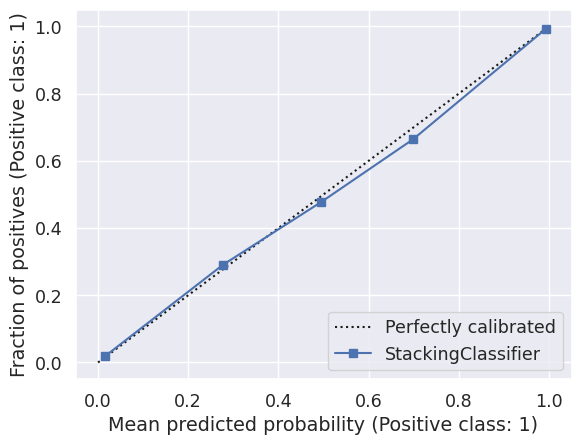

In [ ]:
displ_ansamb= CalibrationDisplay.from_estimator(reg, X_val_ohe, y_val)

Неожиданно хорошо. Не так ли?

(0.25 балла) <font color='#9933CC'>Постройте ROC- и PR-кривые для полученной композиции. Также выведите другие метрики классификации: F1-score, precision, recall

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

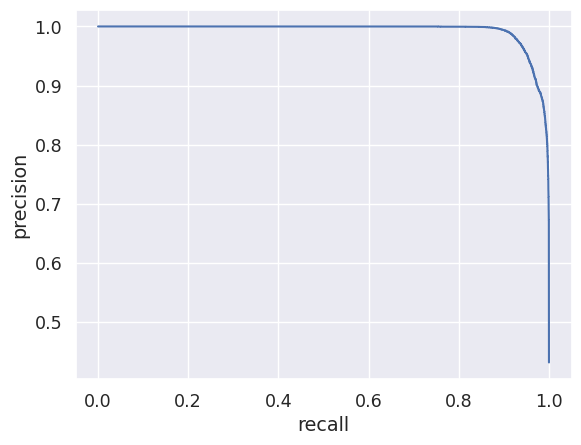

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_val, reg.predict_proba(X_val_ohe)[:,1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

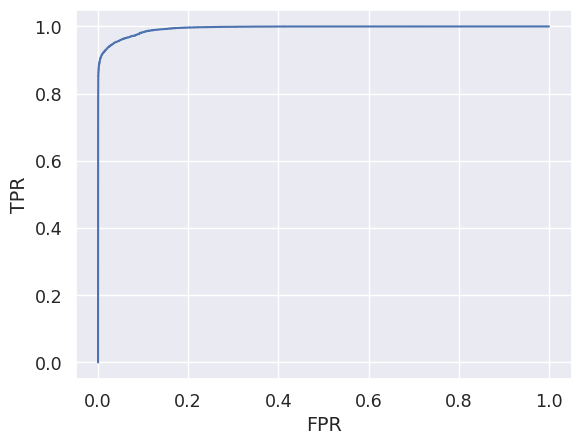

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val,reg.predict_proba(X_val_ohe)[:,1] )
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [ ]:
report = classification_report(y_val, reg.predict(X_val_ohe))
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     17383
           1       0.96      0.93      0.94     13205

    accuracy                           0.95     30588
   macro avg       0.95      0.95      0.95     30588
weighted avg       0.95      0.95      0.95     30588



# Aftermath (1 балл)

В этом домашнем занятии до настоящей ячейки вы обучали модели на всех признаках из обучающей выборки. Давайте под конец попробуем избавиться от признаков, минимально влияющих на результат

Мы довольно часто выводили `feature_importances_` алгоритмов. Пробовали интерпретировать предсказания модели SHAP'ом. Неплохо бы структурировать и валидировать полученные знания.

(0.25 балла) <font color='#9933CC'>Создайте таблицу, в которой для сохраненных вами pickle'ом классификаторов в соответсвующих столбцах будут отранжированные по убыванию `feature_importances_` для этого конкретного классификатора.</font>

По такой таблице должно быть относительно удобно понять, какие признаки (в среднем для разных моделей) важнее остальных для предсказания целевой переменной

In [ ]:
# (•_•)



<font color='#FF6600'>Сделайте выводы: какие 3 признака скорее всего можно удалить?</font>

(0.25 балла) <font color='#9933CC'>Далее для отбора признаков воспользуемся статистическими тестами</font>. Попробуйте отобрать 20 наиболее информативных признака, используя `SelectKBest` из `sklearn.feature_selection`. В качестве статтестов примените (отдельно) `chi2` и `mutual_info_classif` 

In [ ]:
# (•_•)



<font color='#FF6600'>Согласуются ли списки признаков-кандитатов на удаление?</font>

In [ ]:
# fell free to change this cell into markdown



(0.25 балла)<font color='#9933CC'>Теперь применим жадные методы отбора признаков</font>. Воспользуйтесь классом `RFECV` для этого. <font color='#FF6600'>Сколько признаков были отобраны как наиболее информативные? Перечислите предложенные к удалению.</font>

In [ ]:
# -____-



(0.25 балла) <font color='#9933CC'>C помощью логистической регрессией с L1-регуляризацией отберите >=5 неифнормативных признака</font>.

In [ ]:
# -____-



<font color='#9933CC'>Удалите 4 признака, которые считаете нужным удалить</font> <font color='#FF6600'>(если хотите больше -- пожалуйста, только обоснуйте целесообразность)</font>. <font color='#9933CC'>Обучите RandomForestClassifier с параметрами по умолчанию на этих признаках</font>. <font color='#FF6600'>Сильно ли уменьшилось качество на валидационной выборке? О чем это говорит?</font>

In [ ]:
# -___-



## Могли попросить, но не попросили (0 баллов, но >0 пользы).

Это домашнее задание уже получилось довольно объемным. Нам хотелось бы добавить ещё несколько (вообще говоря много) заданий -- однако хватит. Ниже некоторые из невошедших заданий

<font color='#29ab87'>На свое усмотрение выберите несколько (>= 3) классификаторов. На кросс-валидации переберите для каждого из них несколько (>=4) значений одного гиперпараметра. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра. На этом же графике изобразите доверительный интервал `[mean - std; mean + std]`</font>

<font color='#29ab87'>Для любой из модификаций бустинга (выберите себе по душе) постройте график ошибки композиции в зависимости от числа деревьев. Подберите гиперпараметр `n_estimators` по этому графику и обоснуйте свой выбор. Какую форму имеет получившаяся у вас ошибка на тесте? Согласуется ли это с теорией?</font>

<font color='#29ab87'>На модельном примере (для 2-х наиболее информативных "континуальных" признаков датасета этой домашки) покажите, как усложняется разделяющая поверхность композиции деревьев бустингом при добавлении в неё нового базового алгоритма, исправляющего ошибку предыдущего ансамбля</font>

<font color='#29ab87'>Постройте решающее дерево без каких-либо ограничений. Посчитайте качество на трейне и валидации. Сравнив их, сделайте выводы о переобучении. Примените какой-нибудь из методов pruning'а. Как изменилось дерево после разреживания (насколько меньше стало листов, изменилась ли глубина и пр.)? Сильно ли упало качество на трейне? Удалось ли перебороть переобучение?

# SQL INSERT (0.25 балла + 0.5)

В схеме `results` базы данных `db_flights` создано две таблицы:

1) `student_results` со столбцами:

```
* name (text)
* surname (text)
* best_algorithm (text)
* cv_score_best_algorithm (numeric(8,5))
* time_fit_best_algorithm (numeric(8,5))
* time_predict_best_algorithm (numeric(8,5))
```



2) `student_predictions` со столбцами:
```
* surname (text)
* id (integer)
* prediction (boolean)
```

У вас есть только возможность вставить данные в таблицу (INSERT), других прав на эту таблицу у вас нет.

**Задание 1 (0.25 балла), БЛОК!!!** <font color='#9933CC'> Вставьте одну строку в таблицу `student_results`, содержащую ваше имя, фамилию, название лучшего сработавшего у вас алгоритма, качество (accuracy) этого алгоритма на кросс-валидации, время обучения алгоритма и время применения алгоритма.</font>

**Задание 2 (0.5 балла), бонус** <font color='#9933CC'> Вставьте в таблицу `student_predictions` предсказания вашей наилучшей модели на тестовых данных. Число строк должно быть равно числу объектов в тестовых данных. В каждой строке столбца `surname` должна быть ваша фамилия, в столбце `id` - id объекта из тестовой выборки, в столбце `prediction` - предсказание вашей лучшей модели (класс).</font>


In [ ]:
conn = psycopg2.connect(host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
port=6432,
sslmode='verify-full',
dbname='db_flights',
user='mlhs_student',
password='mlhs_student',
target_session_attrs='read-write')

In [ ]:
cur = conn.cursor()

In [ ]:
cur.execute("INSERT INTO student_results VALUES ('Shokhrukh', ' Yusupov', 'CatBoost (in pipline)', 0.96299, 173, 40)")

In [ ]:
conn.commit()

In [ ]:
cur.close()
conn.close()

<img src='https://avatars.mds.yandex.net/get-images-cbir/1624848/cc-ejKx9OmtUbvaWx4cTNw1262/ocr' height=500px>

# Бонусная (+ 2.5 балла)

(0.5 балла) <font color='#9933CC'>Попробуйте различные знакомые вам подходы к  feature engineering</font>.

* Некоторые признаки возможно стоит бинаризовать. 
* Заполнять пропуски можно по-другому (умнее, чем мы сделали в начале)
* Можно добавить полиномы и другие фичи, попробовать воспользоваться методами снижения размерности и перейти в другое пространство признаков

*Известно, что скоррелированные признаки -- большая проблема почти для всех моделей машинного обучения. Значит, для стекинга важно, чтобы ответы базовых алгоритмов поменьше коррелировали между собой. Отчасти добиться этого можно добавлением в стекинг моделей разной природы. На соревнованиях по анализу табличных данных, например, в стекинг добавляют в т.ч. нейронные сети.*

(0.5 балла) <font color='#9933CC'>Добавьте в стекинг линейные и др. известные вам модели</font>. Не забудьте, что для них требуются другие пайплайны. Например, стандартизация признаков для деревянных моделей зачастую бессмысленна. Чего нельзя сказать о моделях линейных. <font color='#FF6600'>Позволил ли стекинг повысить качество по сравнению с лучшей его базовой моделью?</font>

(до 1.5 балла) <font color='#9933CC'>По 0.1 балла за каждую тысячную в скоре выше 0.962.</font>

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?